In [8]:
from matplotlib import pyplot
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from pyspark.sql import functions as pyspark_function
from urllib.request import urlopen
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import mktime
import time
from datetime import date, timedelta, datetime, tzinfo
import time

In [2]:
import pyspark
import random
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.functions as pyf
import numpy as np
import pandas 
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


        
spark = SparkSession \
        .builder \
        .appName("Test Spark") \
        .config("spark.jars", "/opt/postgresql-42.4.0.jar") \
        .config("spark.num.executors"," 16")  \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.memory", "20g") \
        .config("spark.scheduler.mode", "FAIR") \
        .config("spark.sql.autoBroadcastJoinThreshold", -1) \
        .master("spark://131.225.58.251:7077") \
        .getOrCreate() \



#spark.conf.set("spark.executor.memory", "20g")
#spark.conf.set("spark.executor.cores", "8")

22/06/30 17:28:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/06/30 17:28:17 WARN FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.


In [4]:
df = spark.read \
     .format("jdbc") \
     .option("url", "jdbc:postgresql://fndca5b:5432/billing") \
     .option("dbtable", "(select *,  split_part(storageclass, '.', 1) as vo, date_trunc('hour', datestamp) as date from storageinfo where datestamp between '2022-06-01 00:00:00' and now()) as foo") \
     .option("user", "enstore_reader") \
     .option("driver", "org.postgresql.Driver") \
     .option("numPartitions", "16") \
     .option("partitionColumn", "datestamp") \
     .option("lowerBound", "2022-06-01 00:00:00") \
     .option("upperBound", "2022-06-30 23:59:59") \
     .option("fetchsize", 1000000) \
     .load()

df.printSchema()

root
 |-- queuedtime: long (nullable = true)
 |-- fullsize: long (nullable = true)
 |-- storageclass: string (nullable = true)
 |-- connectiontime: long (nullable = true)
 |-- action: string (nullable = true)
 |-- cellname: string (nullable = true)
 |-- datestamp: timestamp (nullable = true)
 |-- errorcode: integer (nullable = true)
 |-- errormessage: string (nullable = true)
 |-- pnfsid: string (nullable = true)
 |-- transaction: string (nullable = true)
 |-- vo: string (nullable = true)
 |-- date: timestamp (nullable = true)



In [5]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Column Name  Data type
0       queuedtime     bigint
1         fullsize     bigint
2     storageclass     string
3   connectiontime     bigint
4           action     string
5         cellname     string
6        datestamp  timestamp
7        errorcode        int
8     errormessage     string
9           pnfsid     string
10     transaction     string
11              vo     string
12            date  timestamp

In [9]:
t0 = time.time()
print("Number of entries is    =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries is    =====>  13564650  Time to execute  5.920039176940918


In [10]:
df.createOrReplaceTempView("billing")
df.cache()
print("Number of entries again =====> ", df.count(), " Time to execute ", time.time()-t0)

DataFrame[queuedtime: bigint, fullsize: bigint, storageclass: string, connectiontime: bigint, action: string, cellname: string, datestamp: timestamp, errorcode: int, errormessage: string, pnfsid: string, transaction: string, vo: string, date: timestamp]

Number of entries again =====>  13564669  Time to execute  39.23957347869873


In [11]:
df_vo = spark.sql("select date, sum(case when action = 'restore' then 1 else 0 END) as restores, sum(case when action = 'store' then 1 else 0 END)as stores, vo   FROM billing where errorcode = 0  group by date ,vo order by vo, date asc;")

In [12]:
df_vo.count()
df_vo.show(1000)


7597

+-------------------+--------+------+-------+
|               date|restores|stores|     vo|
+-------------------+--------+------+-------+
|2022-06-01 00:00:00|       0|   621|    GM2|
|2022-06-01 01:00:00|       0|   275|    GM2|
|2022-06-01 02:00:00|       0|    33|    GM2|
|2022-06-01 03:00:00|       0|   576|    GM2|
|2022-06-01 04:00:00|       0|   855|    GM2|
|2022-06-01 05:00:00|       0|   531|    GM2|
|2022-06-01 06:00:00|       0|   531|    GM2|
|2022-06-01 07:00:00|       0|   768|    GM2|
|2022-06-01 08:00:00|       0|   509|    GM2|
|2022-06-01 09:00:00|       0|   779|    GM2|
|2022-06-01 10:00:00|       0|   576|    GM2|
|2022-06-01 11:00:00|       0|   611|    GM2|
|2022-06-01 12:00:00|       0|   410|    GM2|
|2022-06-01 13:00:00|       0|   492|    GM2|
|2022-06-01 14:00:00|       0|   741|    GM2|
|2022-06-01 15:00:00|       0|   628|    GM2|
|2022-06-01 16:00:00|       0|   487|    GM2|
|2022-06-01 17:00:00|       0|   328|    GM2|
|2022-06-01 18:00:00|       0|   4

In [13]:
d3=df_vo.toPandas()
print(d3)

                    date  restores  stores         vo
0    2022-06-01 00:00:00         0     621        GM2
1    2022-06-01 01:00:00         0     275        GM2
2    2022-06-01 02:00:00         0      33        GM2
3    2022-06-01 03:00:00         0     576        GM2
4    2022-06-01 04:00:00         0     855        GM2
5    2022-06-01 05:00:00         0     531        GM2
6    2022-06-01 06:00:00         0     531        GM2
7    2022-06-01 07:00:00         0     768        GM2
8    2022-06-01 08:00:00         0     509        GM2
9    2022-06-01 09:00:00         0     779        GM2
10   2022-06-01 10:00:00         0     576        GM2
11   2022-06-01 11:00:00         0     611        GM2
12   2022-06-01 12:00:00         0     410        GM2
13   2022-06-01 13:00:00         0     492        GM2
14   2022-06-01 14:00:00         0     741        GM2
15   2022-06-01 15:00:00         0     628        GM2
16   2022-06-01 16:00:00         0     487        GM2
17   2022-06-01 17:00:00    

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


vo
GM2          AxesSubplot(0.125,0.2;0.775x0.68)
Simons       AxesSubplot(0.125,0.2;0.775x0.68)
accelai      AxesSubplot(0.125,0.2;0.775x0.68)
annie        AxesSubplot(0.125,0.2;0.775x0.68)
backups      AxesSubplot(0.125,0.2;0.775x0.68)
darkside     AxesSubplot(0.125,0.2;0.775x0.68)
des          AxesSubplot(0.125,0.2;0.775x0.68)
dune         AxesSubplot(0.125,0.2;0.775x0.68)
e1039        AxesSubplot(0.125,0.2;0.775x0.68)
e906         AxesSubplot(0.125,0.2;0.775x0.68)
fermigrid    AxesSubplot(0.125,0.2;0.775x0.68)
icarus       AxesSubplot(0.125,0.2;0.775x0.68)
lariat       AxesSubplot(0.125,0.2;0.775x0.68)
lqcd         AxesSubplot(0.125,0.2;0.775x0.68)
minerva      AxesSubplot(0.125,0.2;0.775x0.68)
mu2e         AxesSubplot(0.125,0.2;0.775x0.68)
next         AxesSubplot(0.125,0.2;0.775x0.68)
none         AxesSubplot(0.125,0.2;0.775x0.68)
nova         AxesSubplot(0.125,0.2;0.775x0.68)
sbnd         AxesSubplot(0.125,0.2;0.775x0.68)
snoplus      AxesSubplot(0.125,0.2;0.775x0.68)
test      

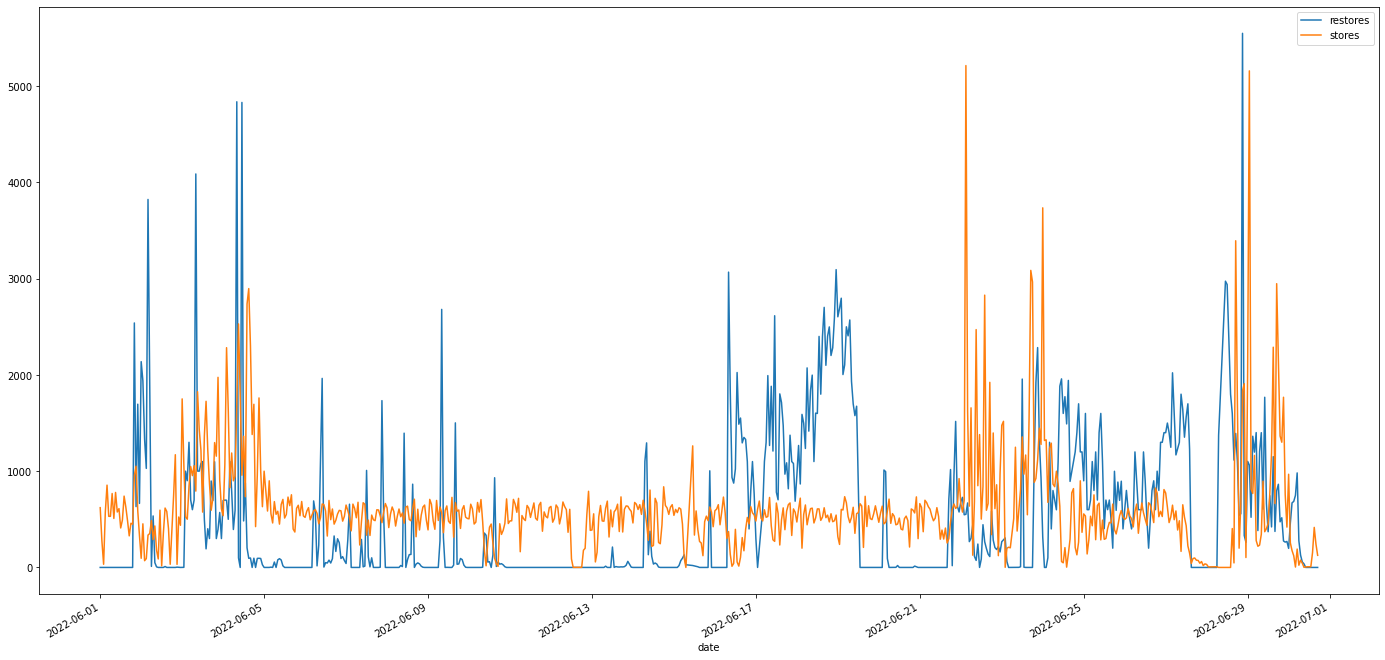

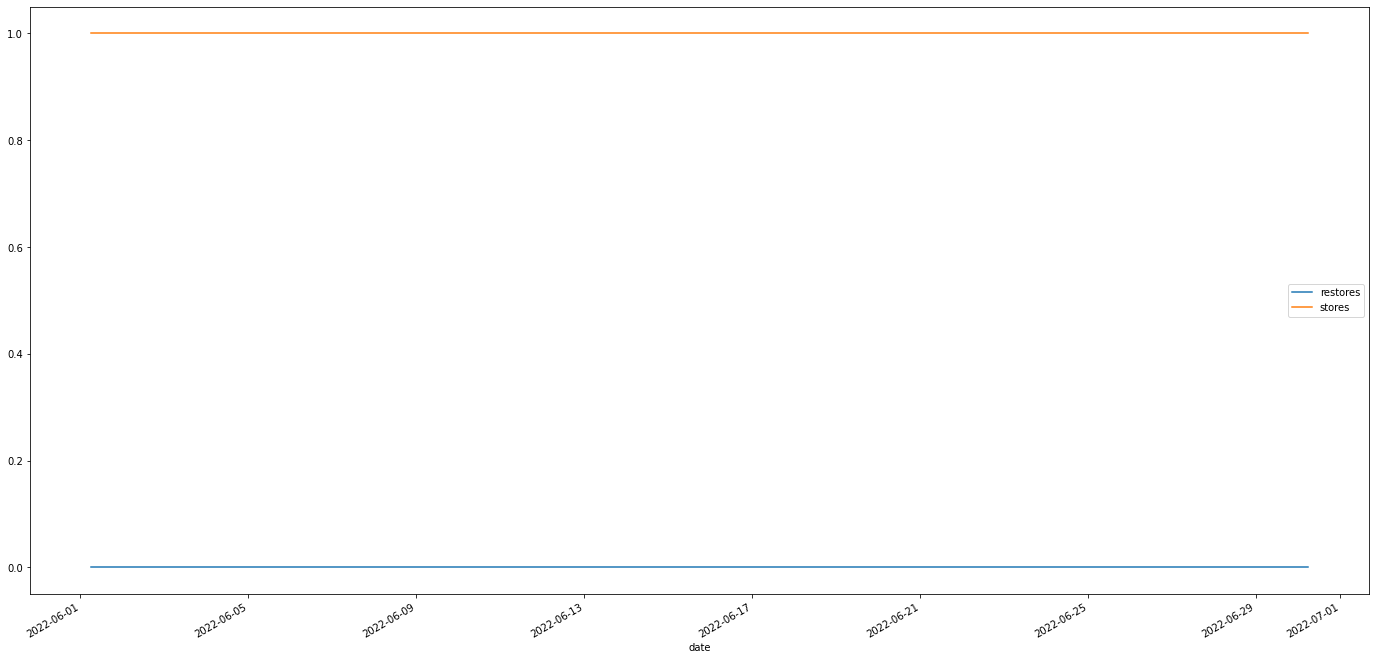

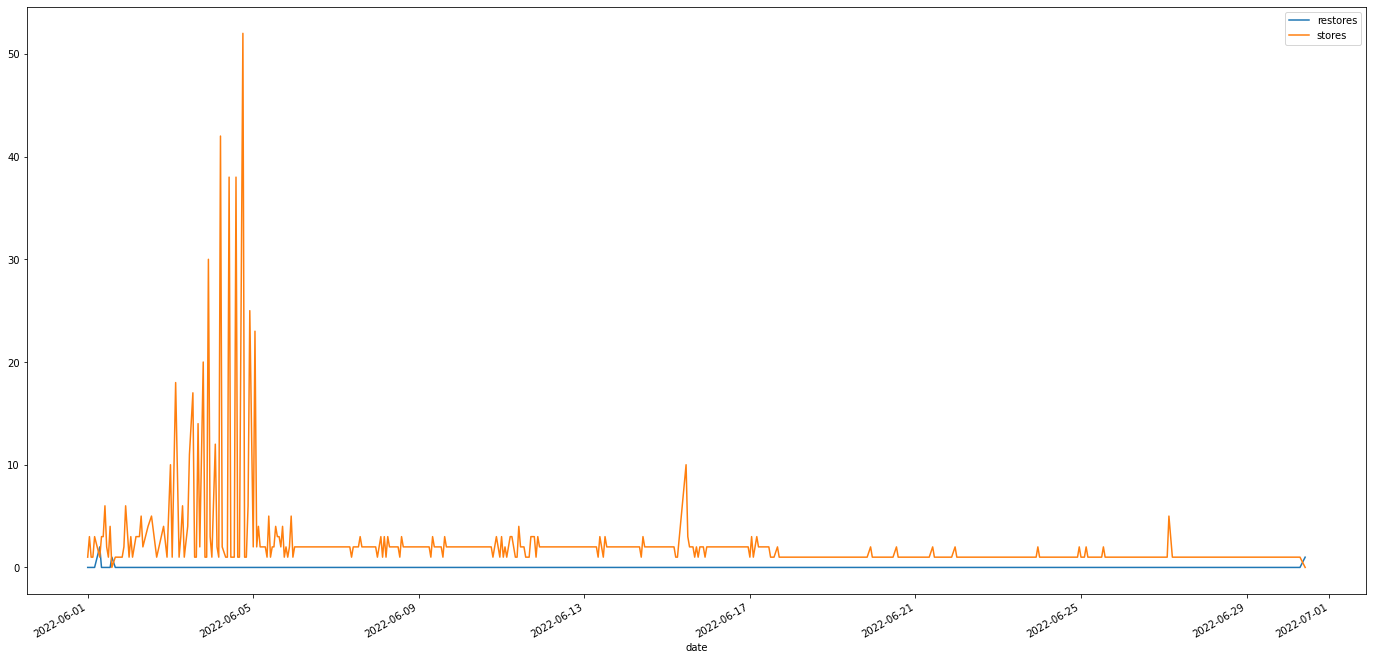

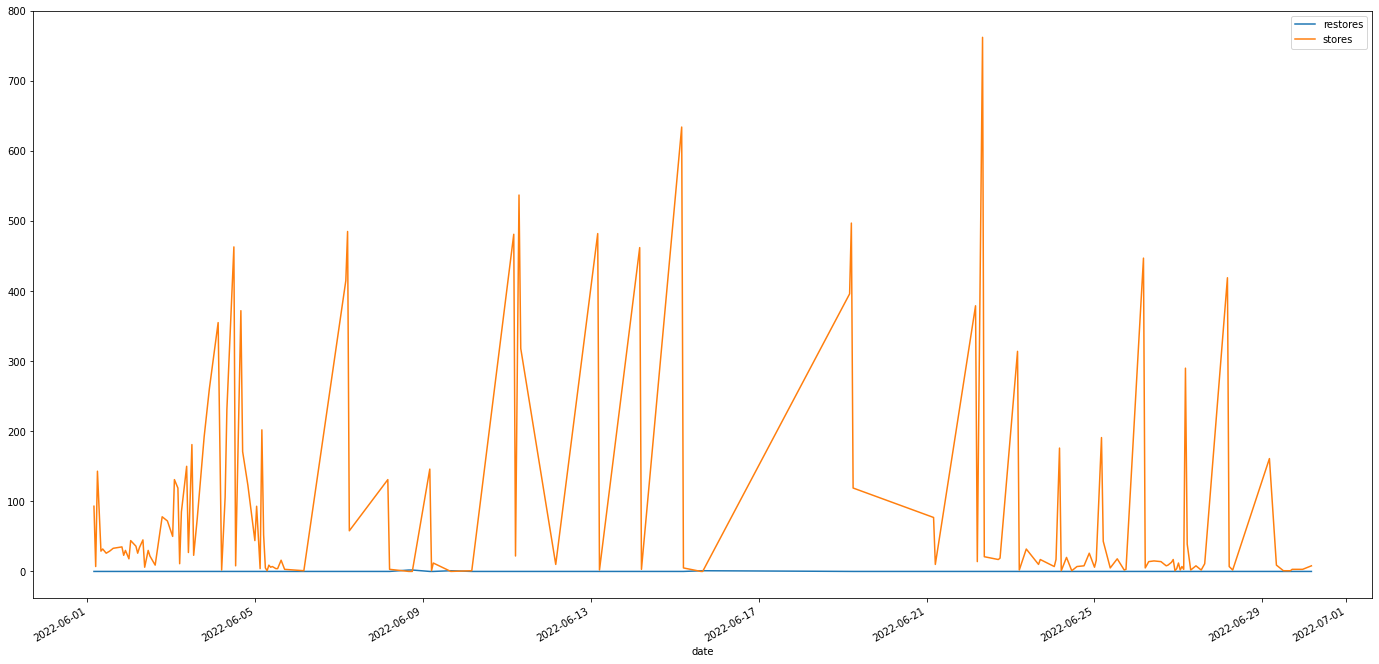

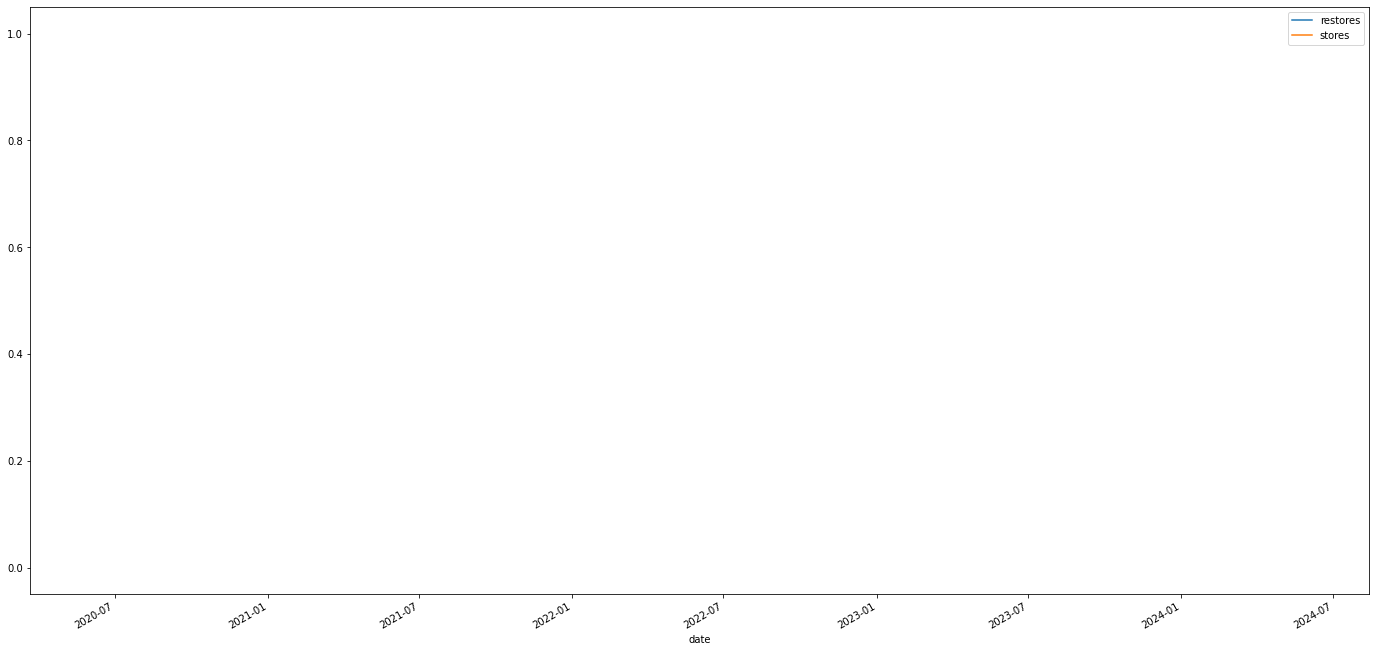

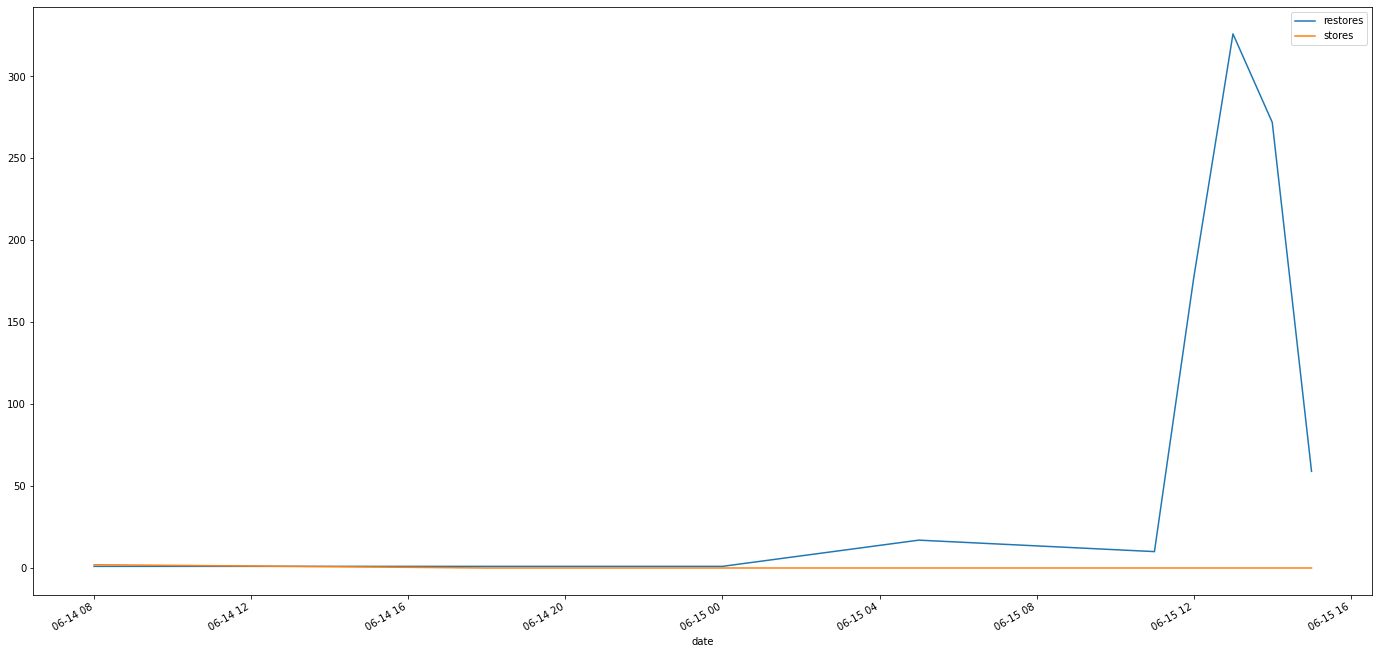

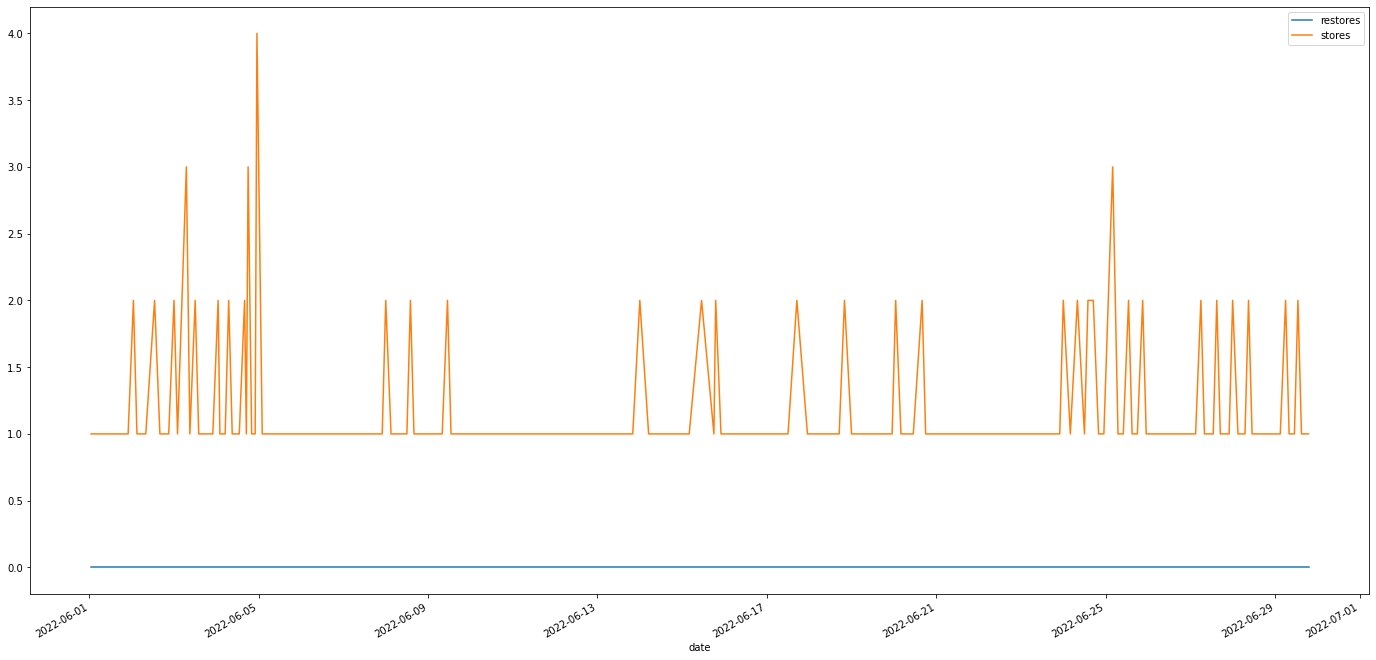

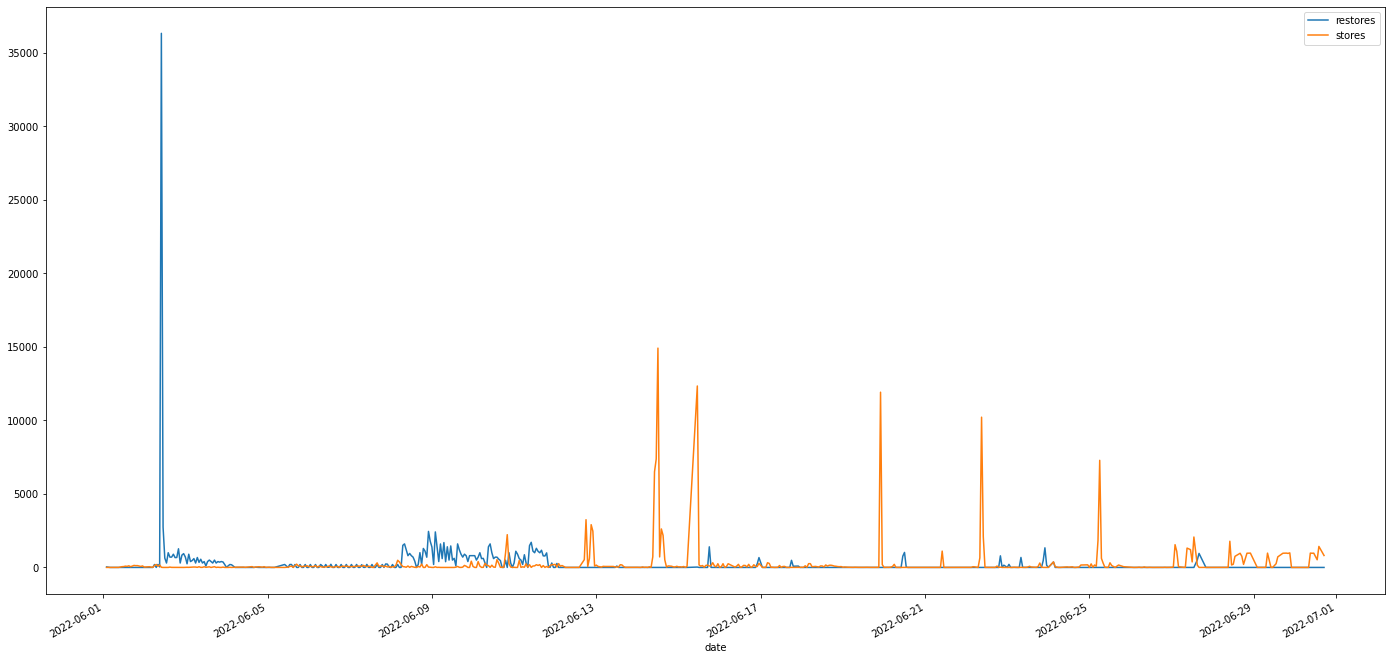

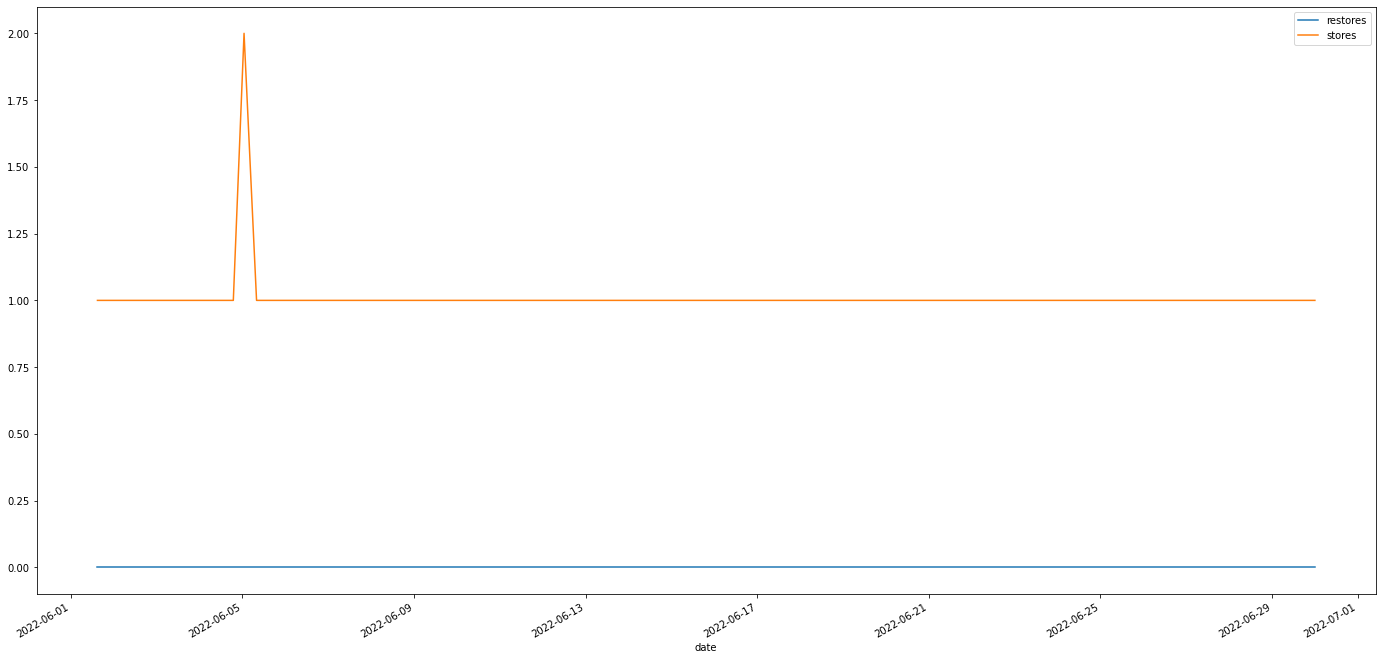

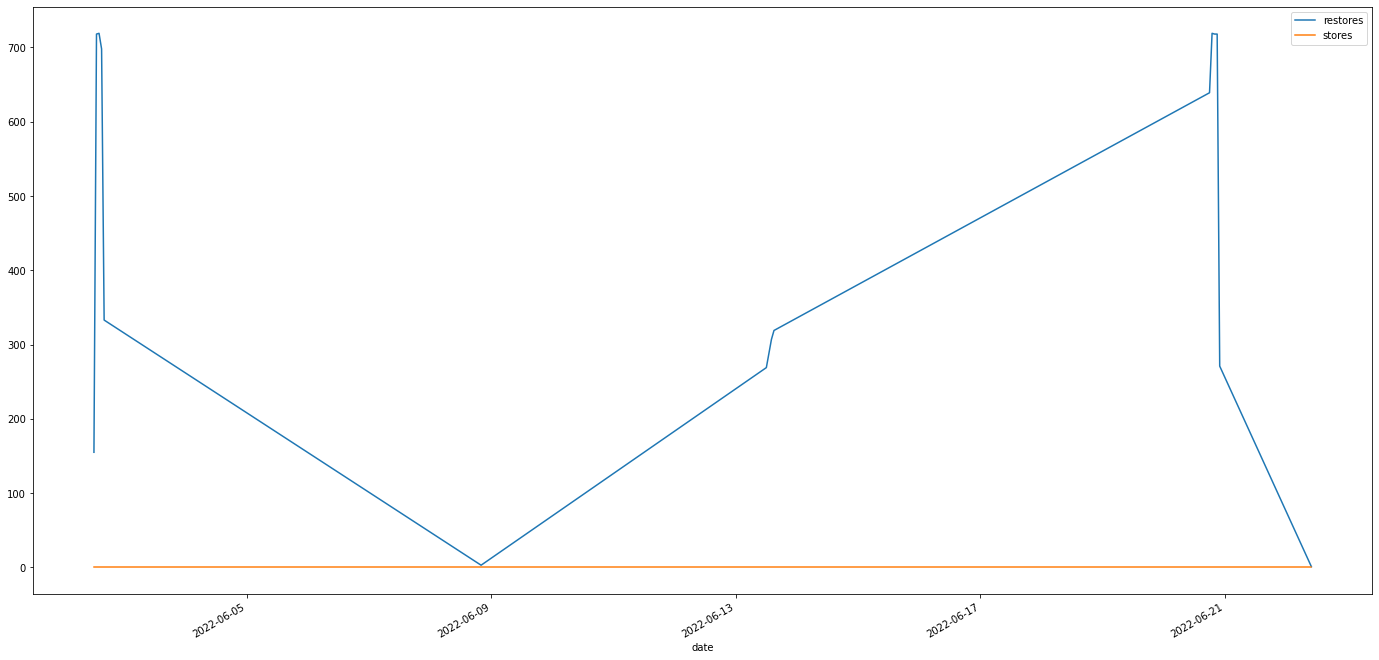

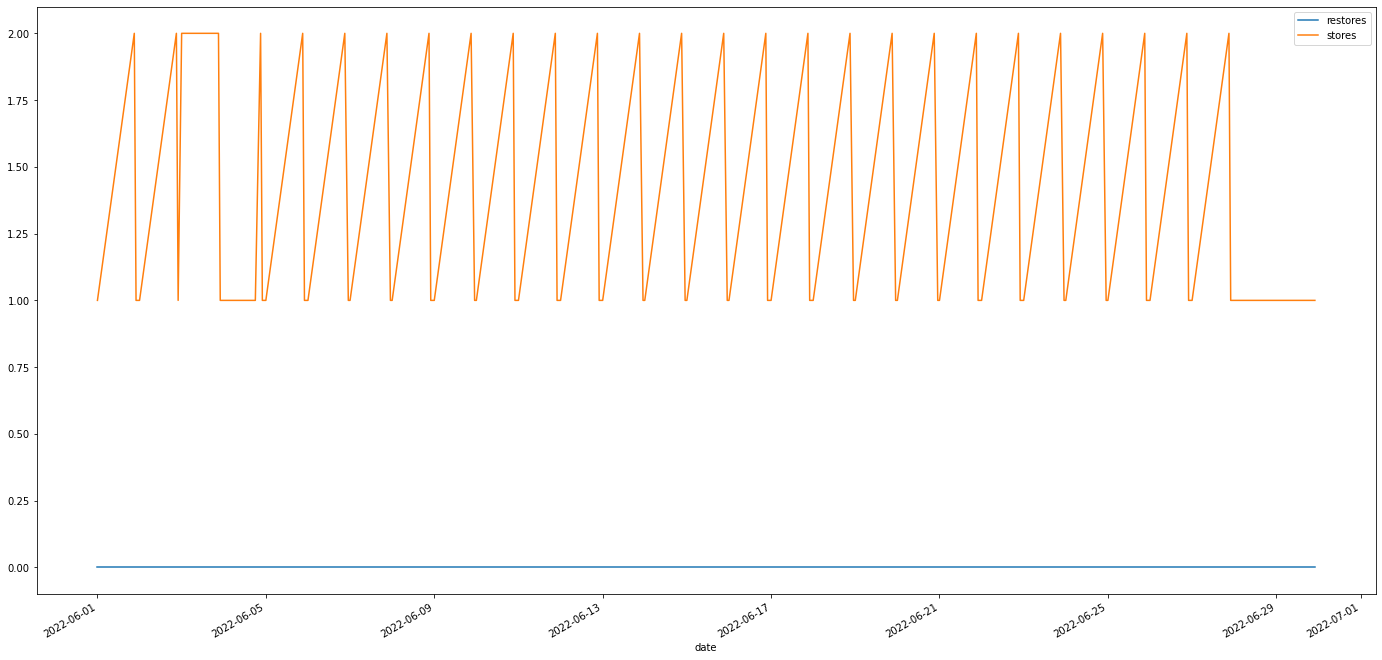

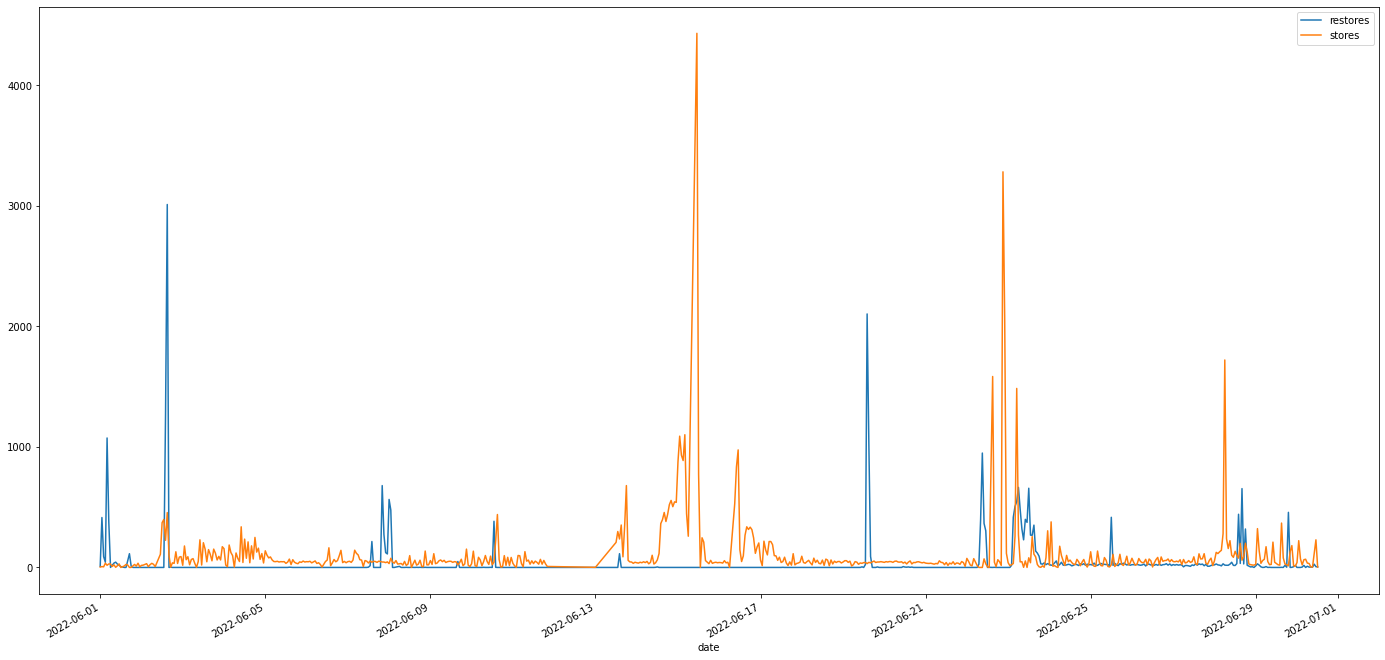

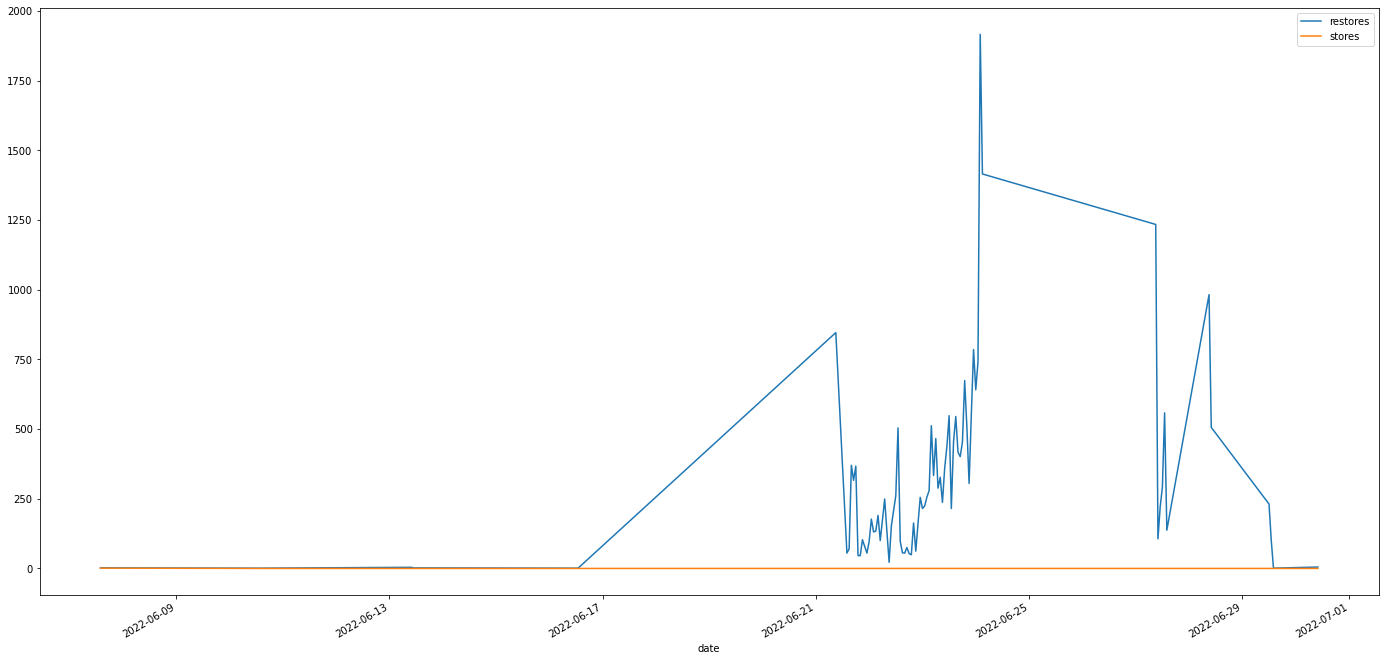

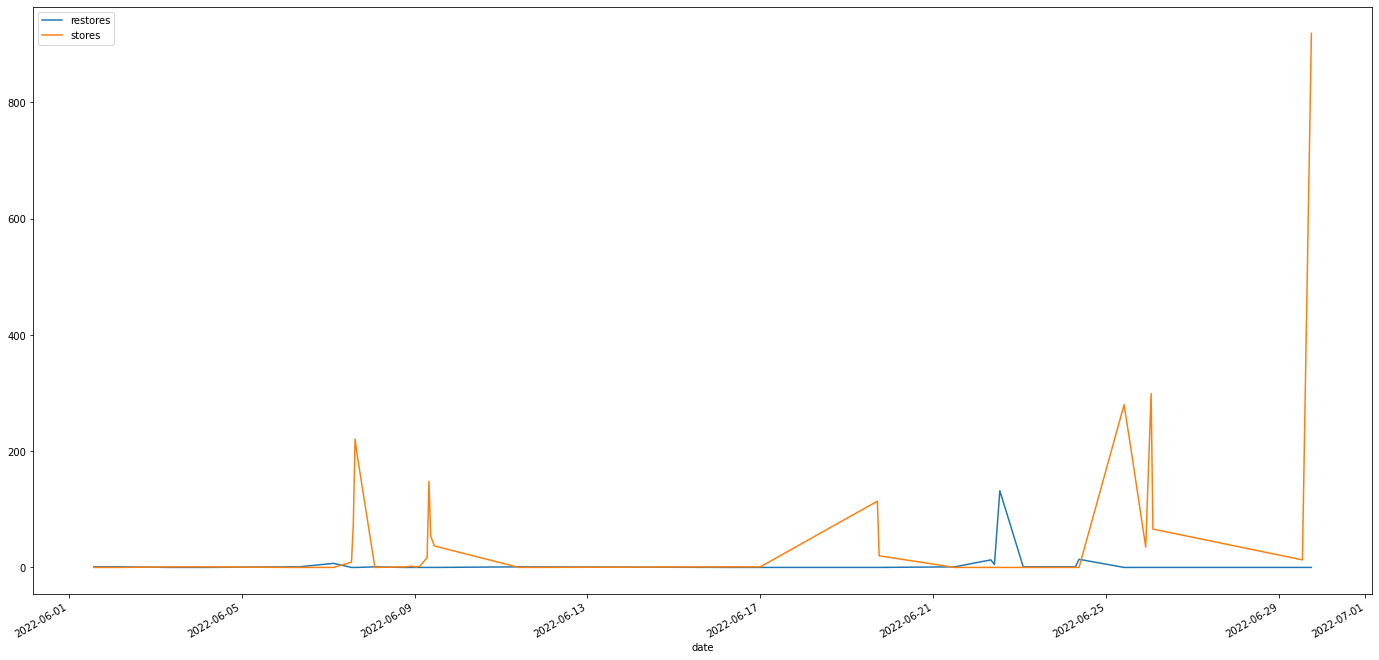

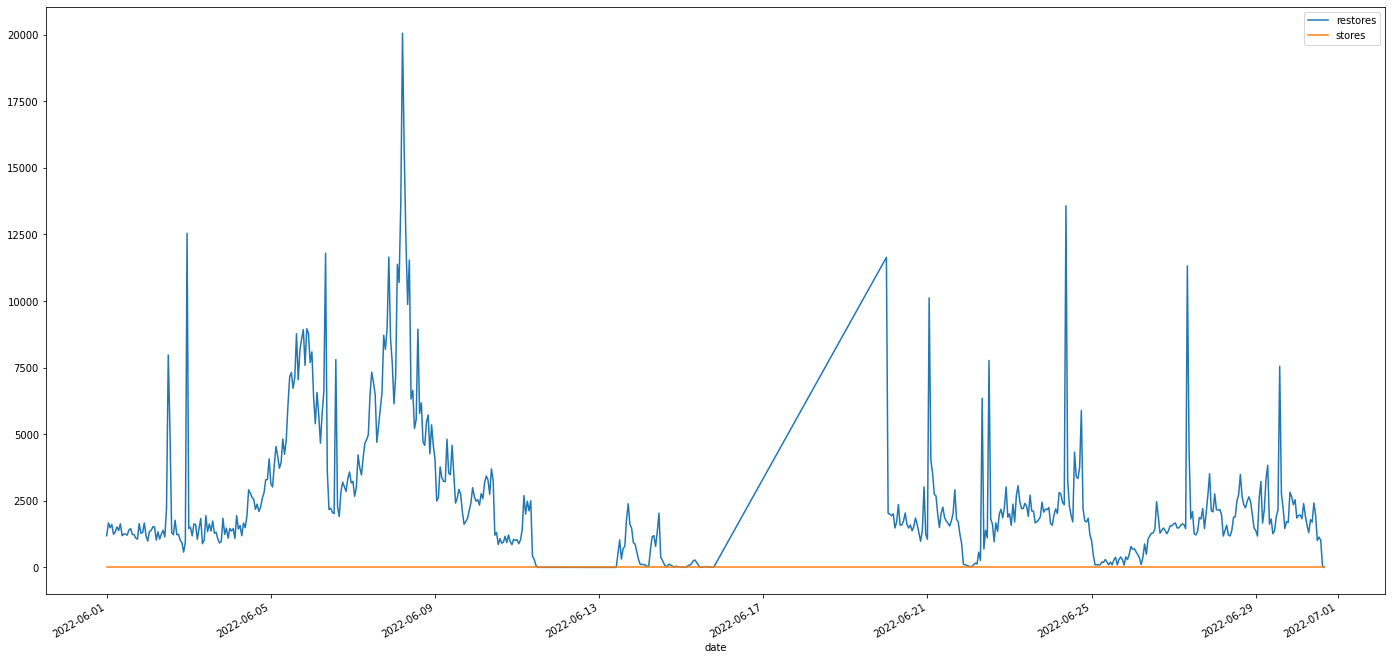

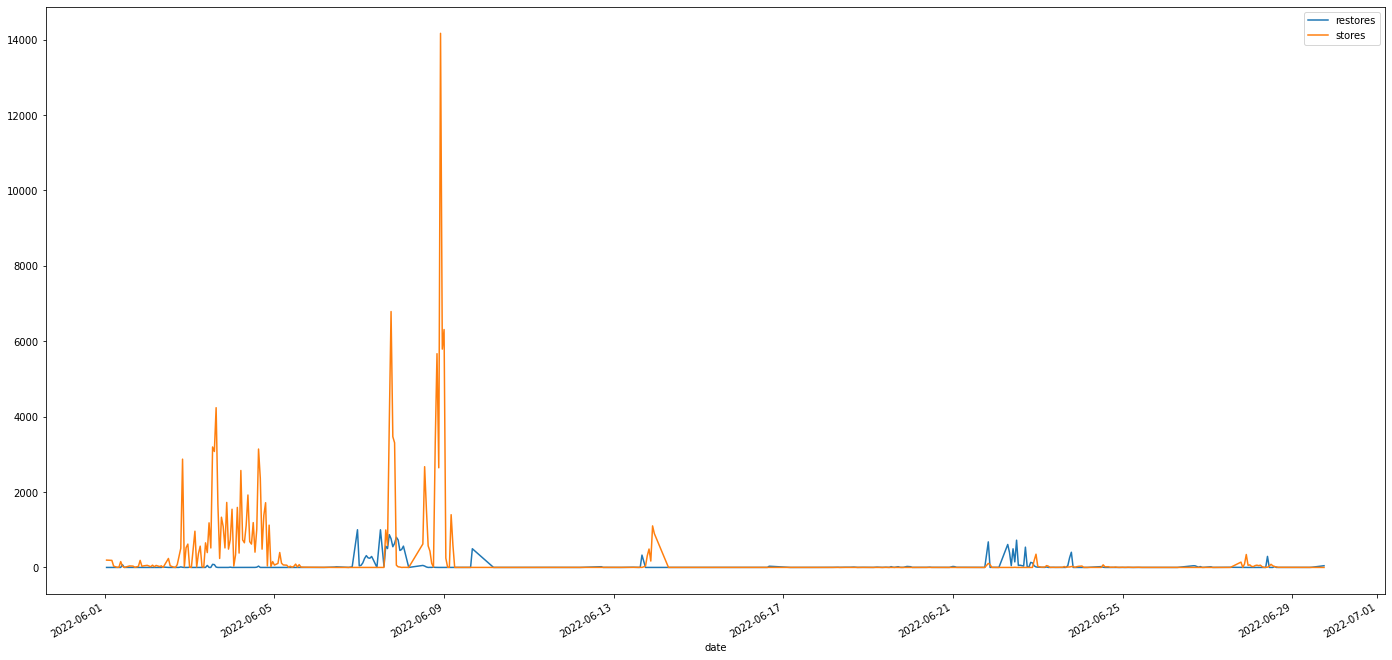

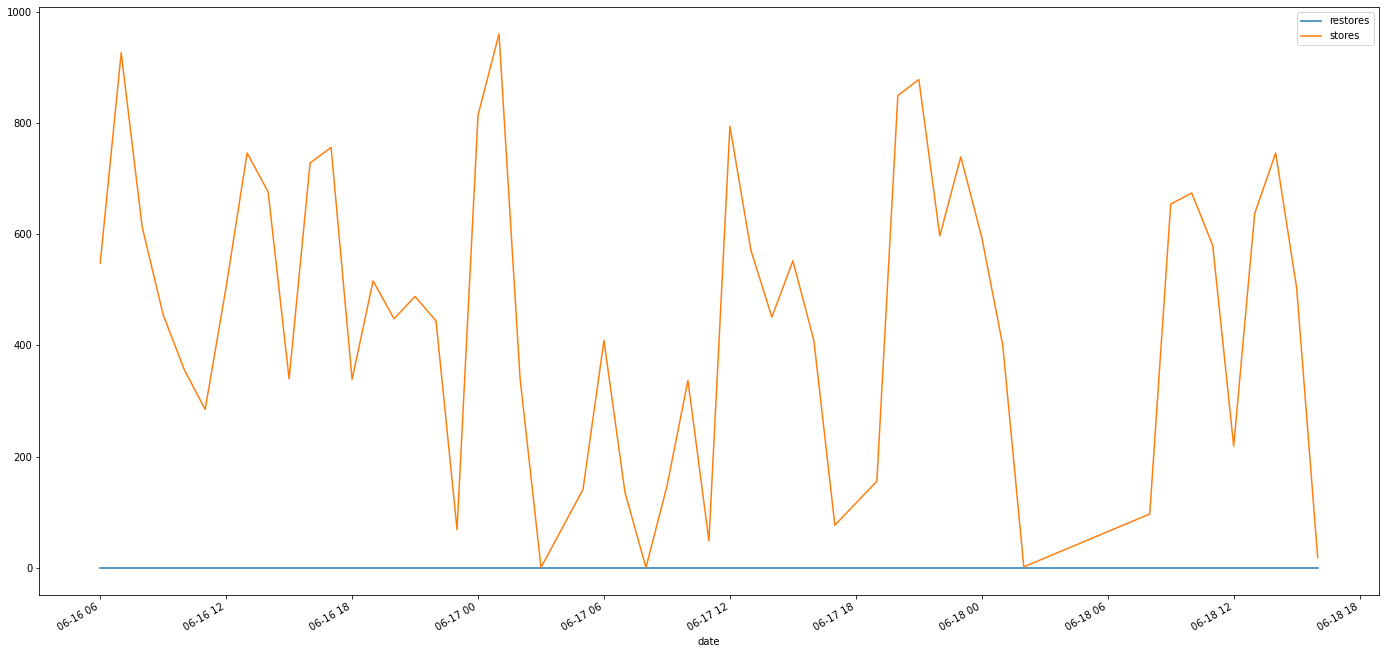

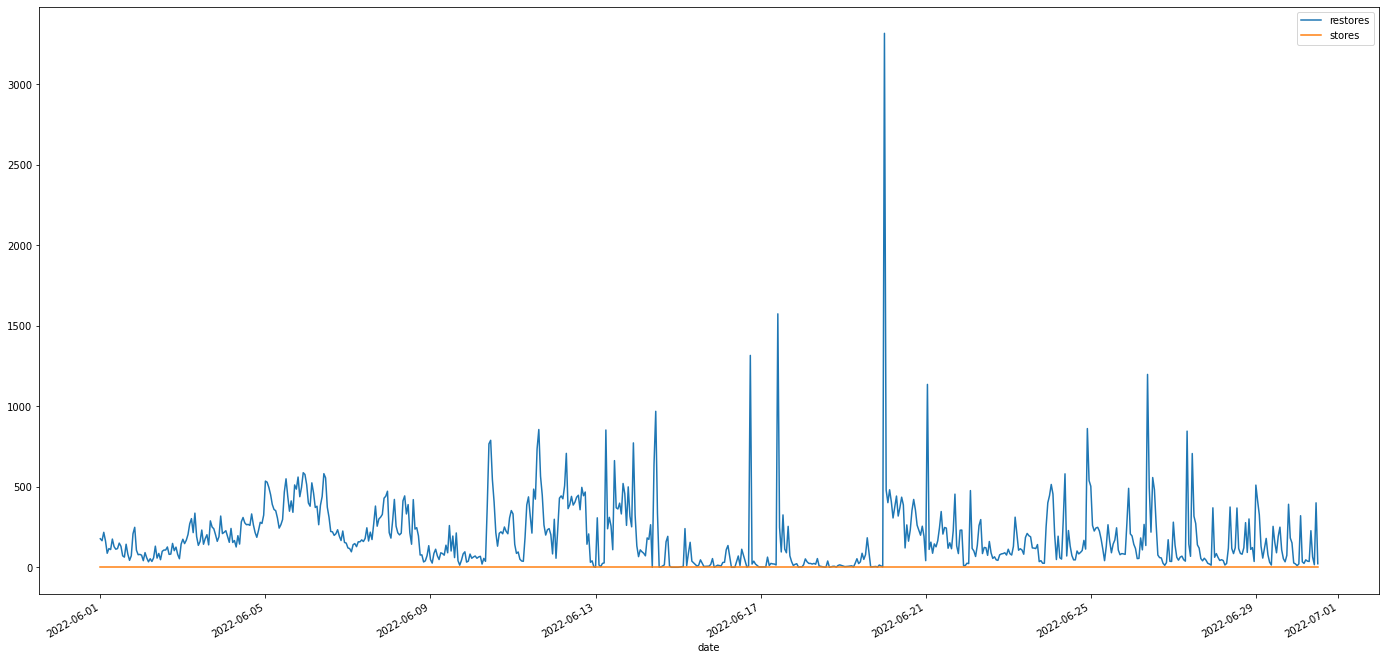

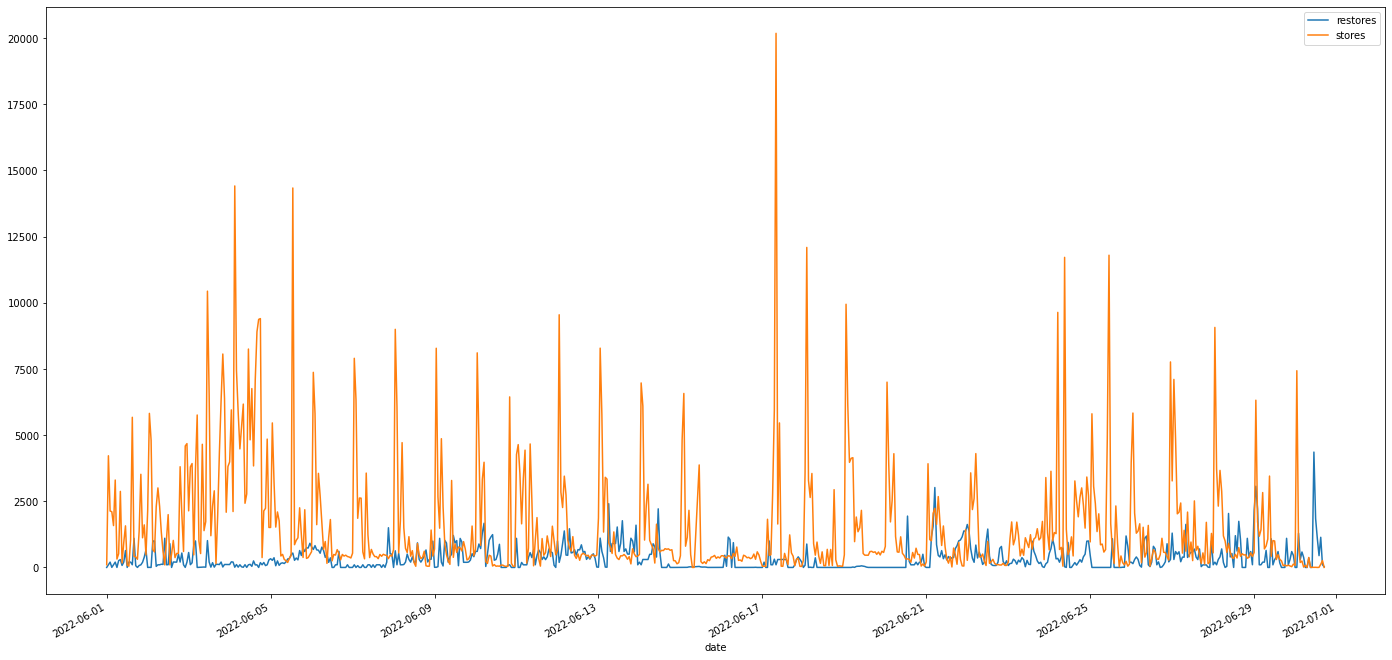

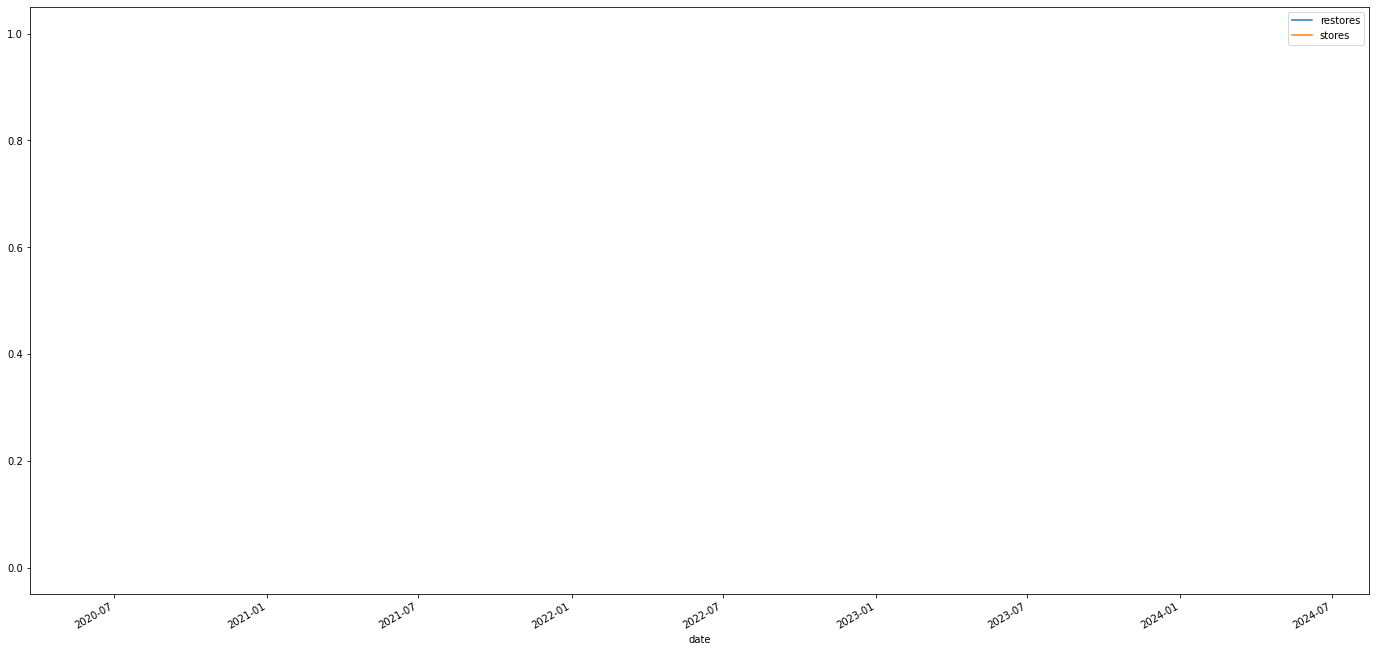

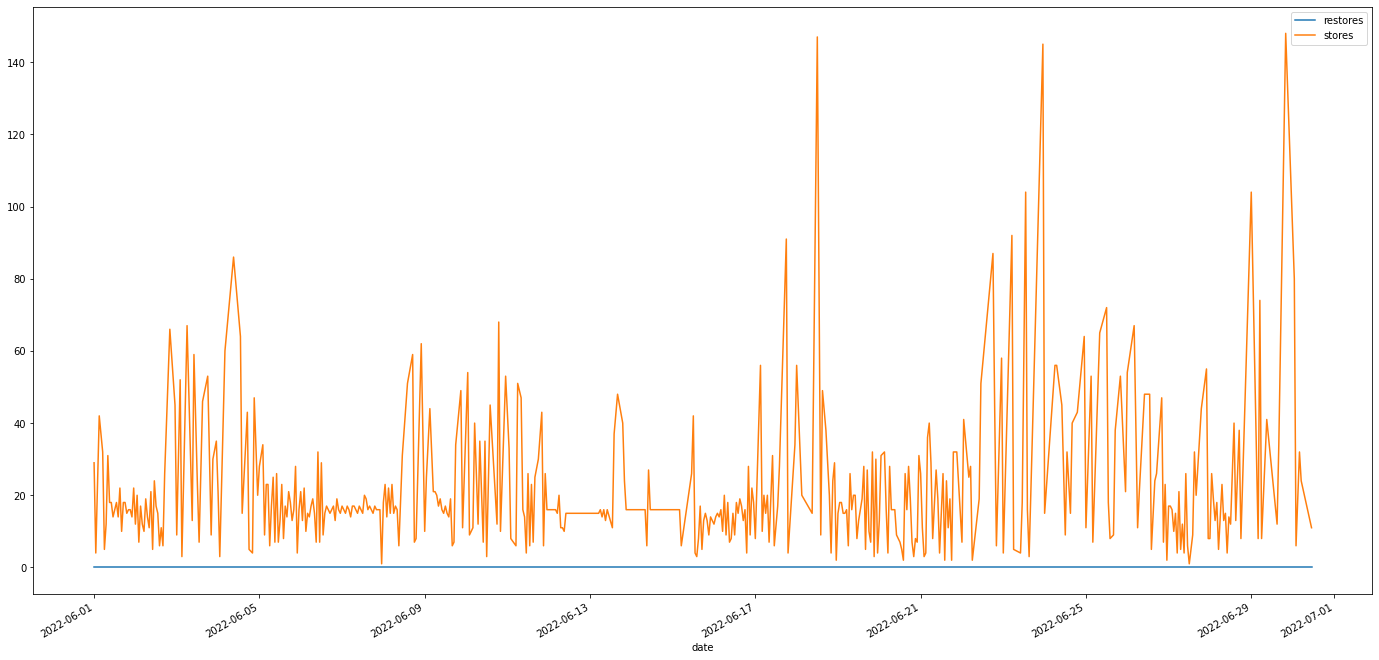

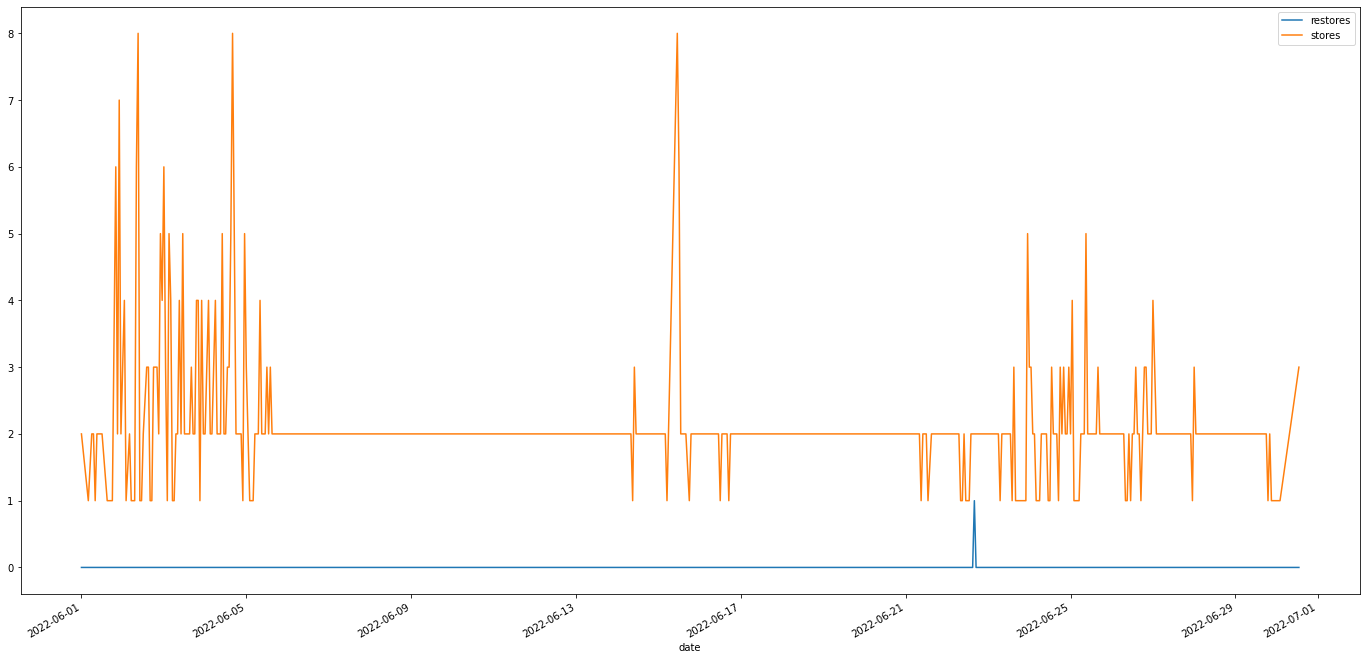

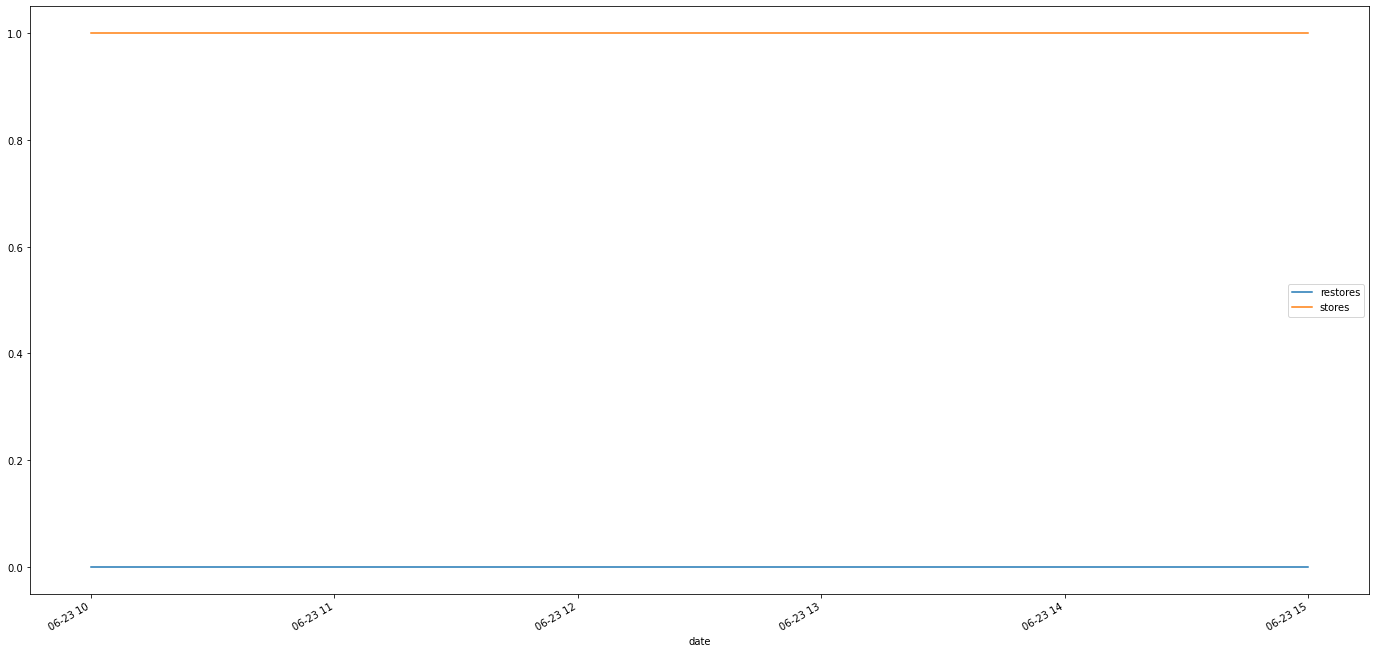

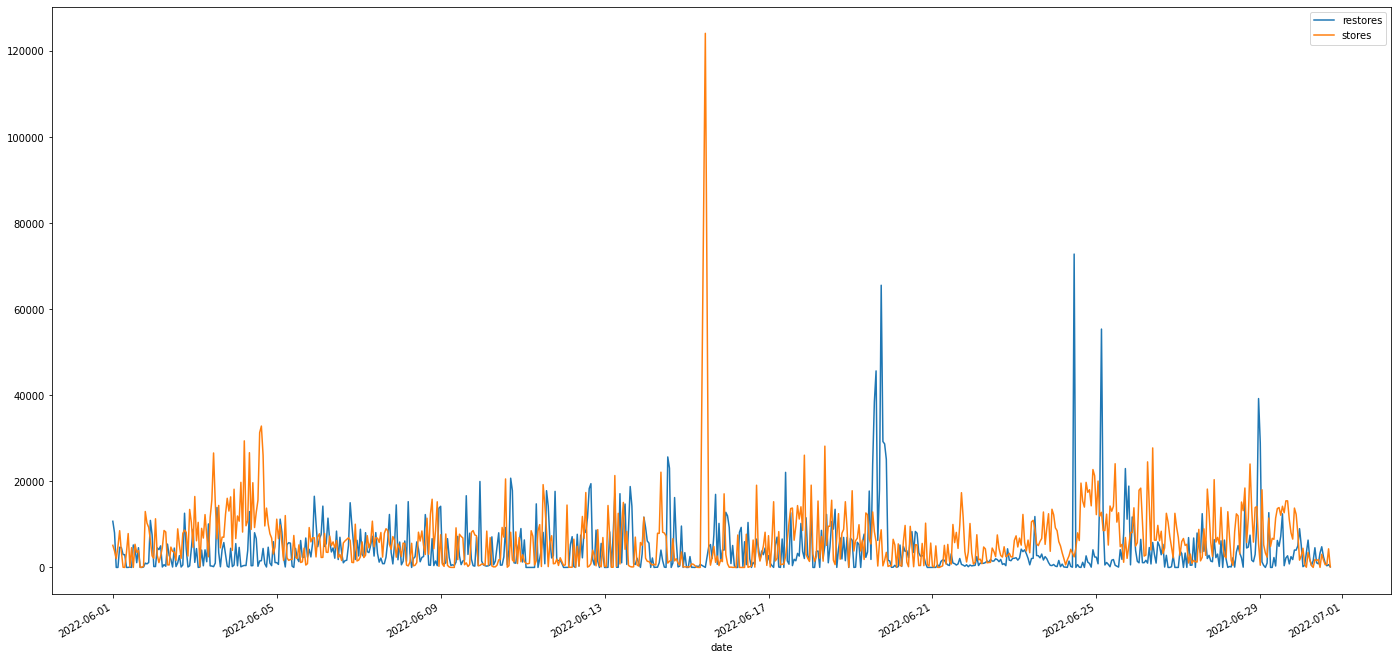

In [14]:
d3.groupby('vo').plot(x='date', figsize=(24,12))

<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

Text(179.875, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

Text(192.375, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

Text(186.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

Text(186.0, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'des'}, xlabel='date'>

Text(189.0, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

Text(173.5, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

Text(182.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

Text(186.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

Text(182.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

Text(179.875, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

Text(179.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

Text(186.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

Text(173.375, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

Text(173.5, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'next'}, xlabel='date'>

Text(179.875, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'none'}, xlabel='date'>

Text(179.75, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

Text(173.375, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

Text(186.0, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'test'}, xlabel='date'>

Text(198.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

Text(167.25, 0.5, 'number of daily stores/restores')

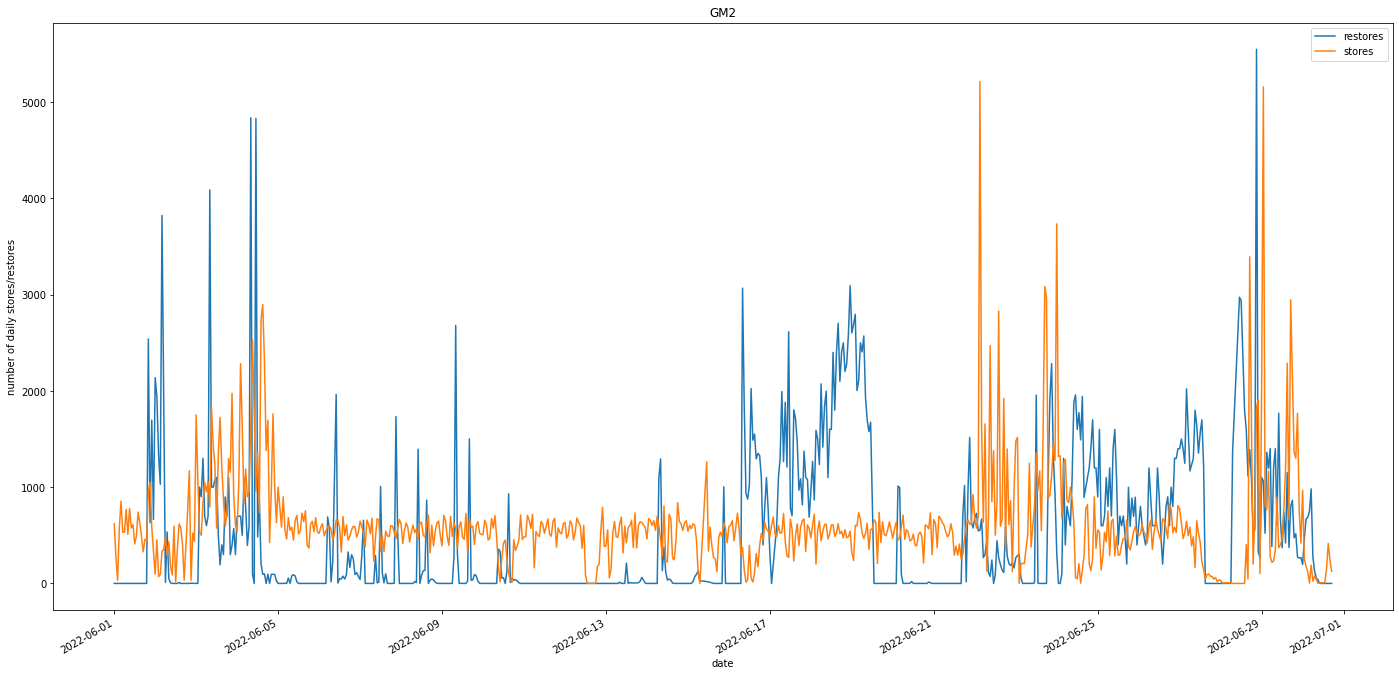

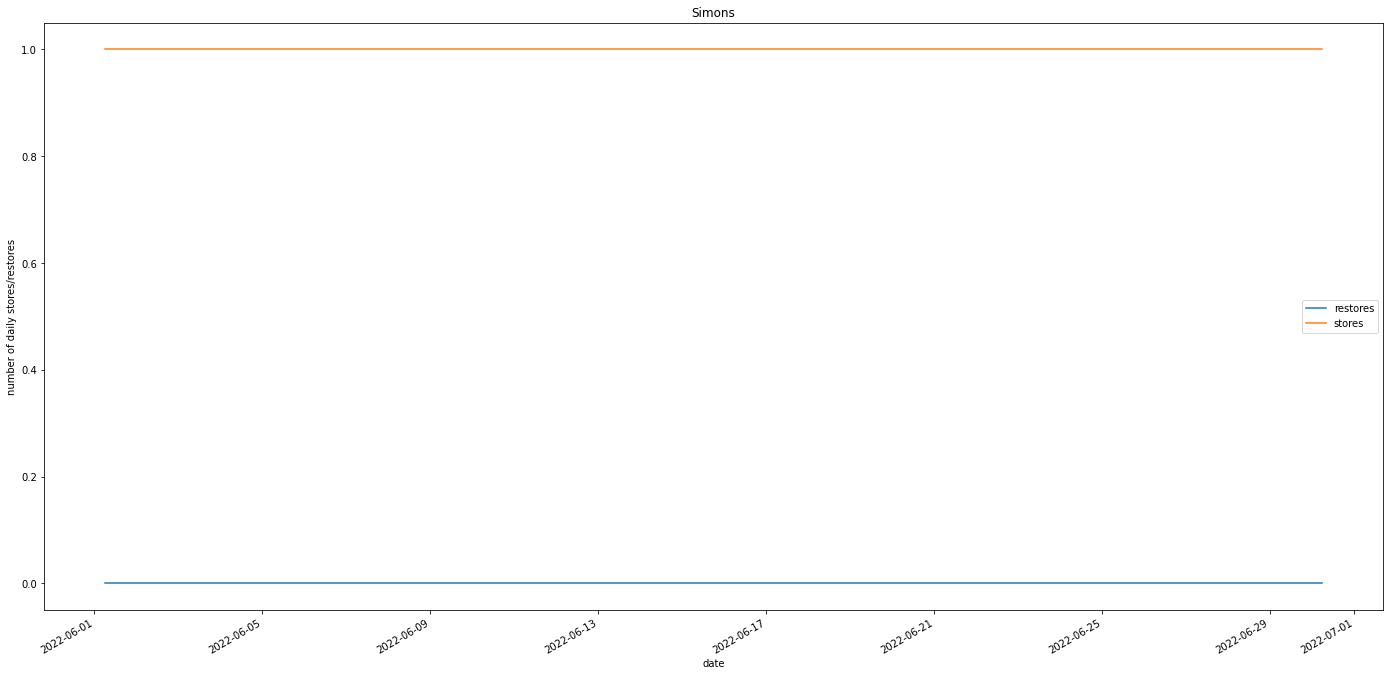

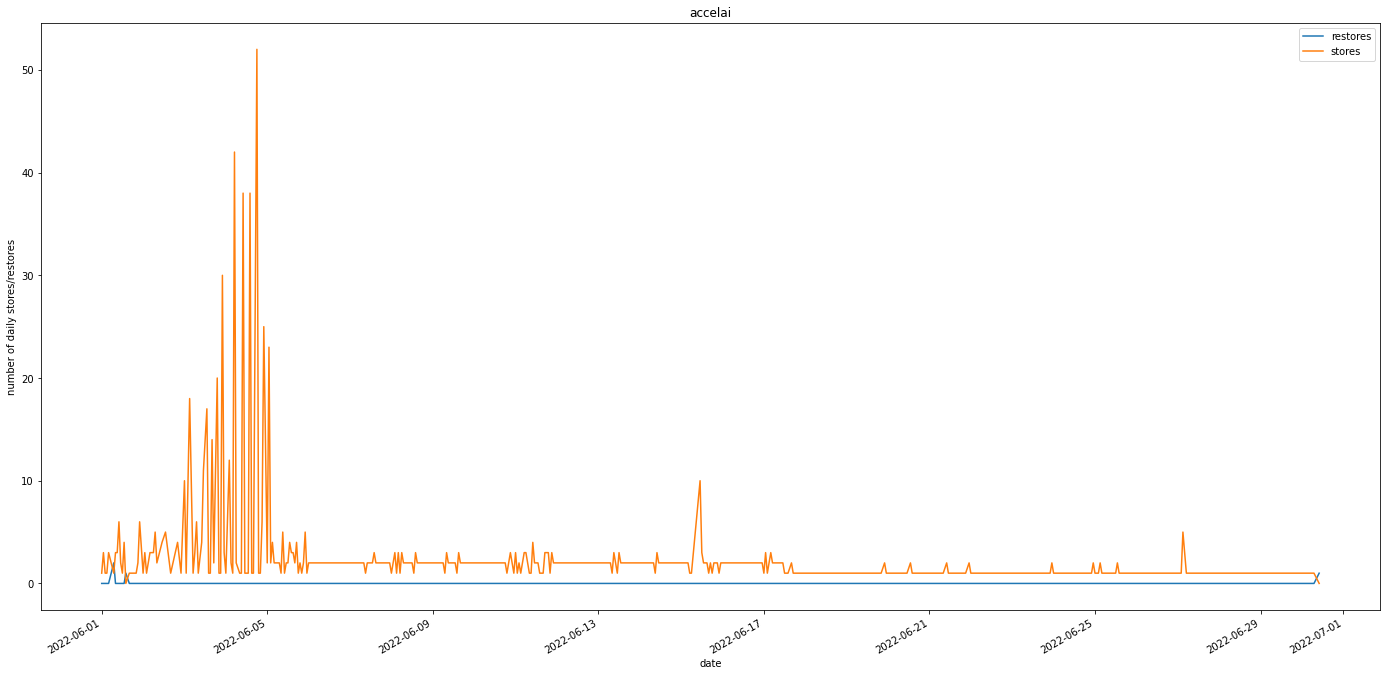

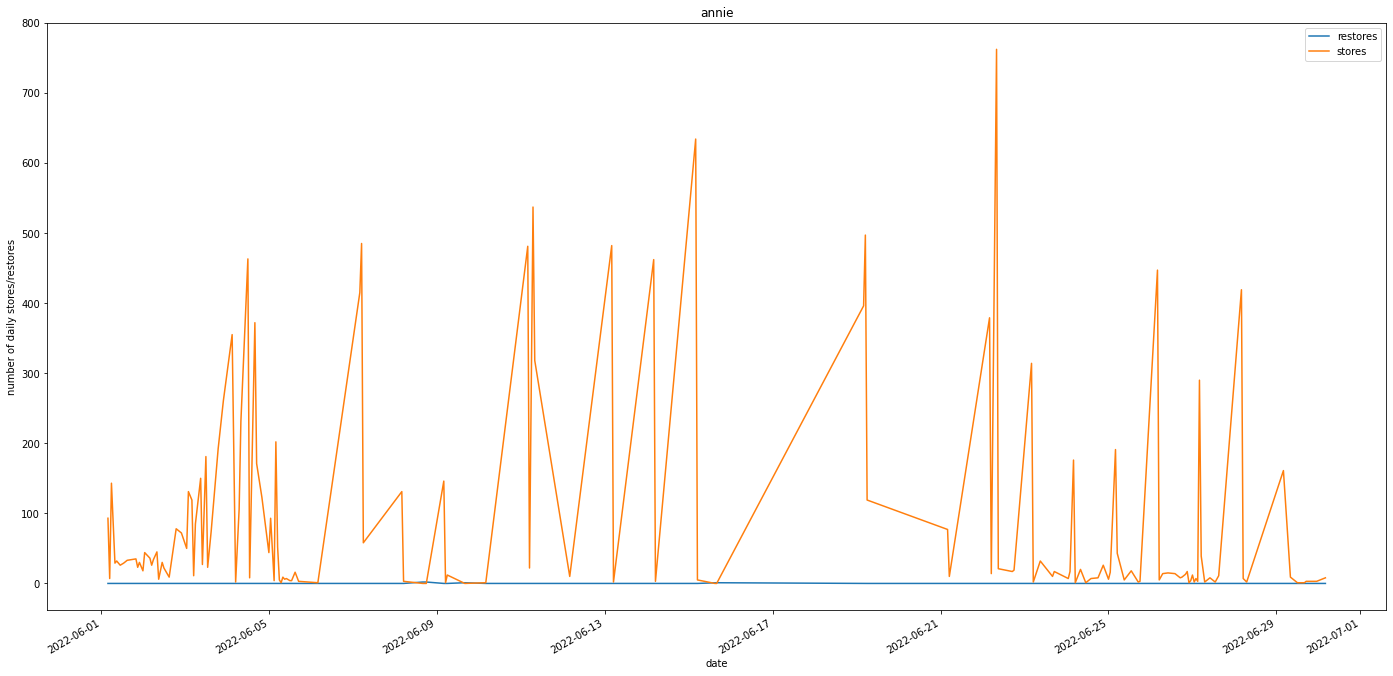

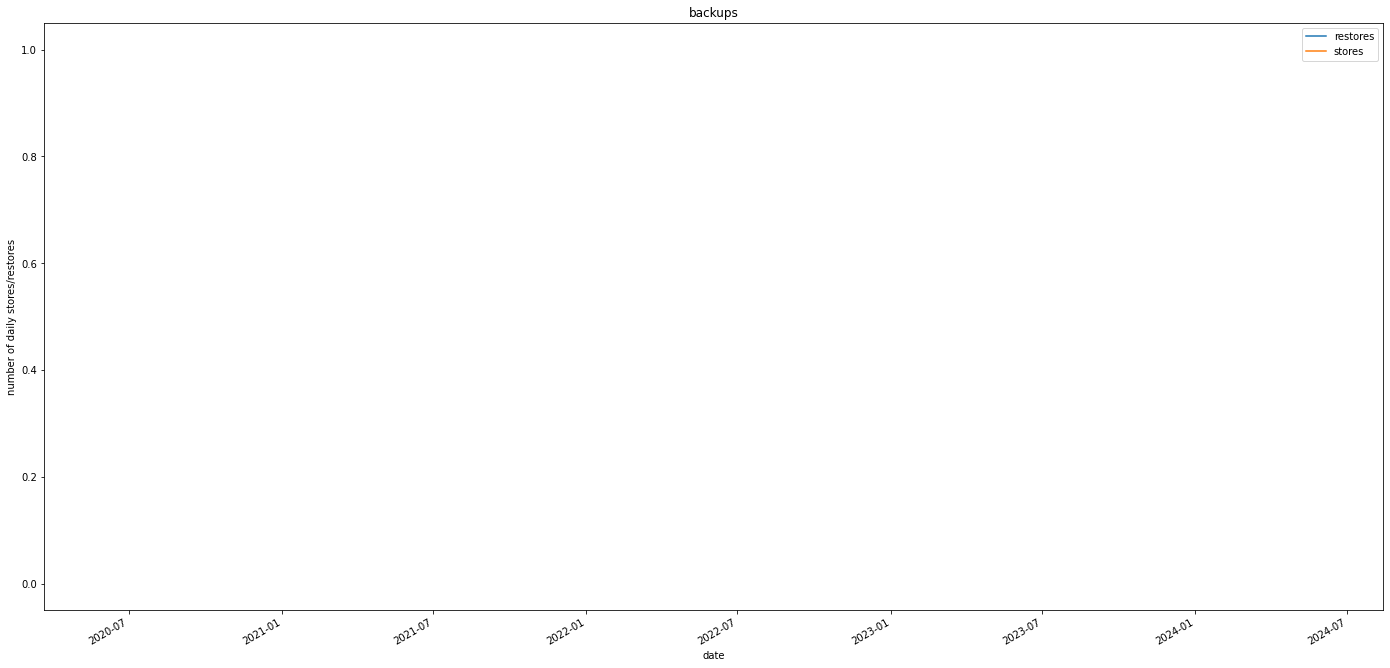

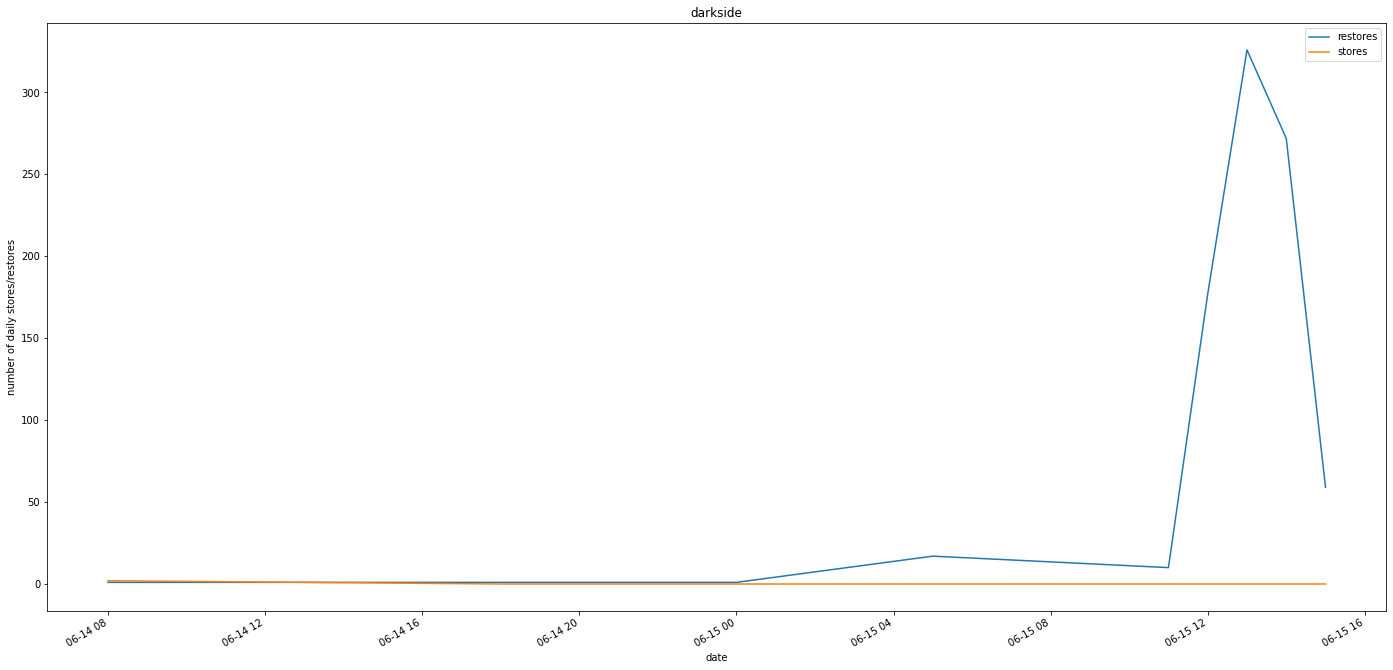

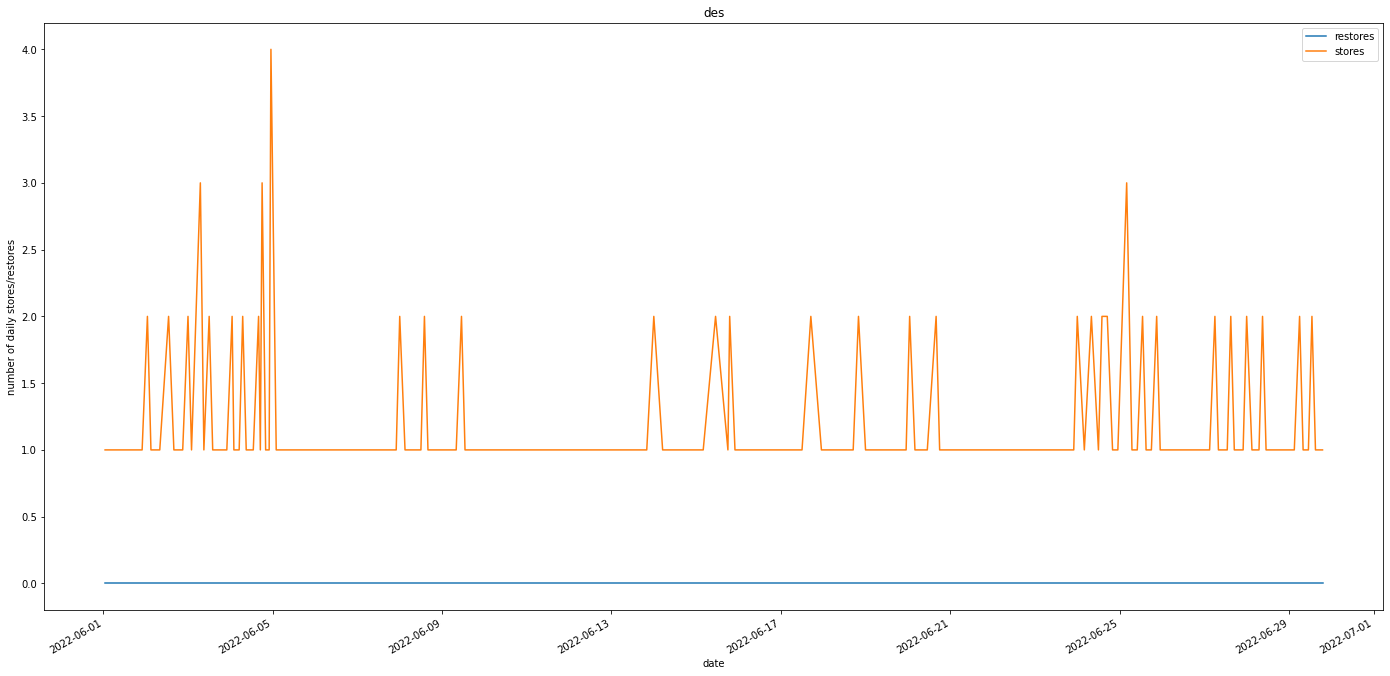

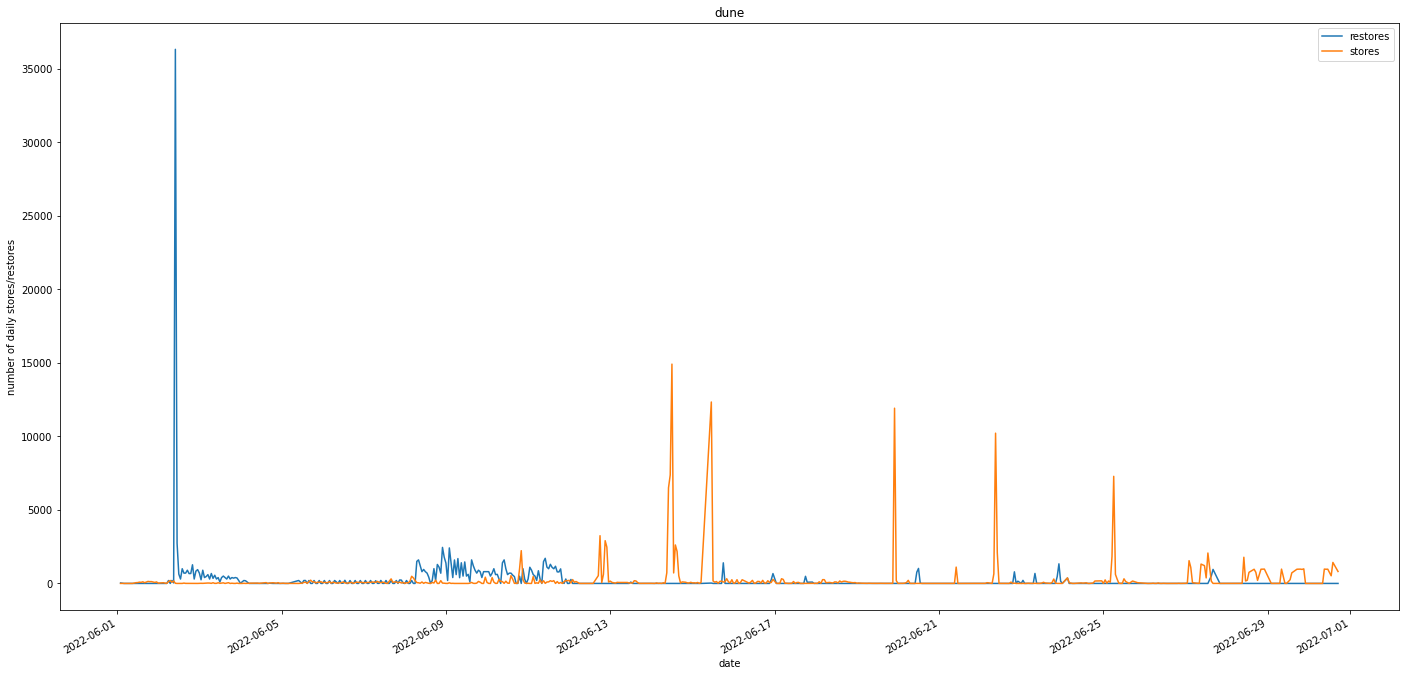

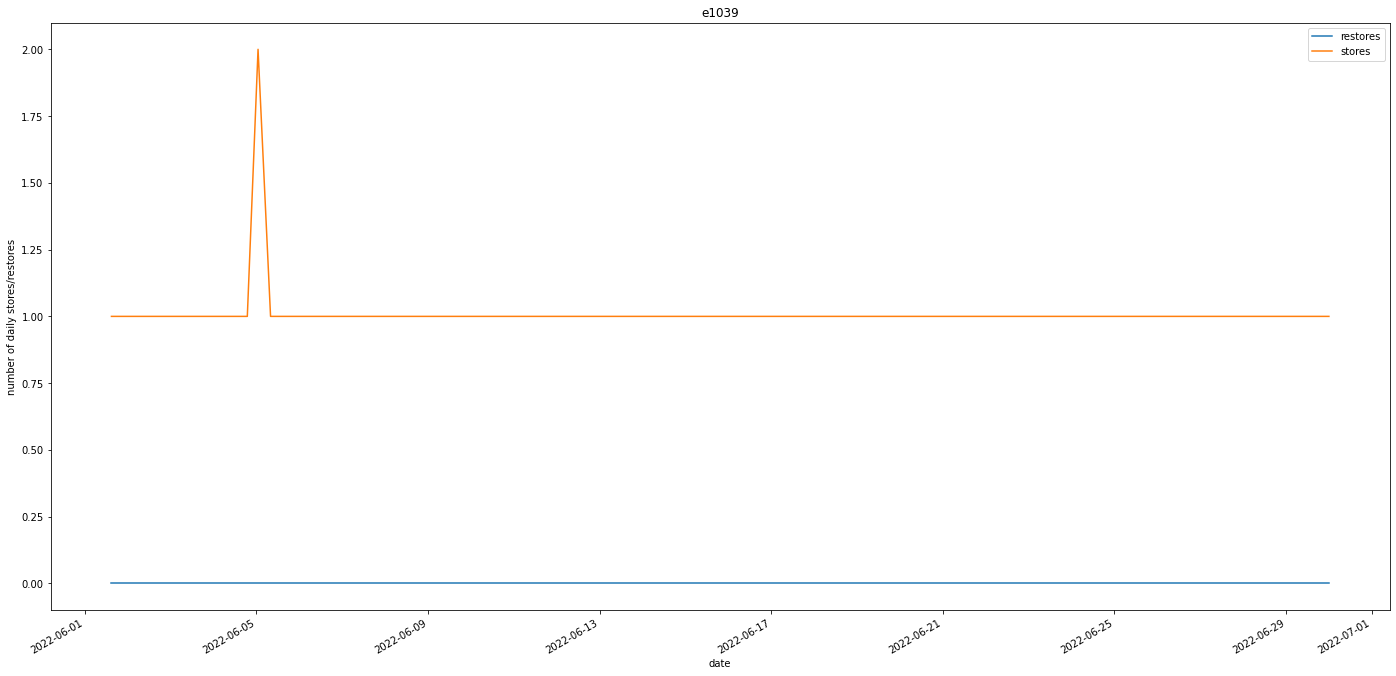

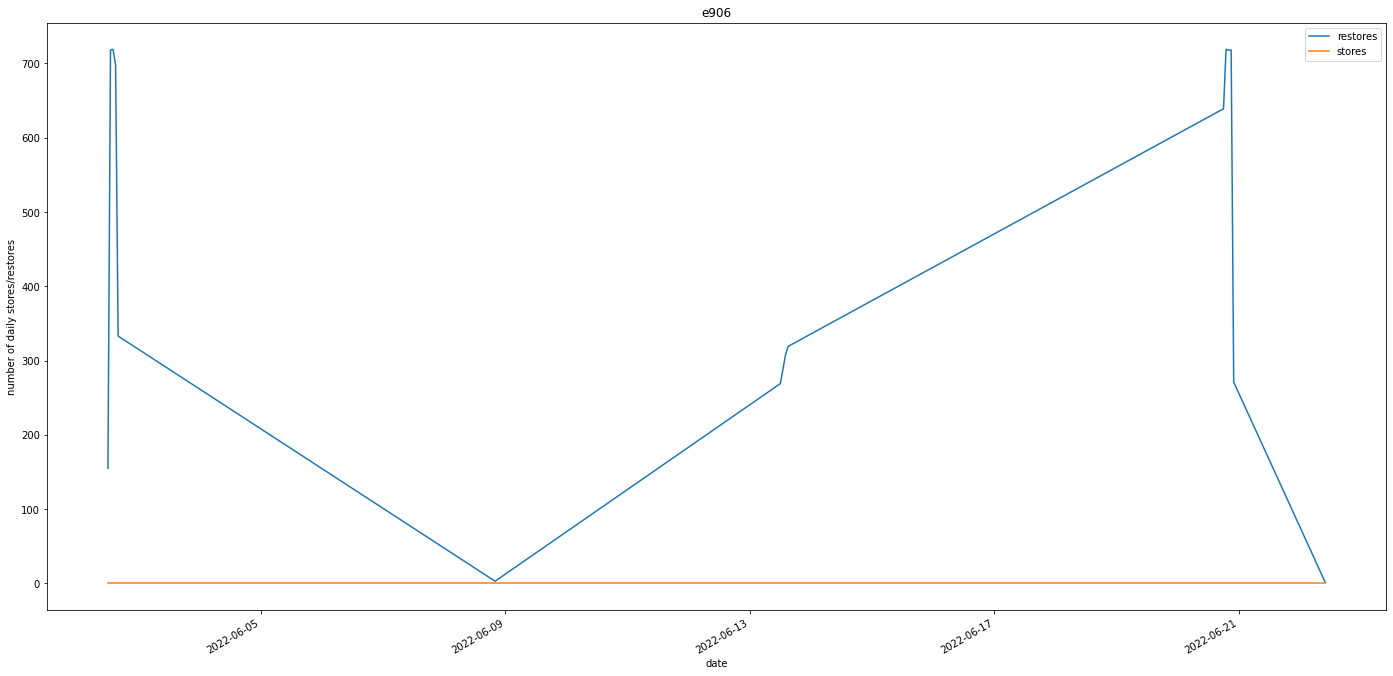

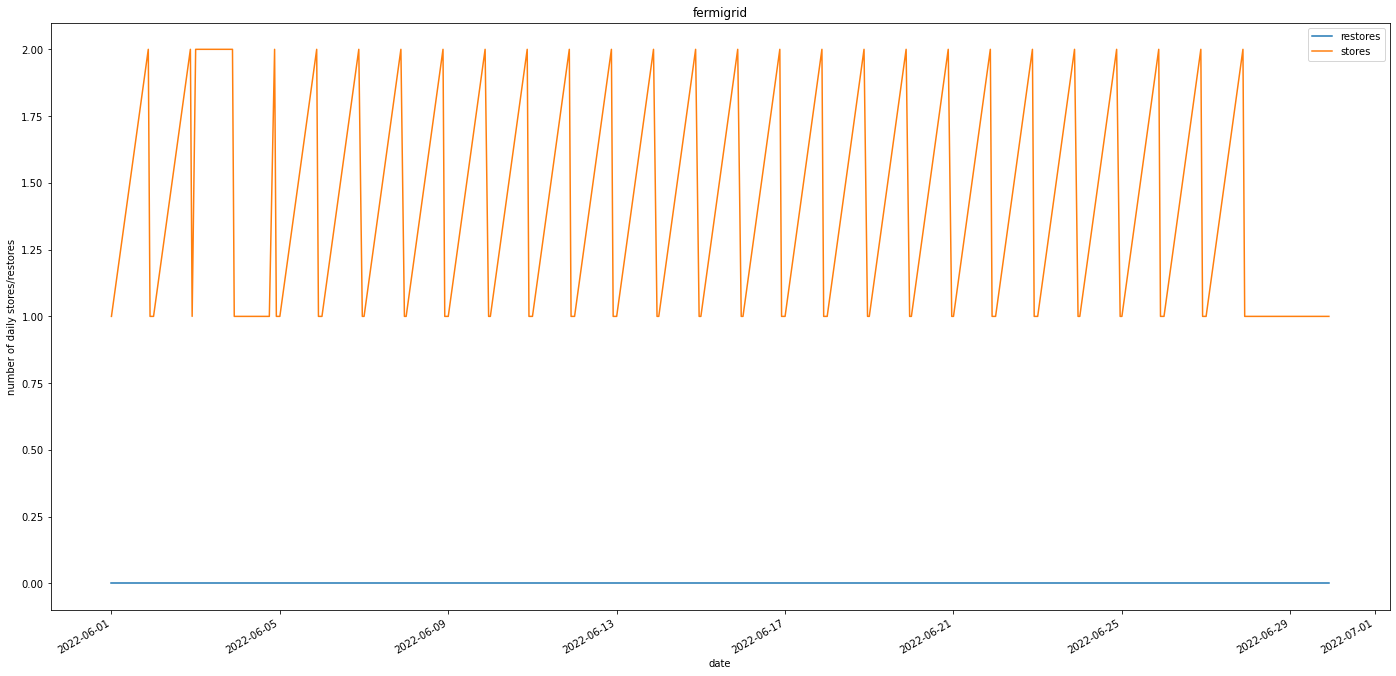

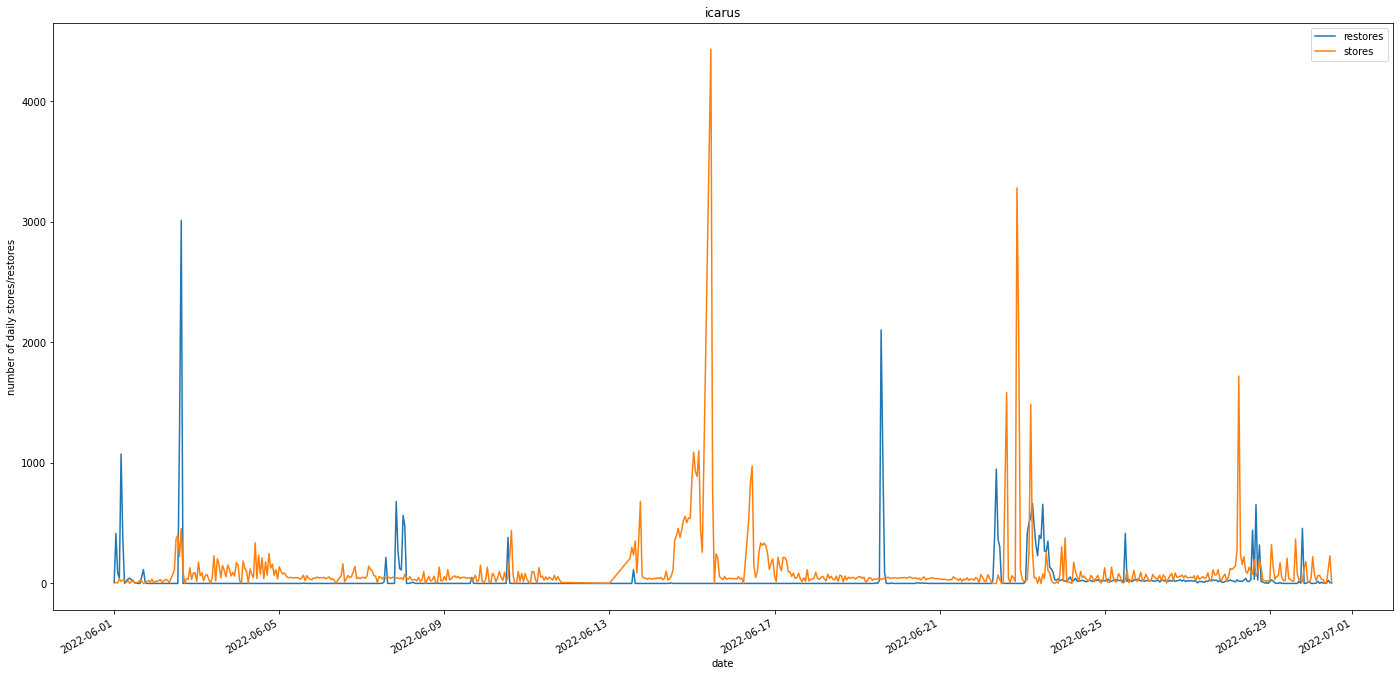

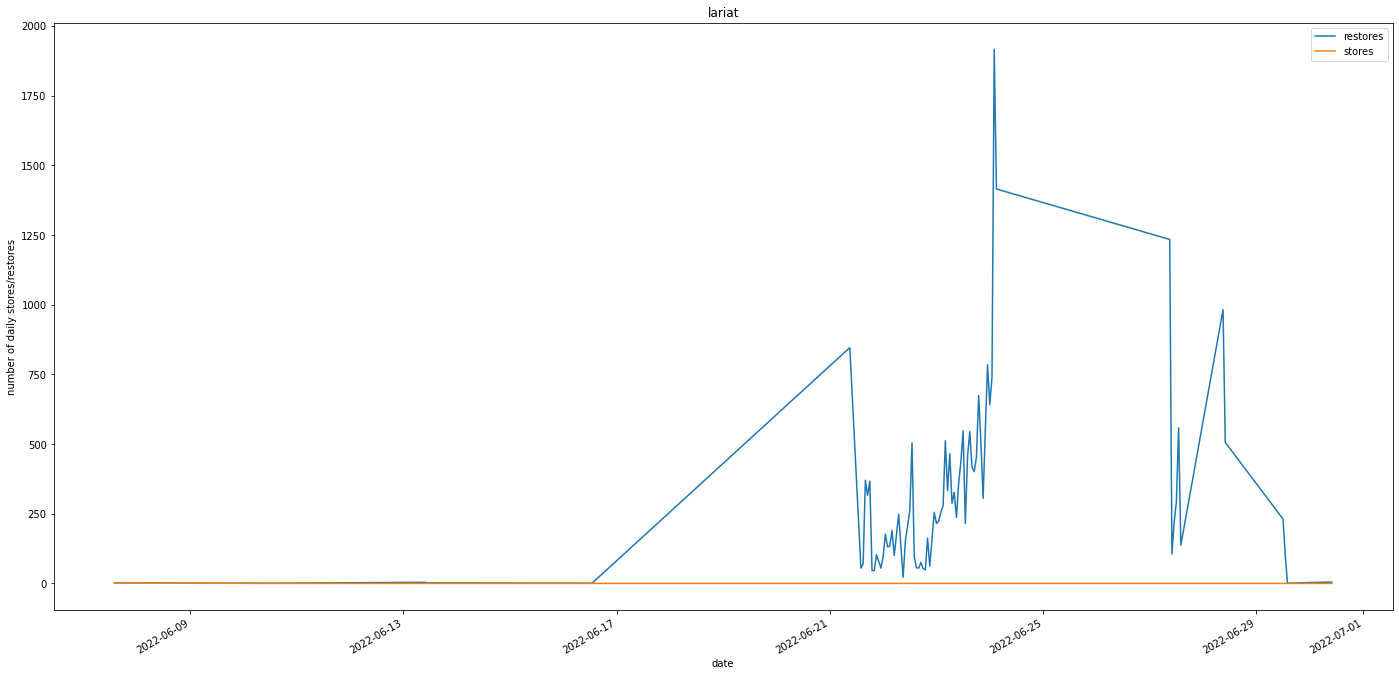

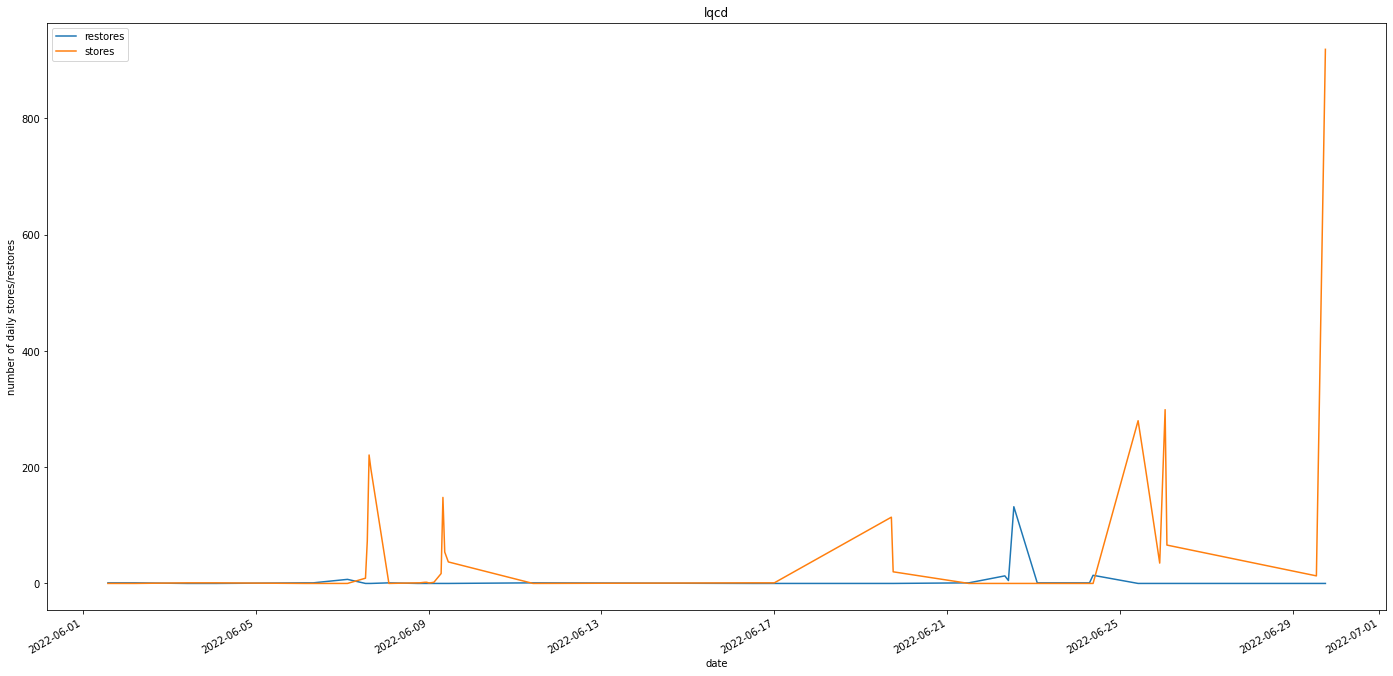

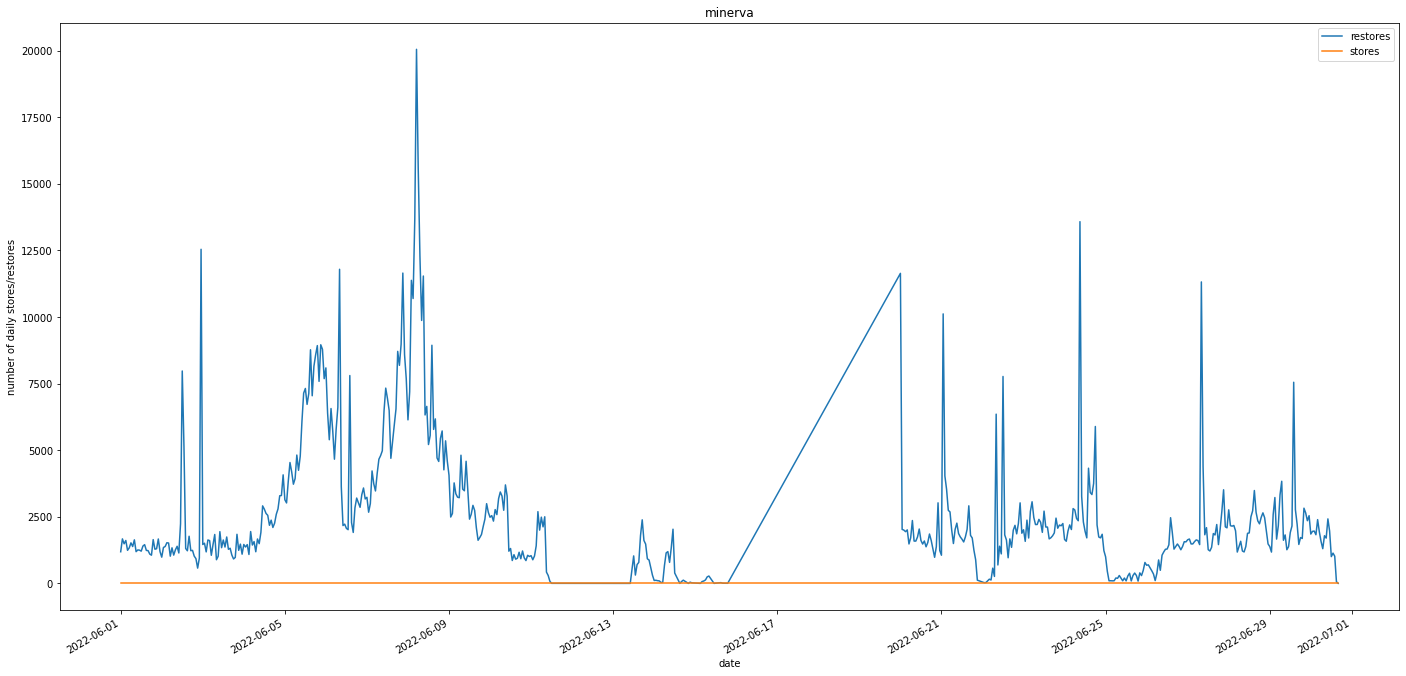

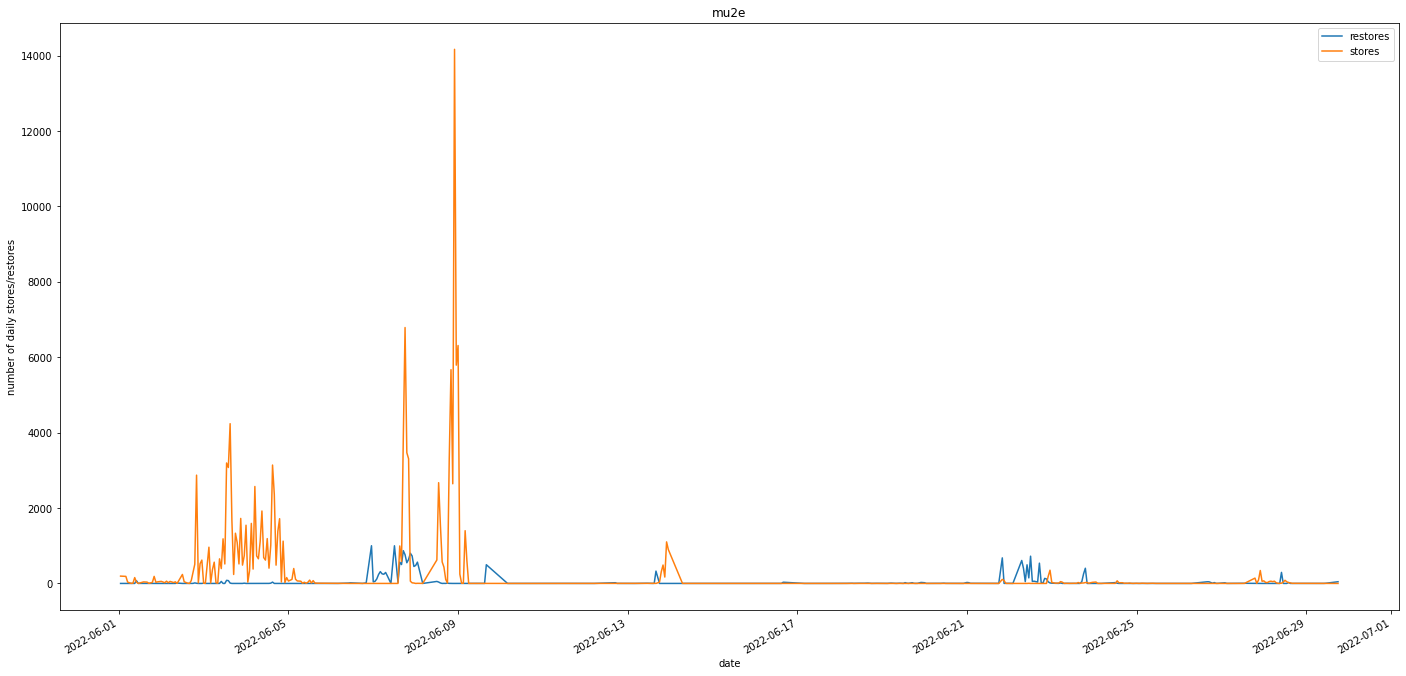

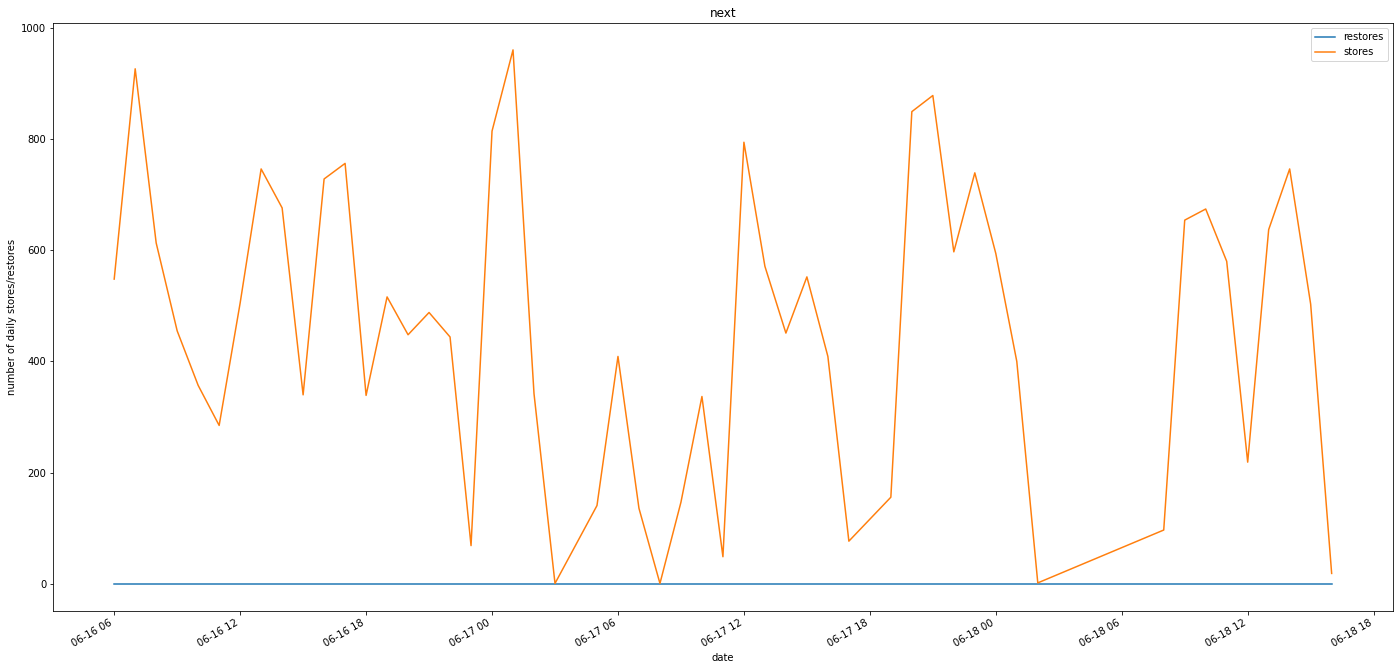

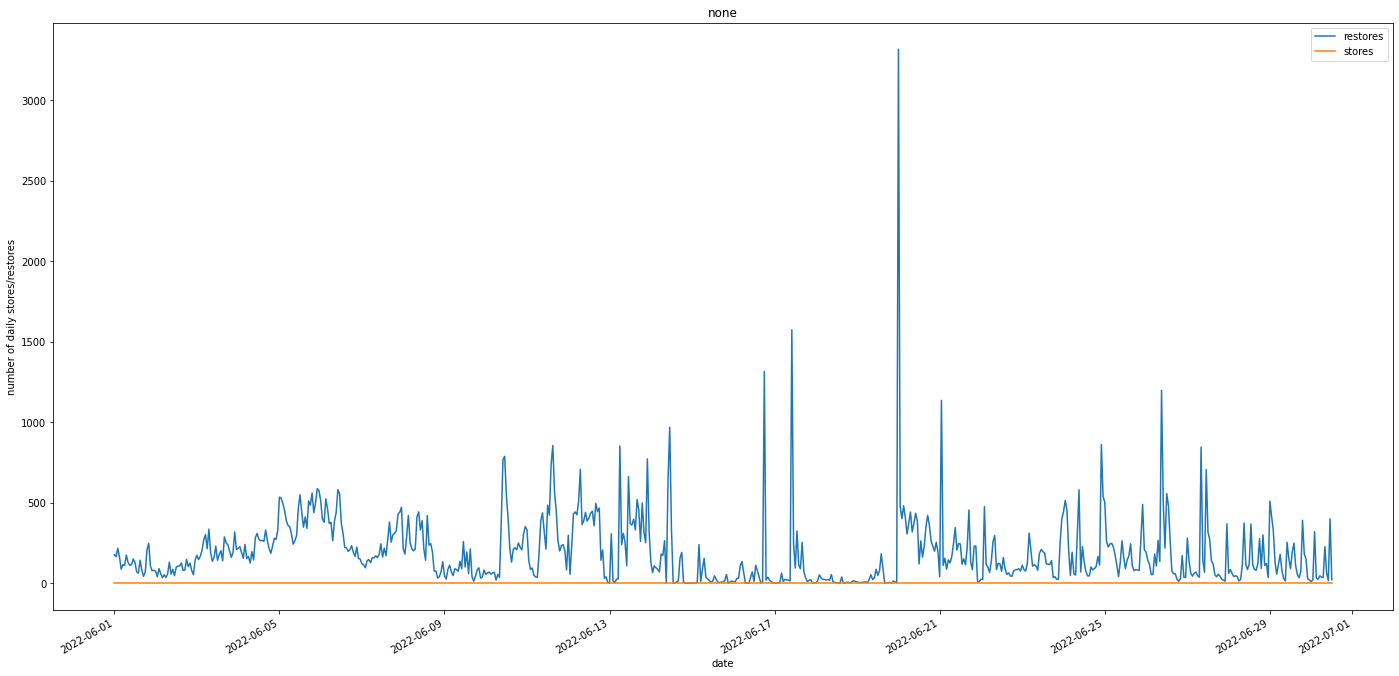

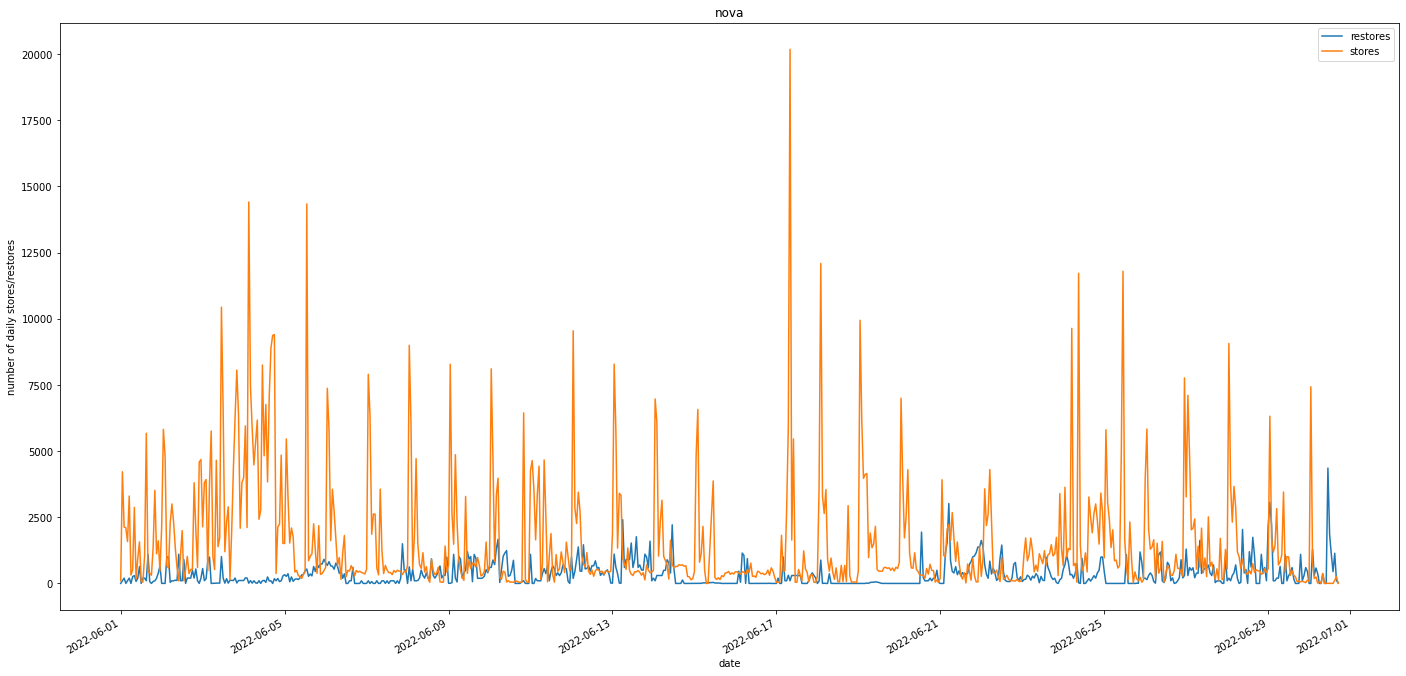

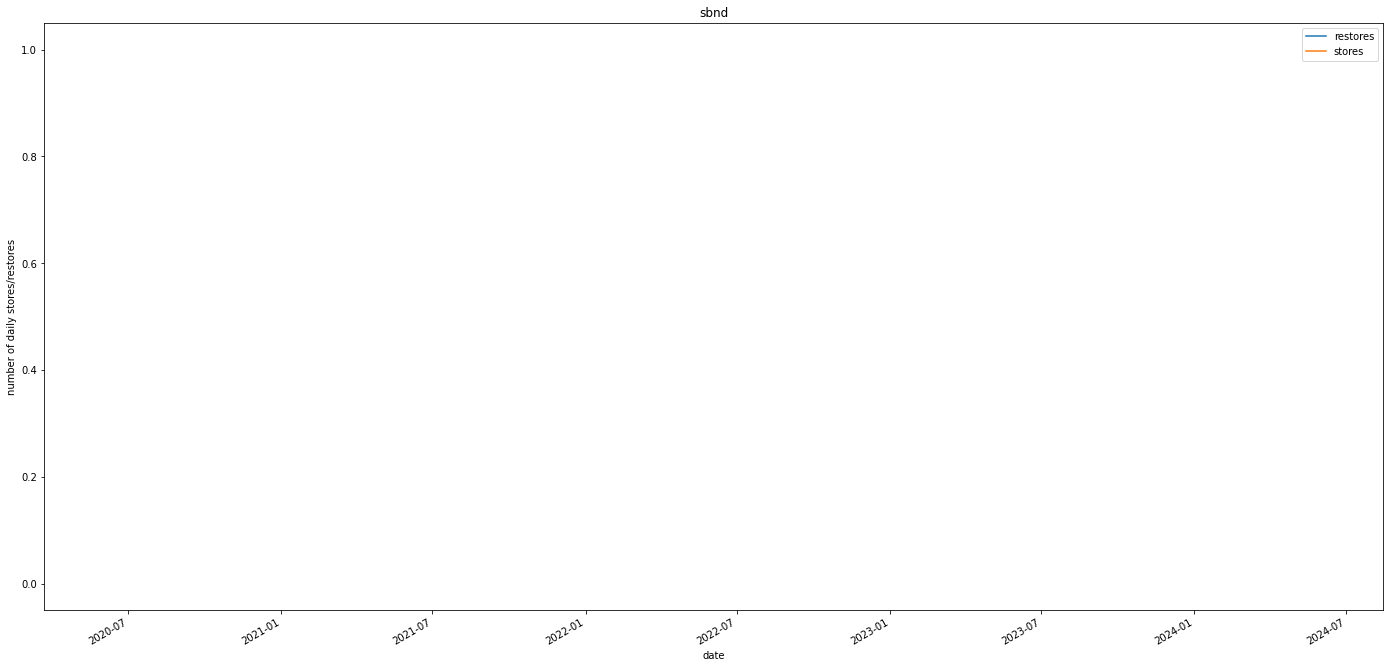

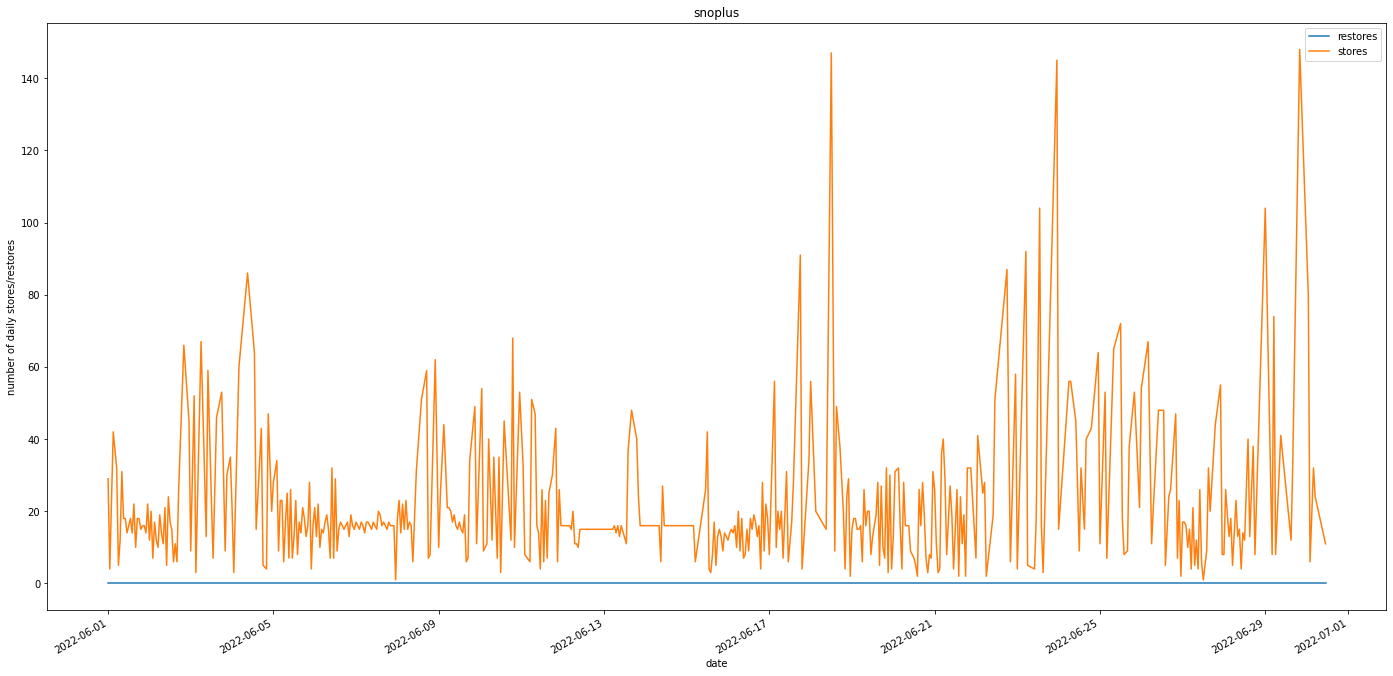

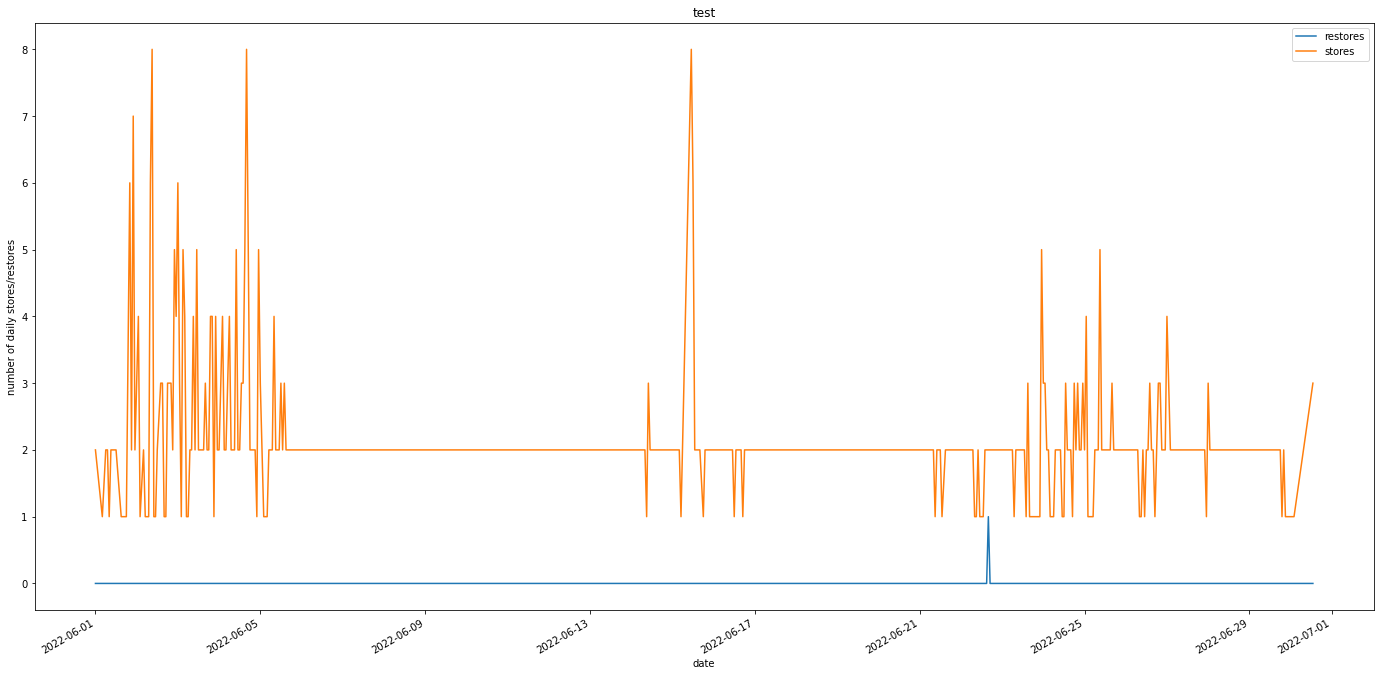

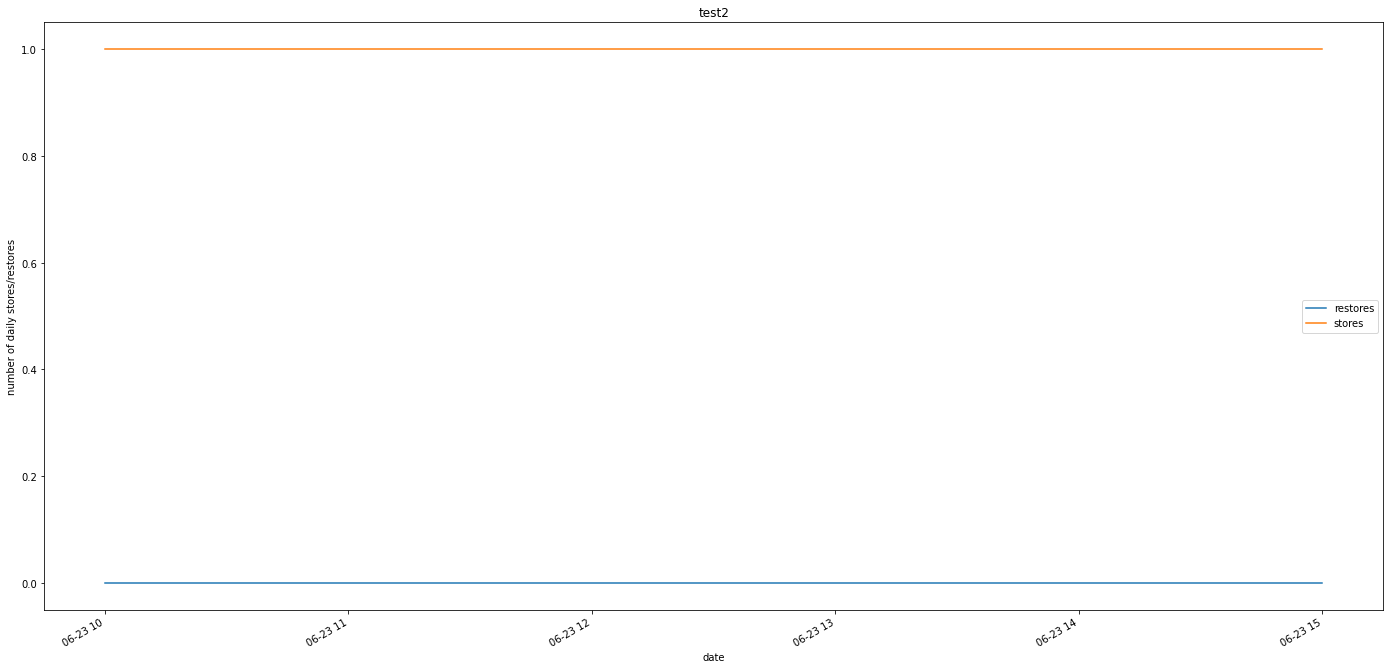

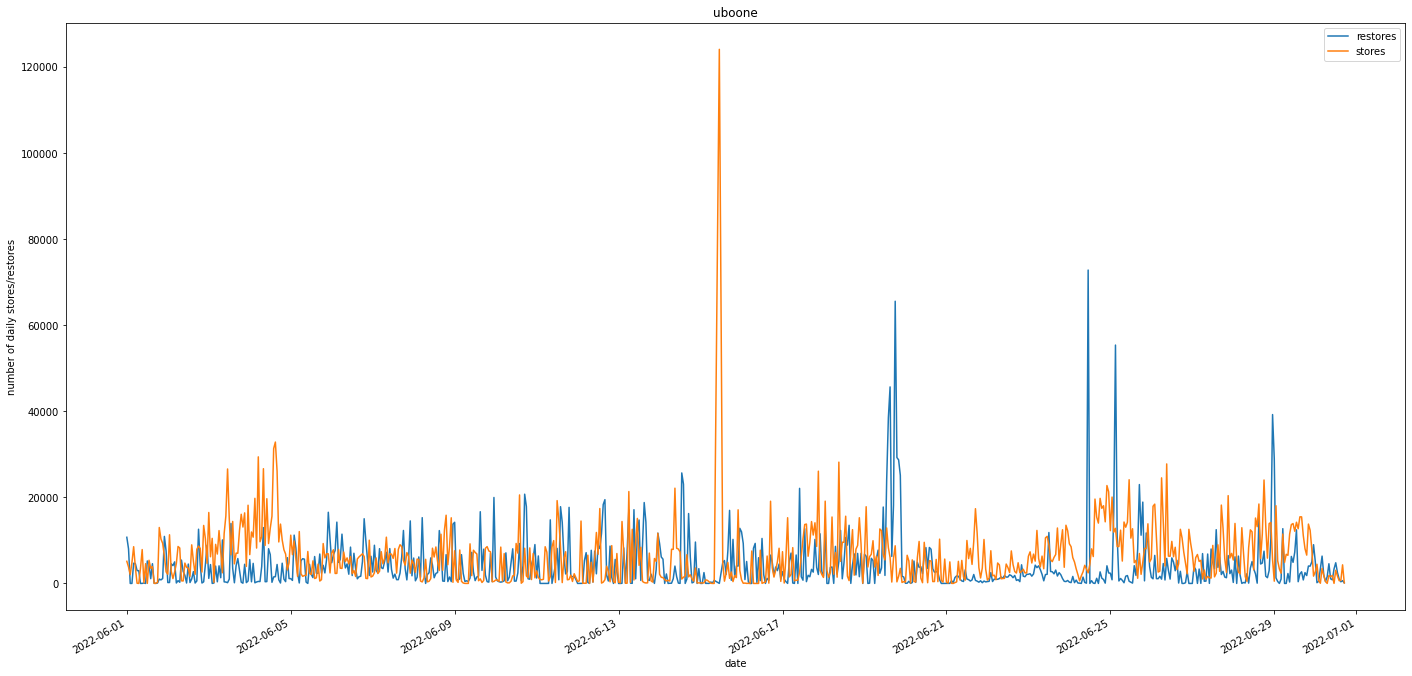

In [155]:
for vo, group in d3.groupby('vo'):
    group.plot(x='date', title=vo, figsize=(24,12))
    plt.savefig('Time Series Plot for {}.png'.format(vo), bbox_inches='tight')
    plt.ylabel("number of daily stores/restores")


<AxesSubplot:title={'center':'GM2'}, xlabel='date'>

Text(179.875, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'Simons'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'accelai'}, xlabel='date'>

Text(192.375, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'annie'}, xlabel='date'>

Text(186.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'backups'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'darkside'}, xlabel='date'>

Text(186.0, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'des'}, xlabel='date'>

Text(189.0, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'dune'}, xlabel='date'>

Text(173.5, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'e1039'}, xlabel='date'>

Text(182.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'e906'}, xlabel='date'>

Text(186.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'fermigrid'}, xlabel='date'>

Text(182.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'icarus'}, xlabel='date'>

Text(179.875, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'lariat'}, xlabel='date'>

Text(179.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'lqcd'}, xlabel='date'>

Text(186.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'minerva'}, xlabel='date'>

Text(173.375, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'mu2e'}, xlabel='date'>

Text(173.5, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'next'}, xlabel='date'>

Text(179.875, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'none'}, xlabel='date'>

Text(179.75, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'nova'}, xlabel='date'>

Text(173.375, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'sbnd'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


<AxesSubplot:title={'center':'snoplus'}, xlabel='date'>

Text(186.0, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'test'}, xlabel='date'>

Text(198.625, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'test2'}, xlabel='date'>

Text(189.125, 0.5, 'number of daily stores/restores')

<AxesSubplot:title={'center':'uboone'}, xlabel='date'>

Text(167.25, 0.5, 'number of daily stores/restores')

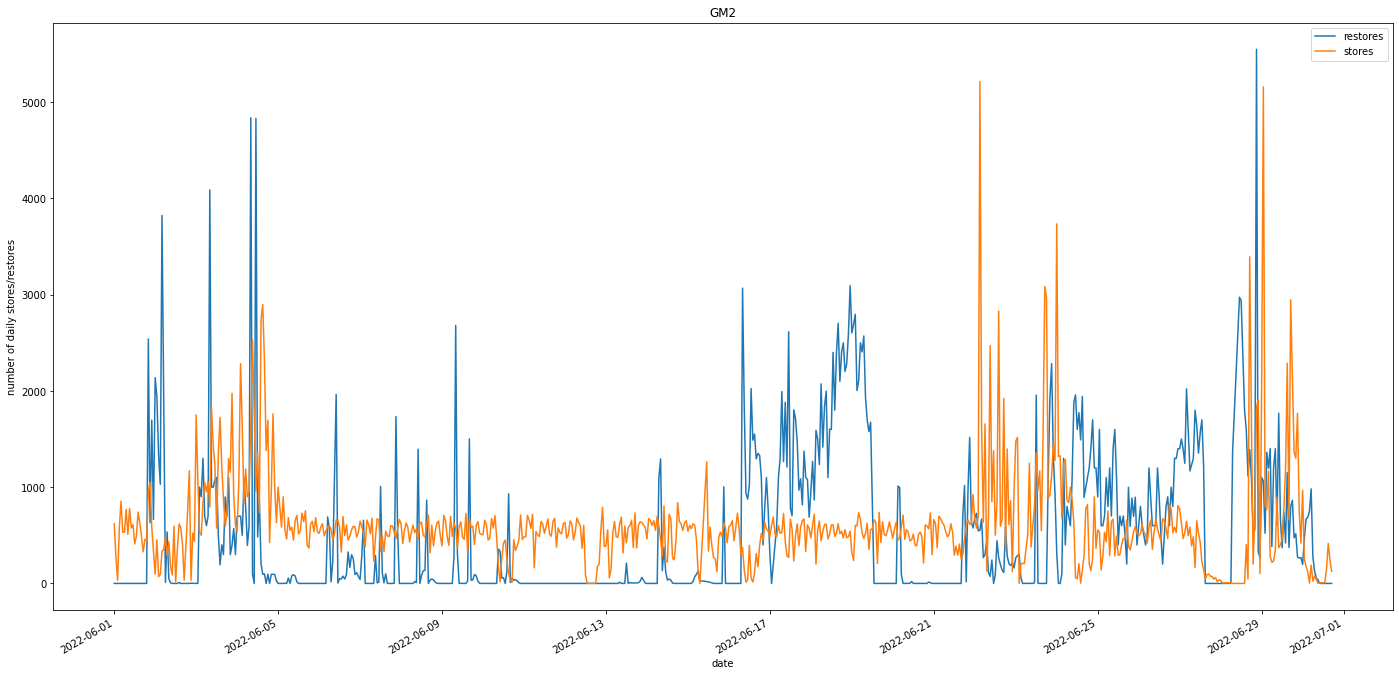

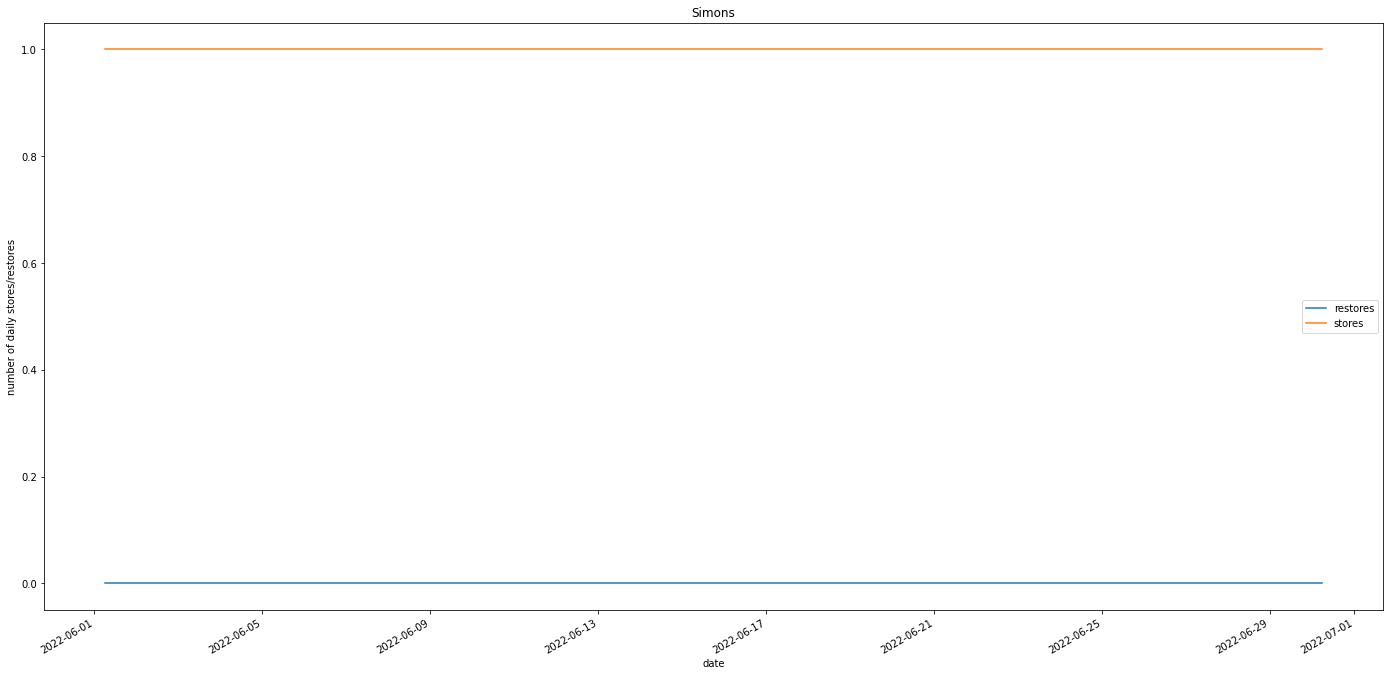

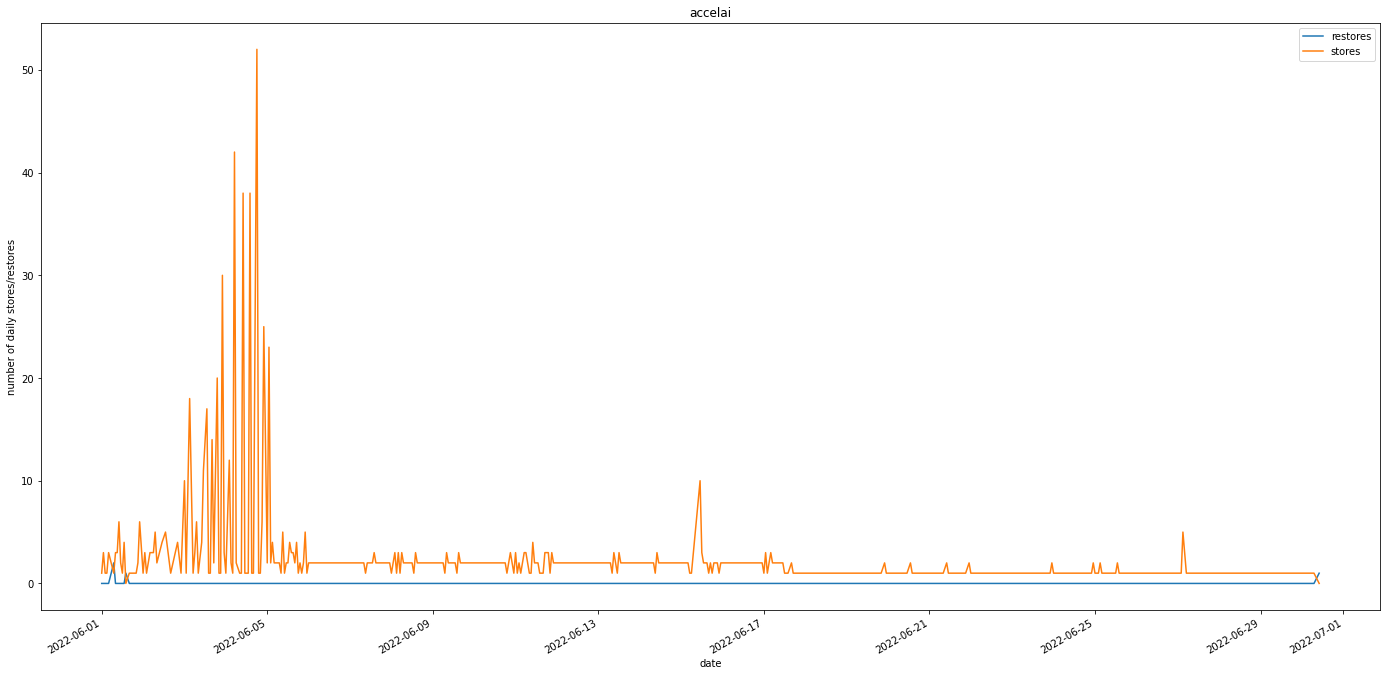

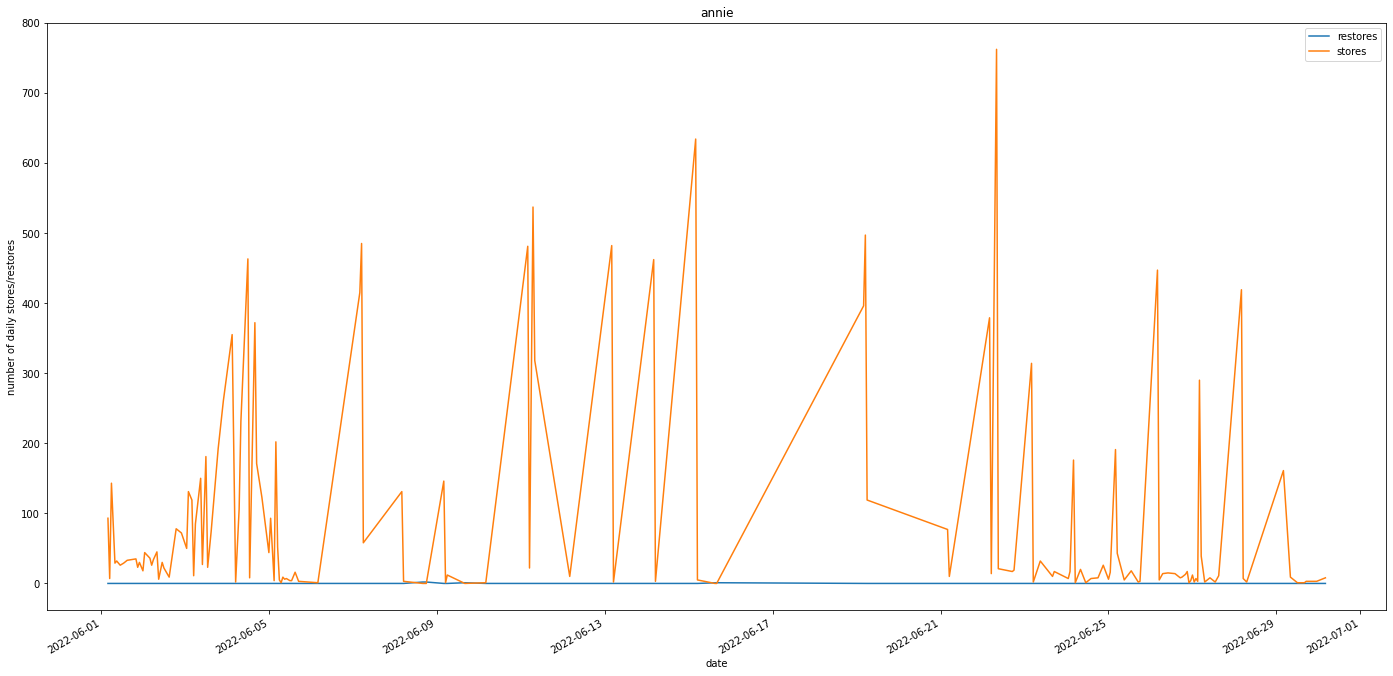

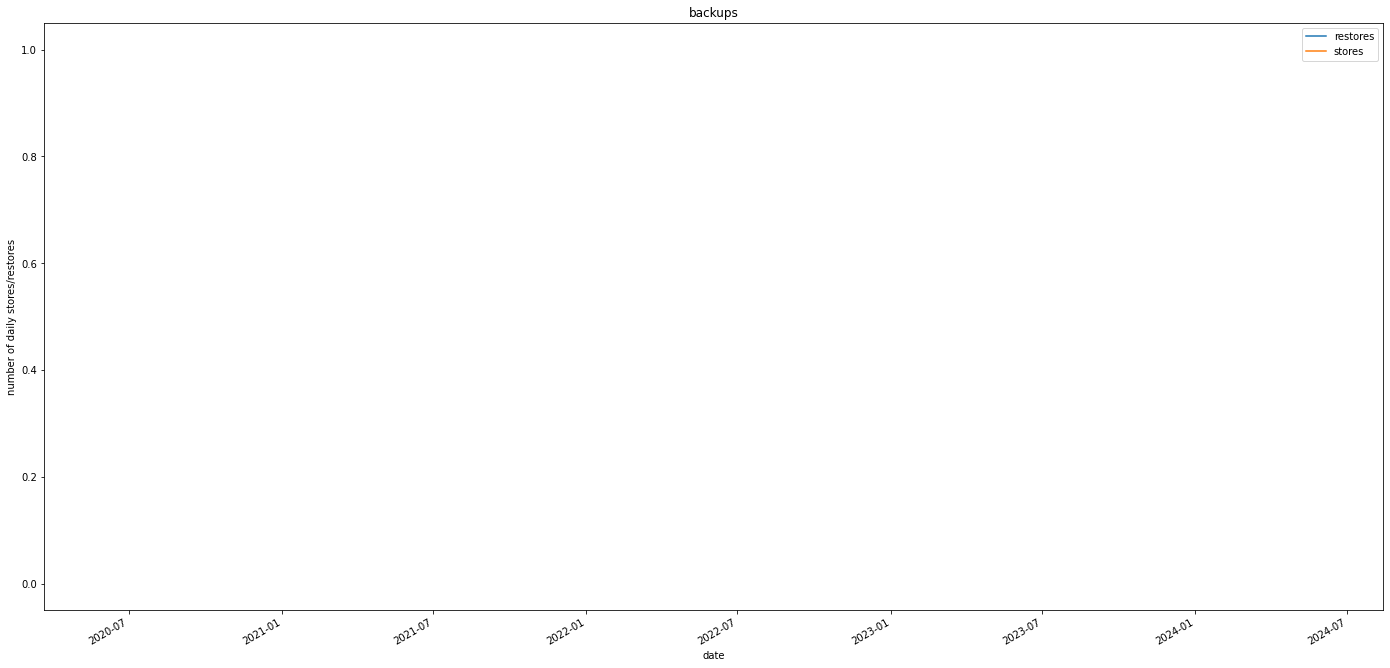

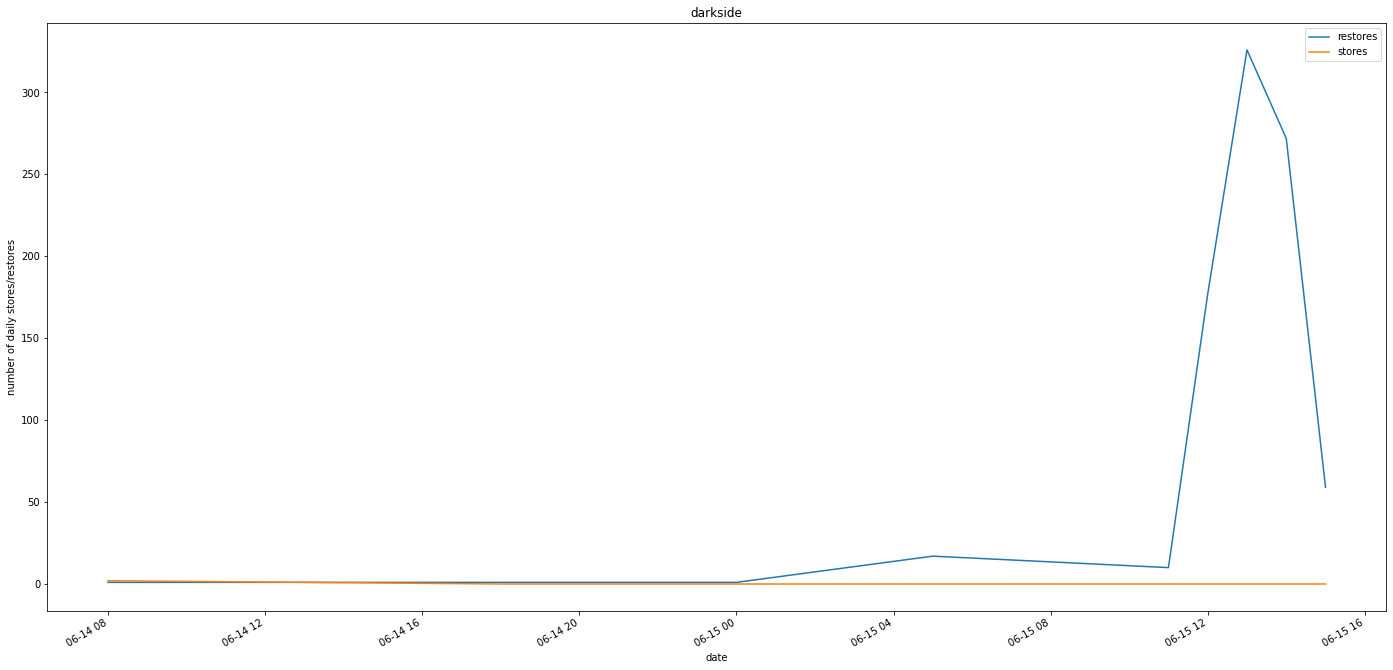

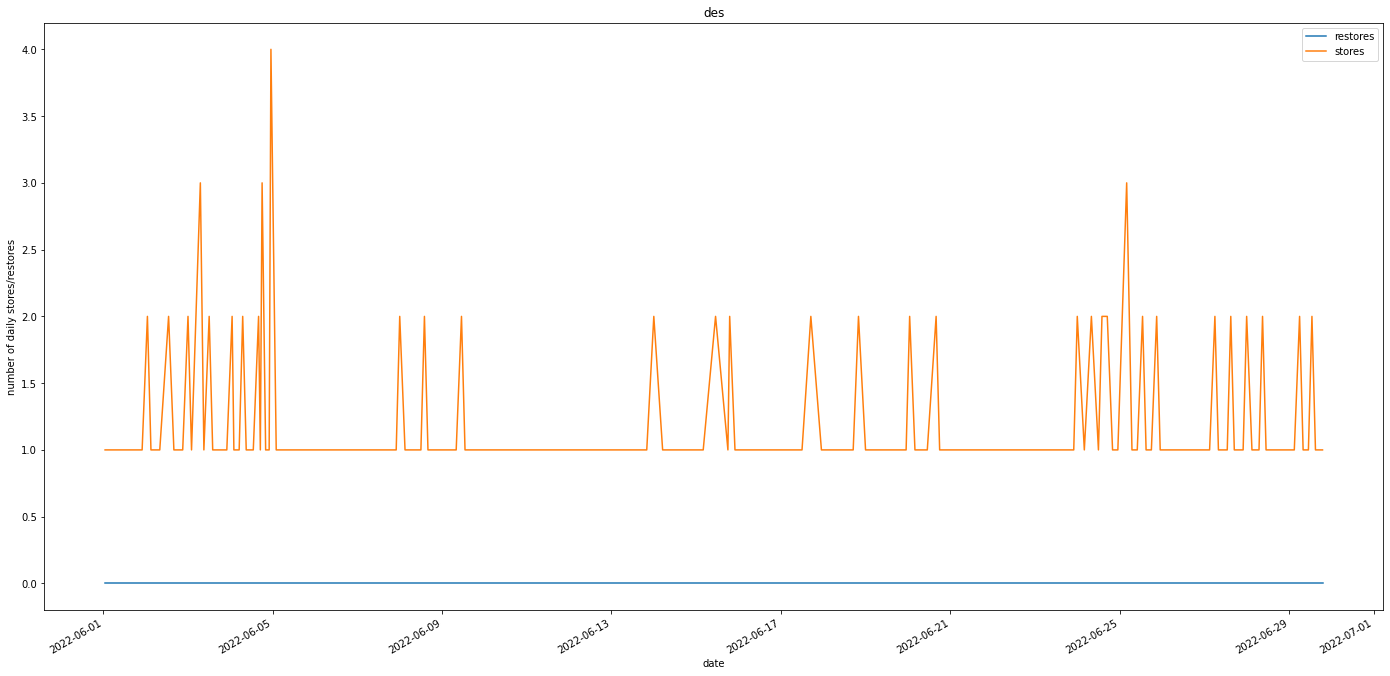

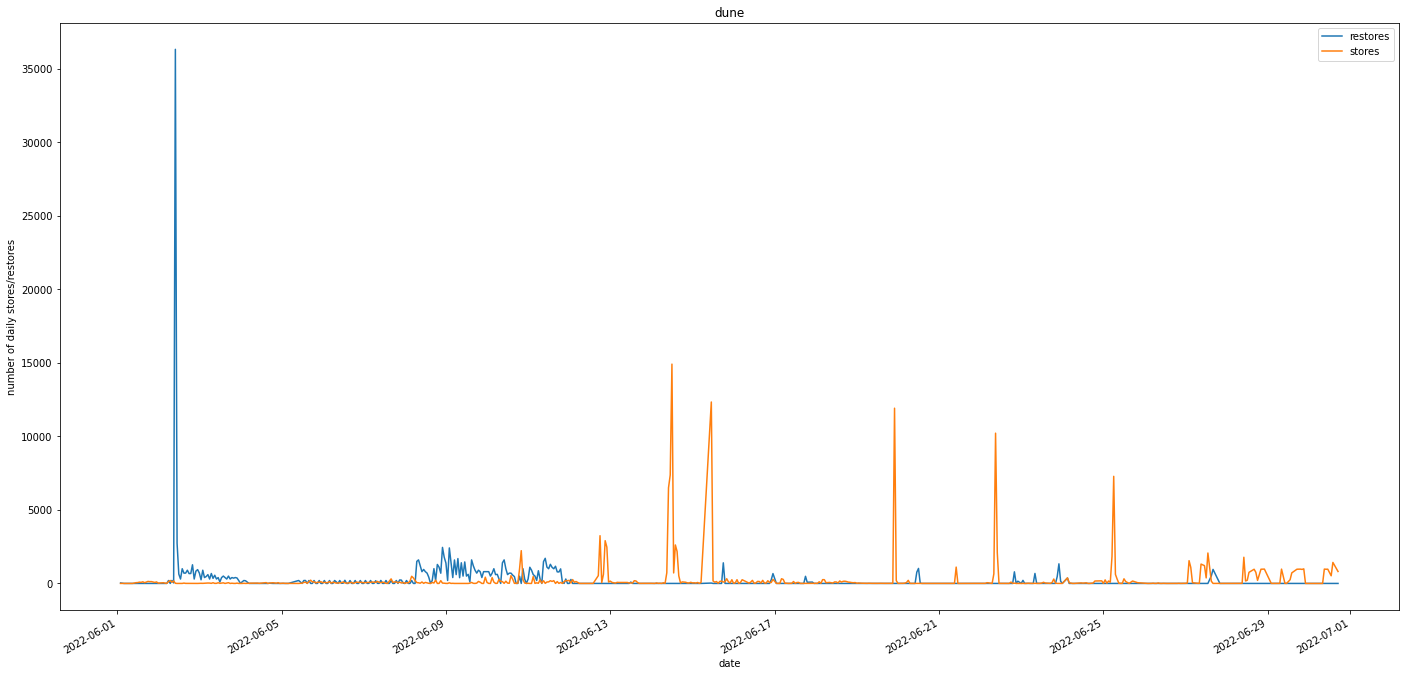

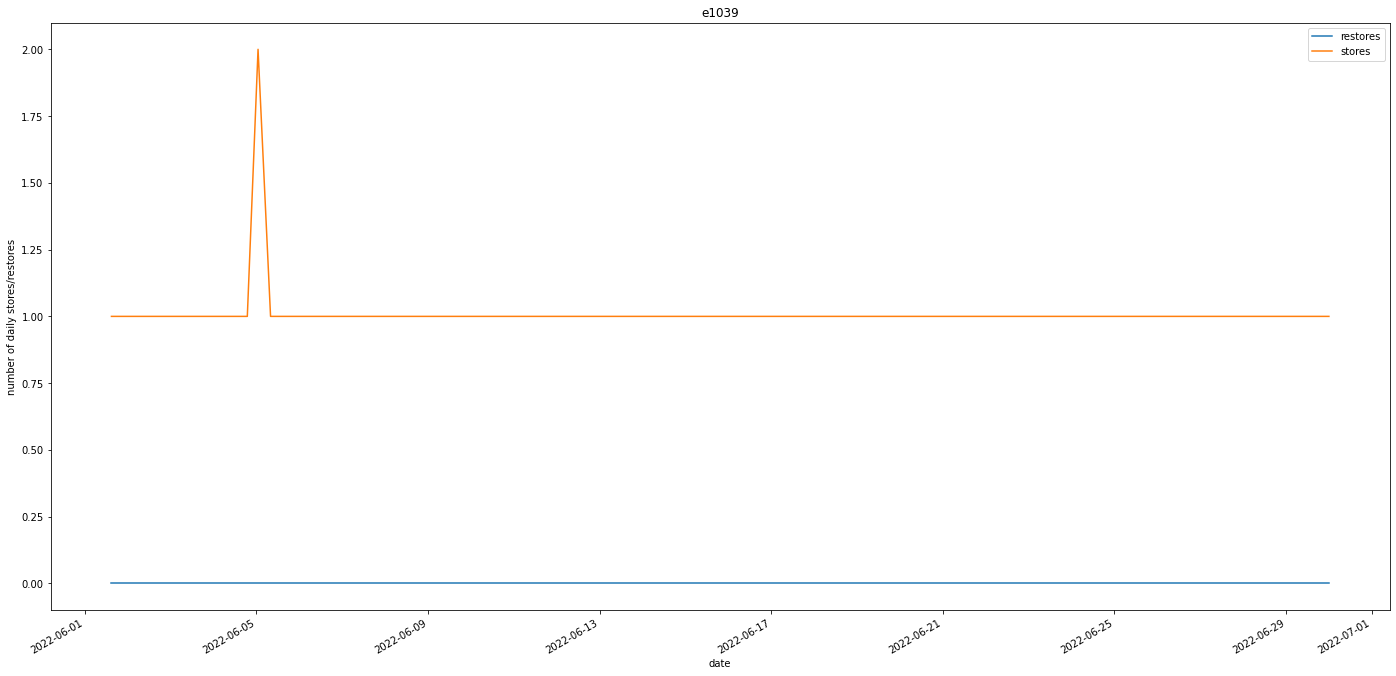

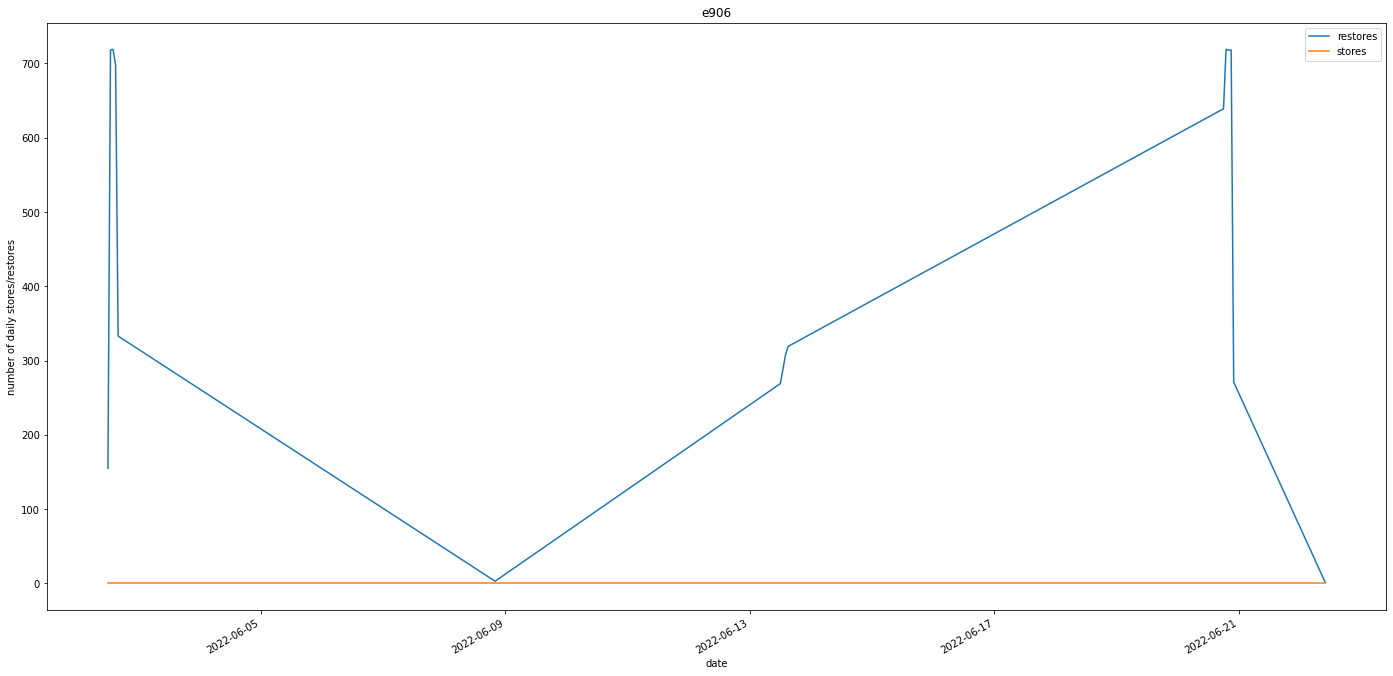

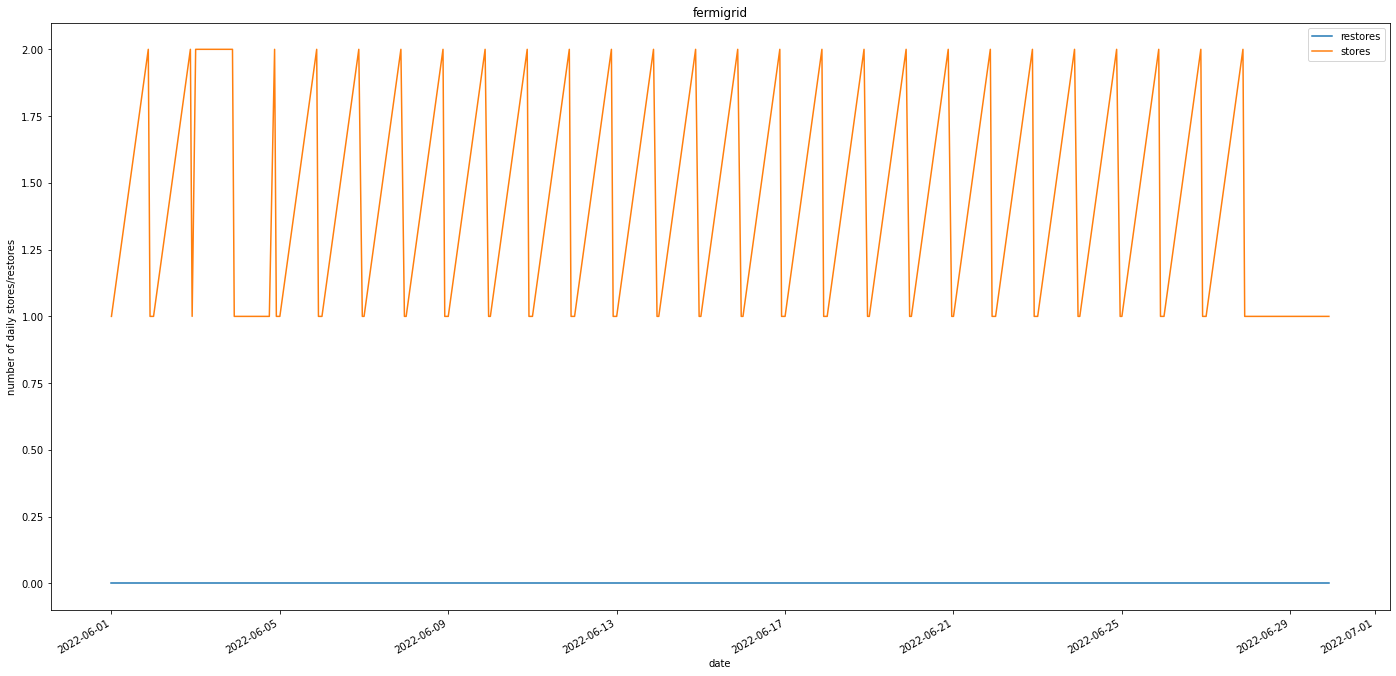

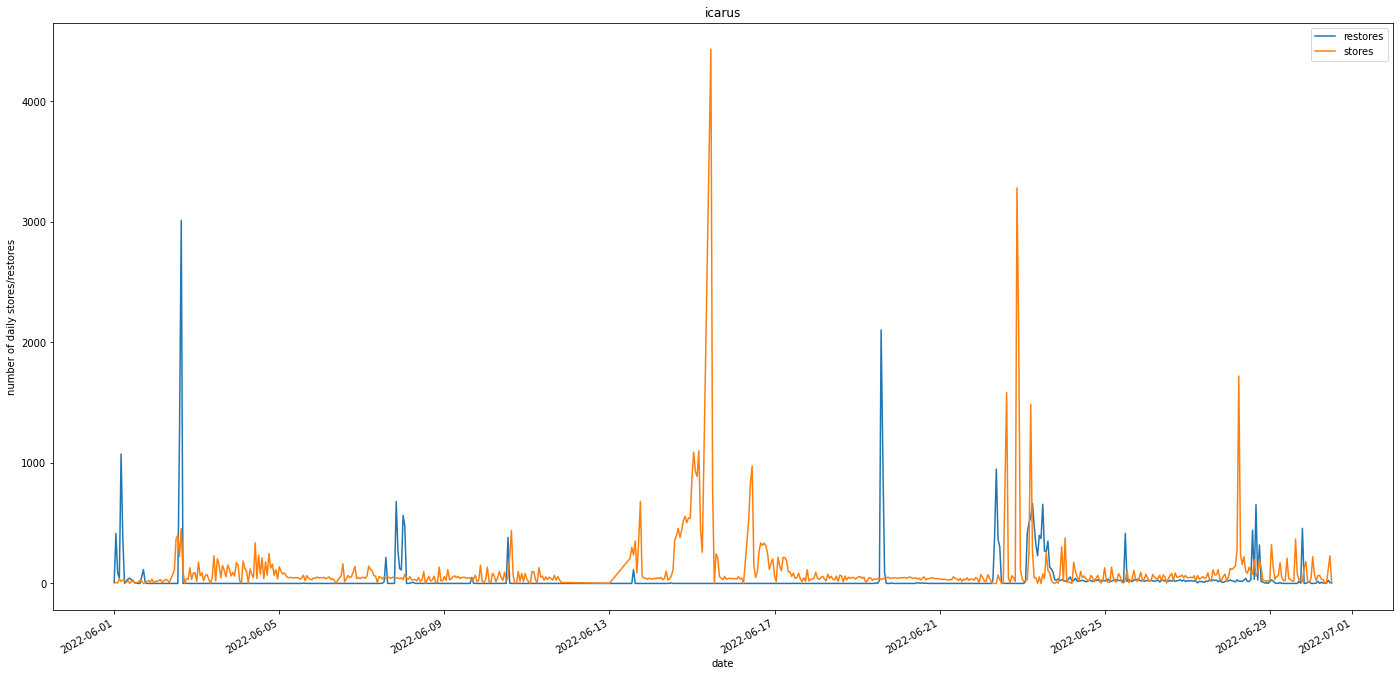

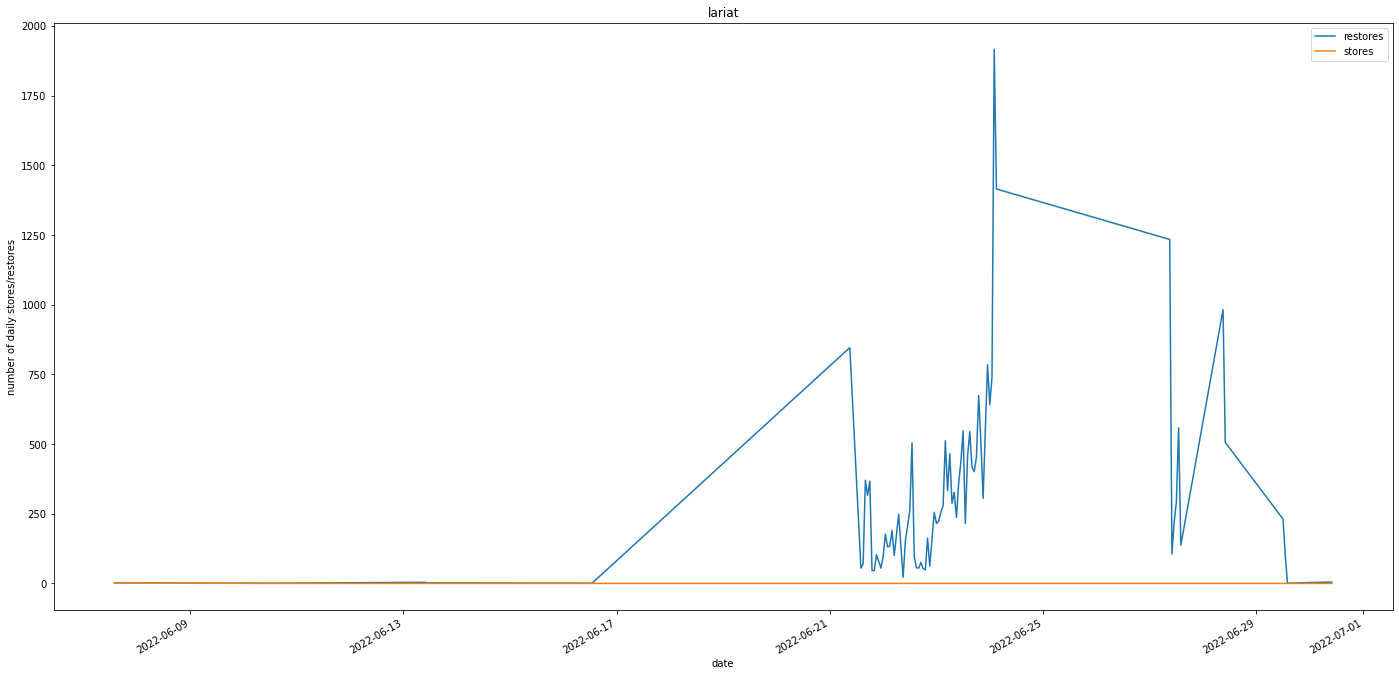

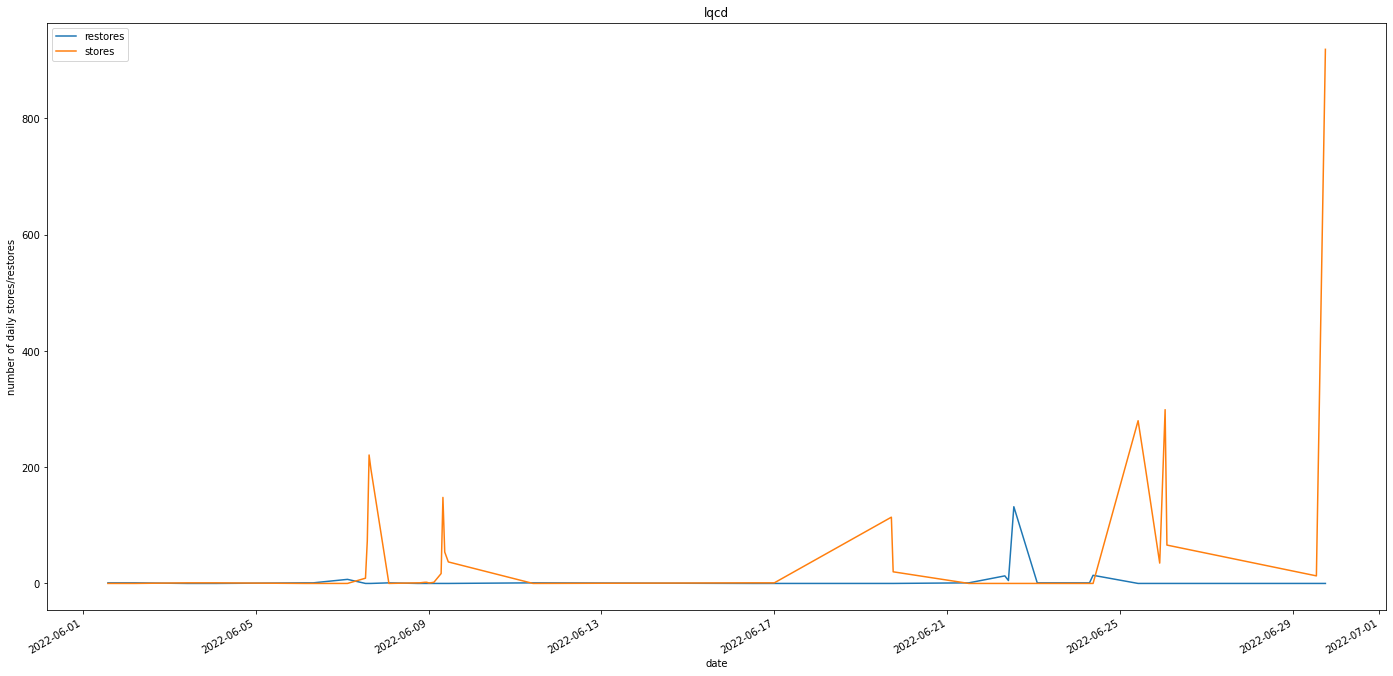

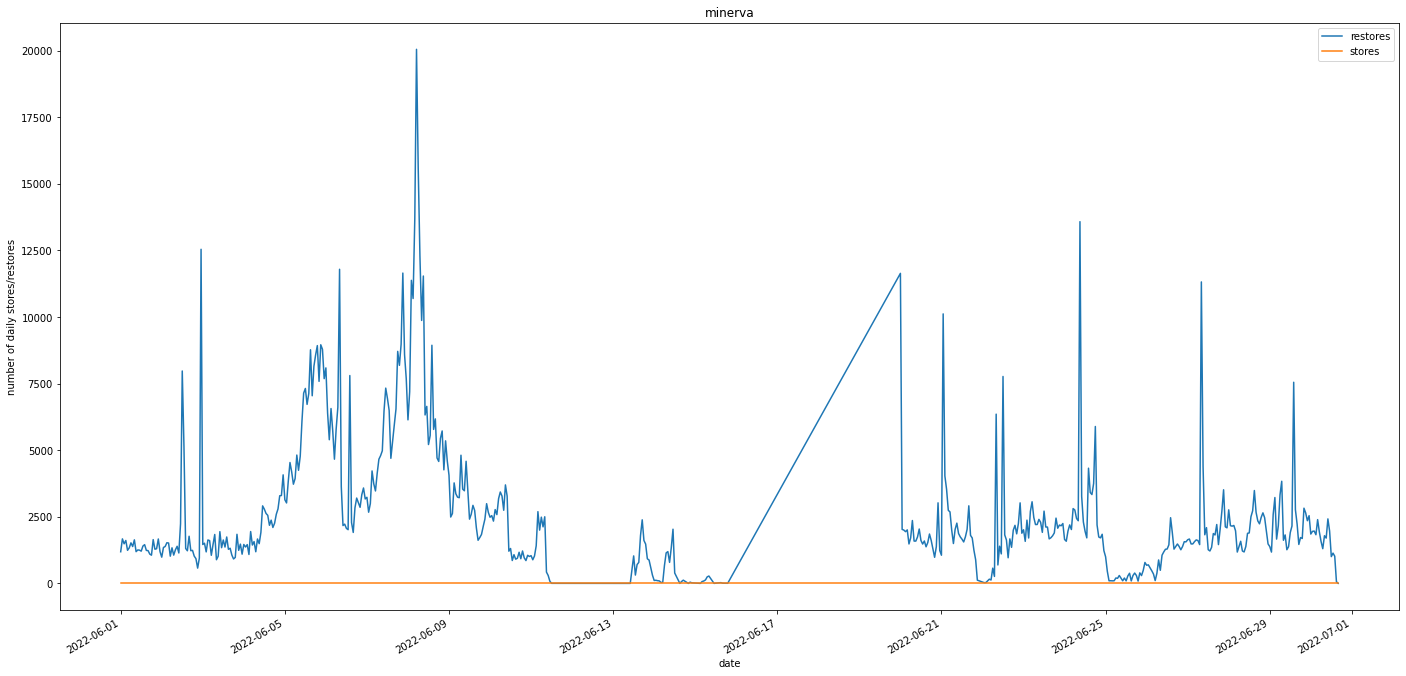

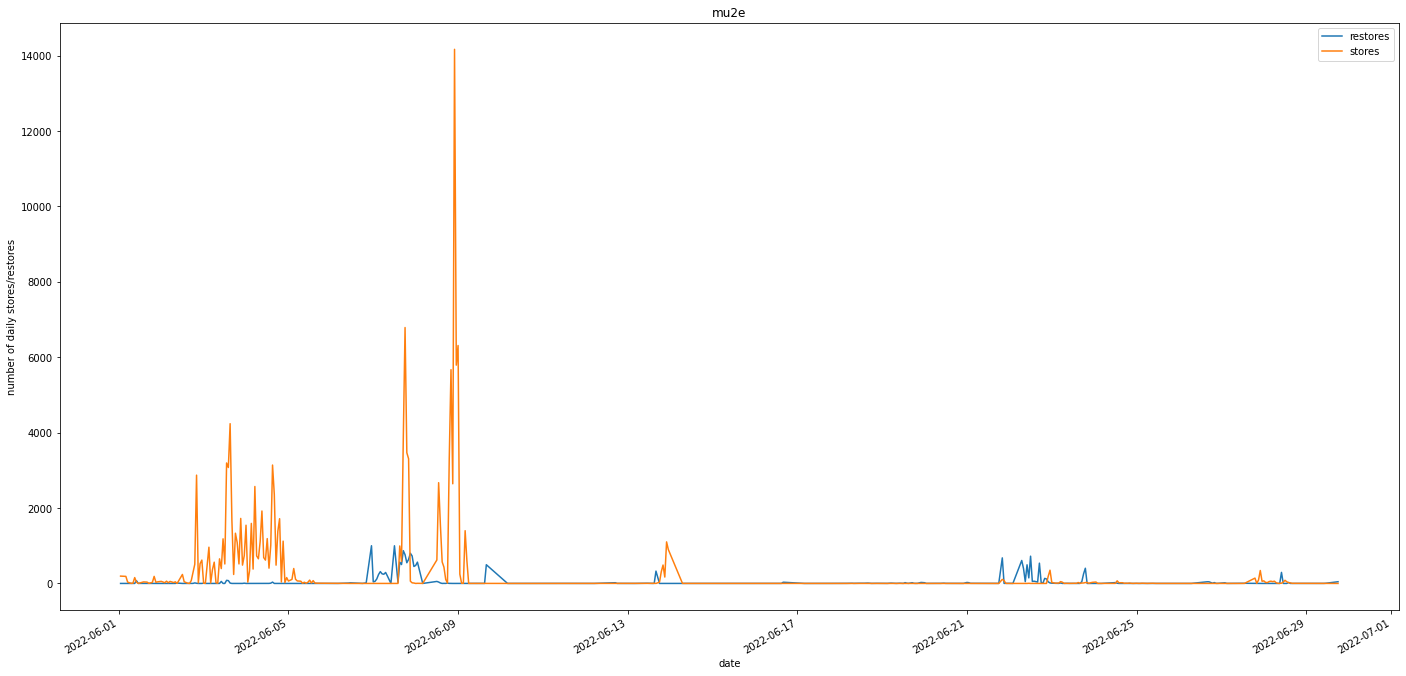

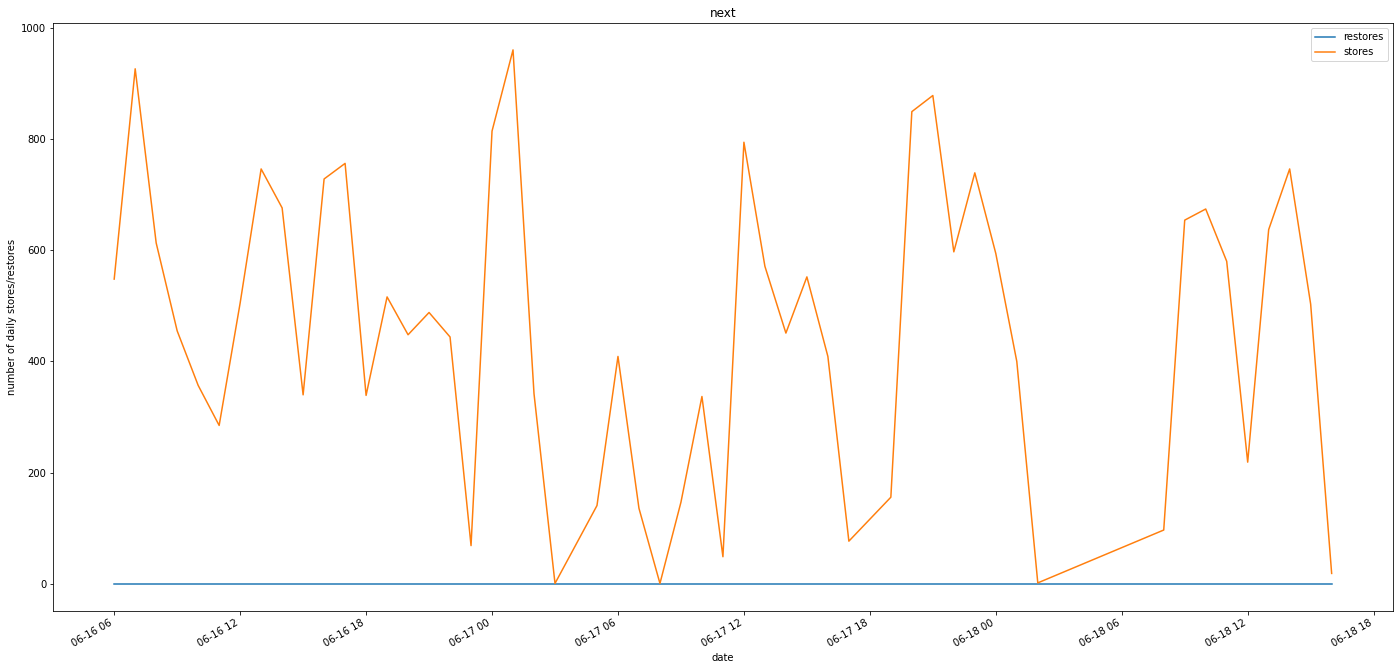

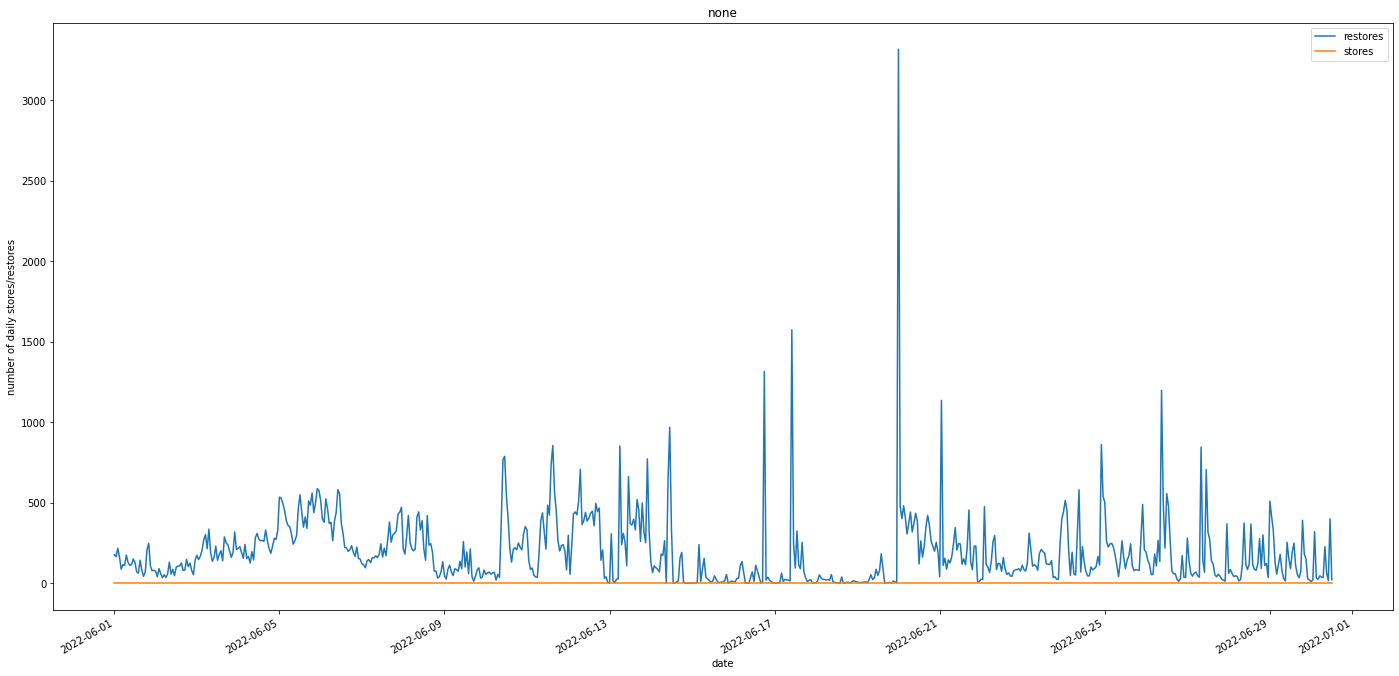

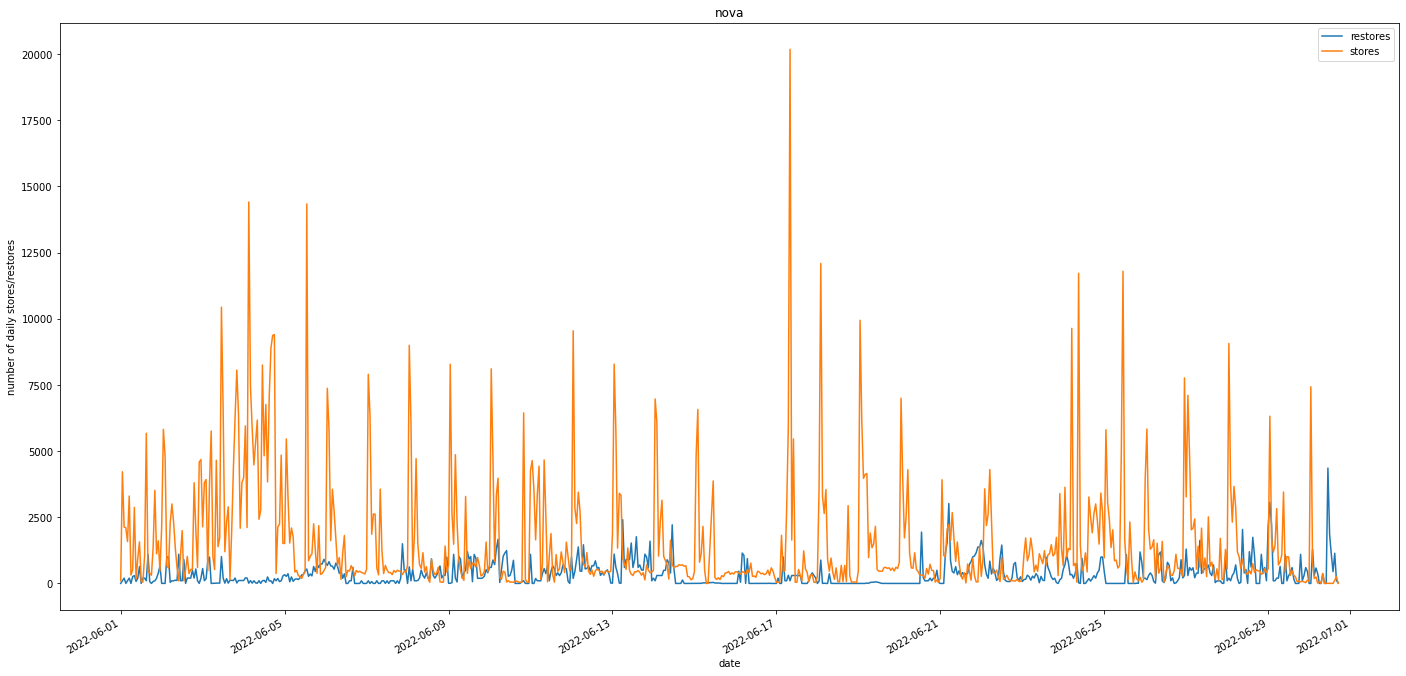

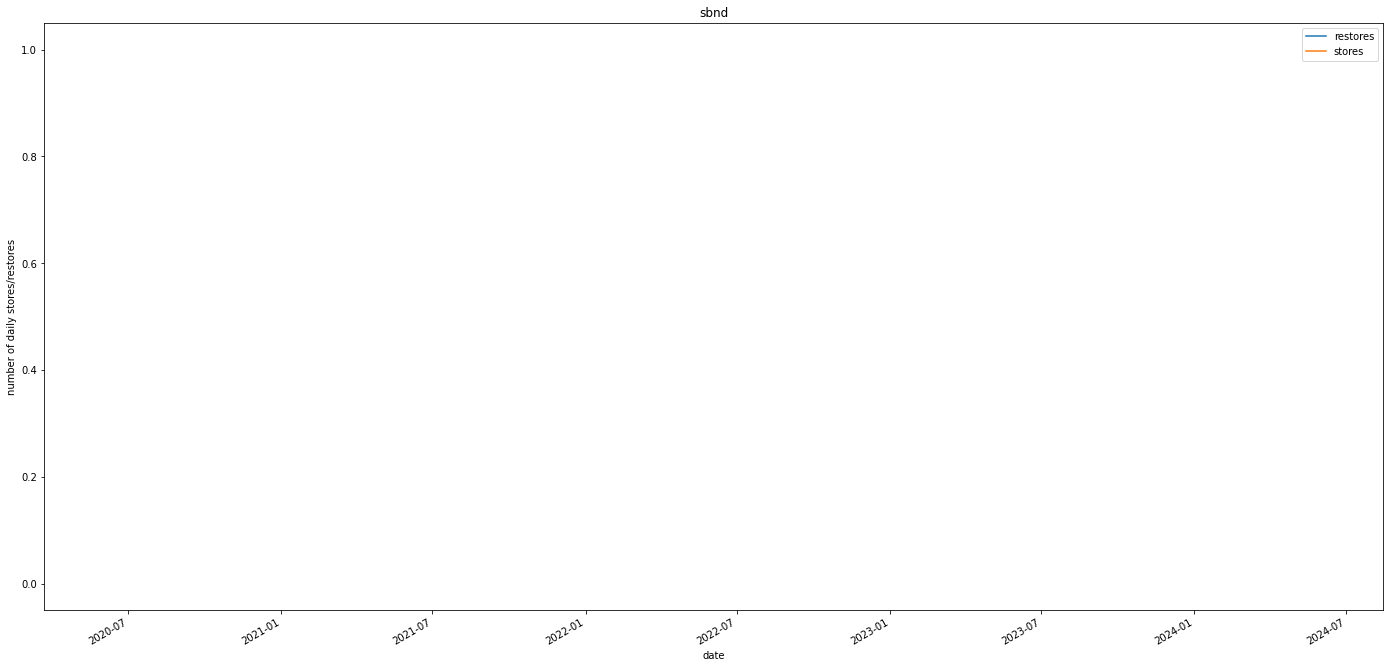

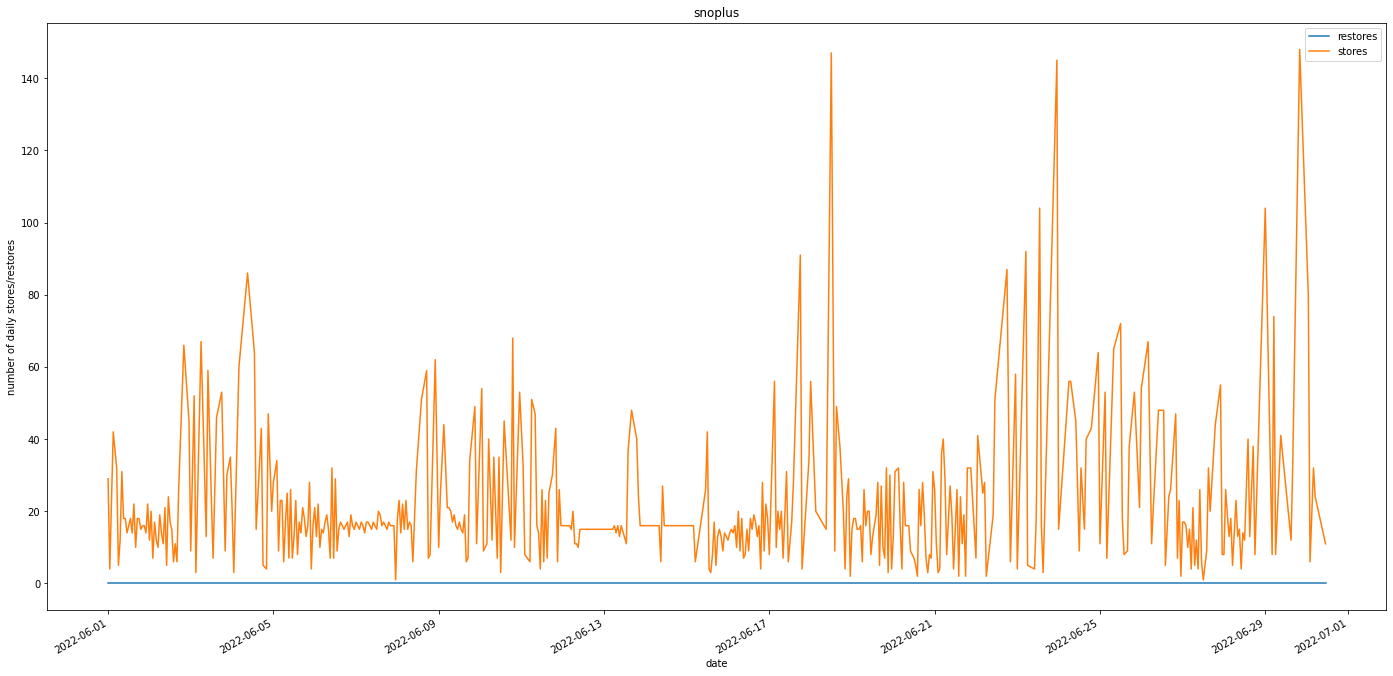

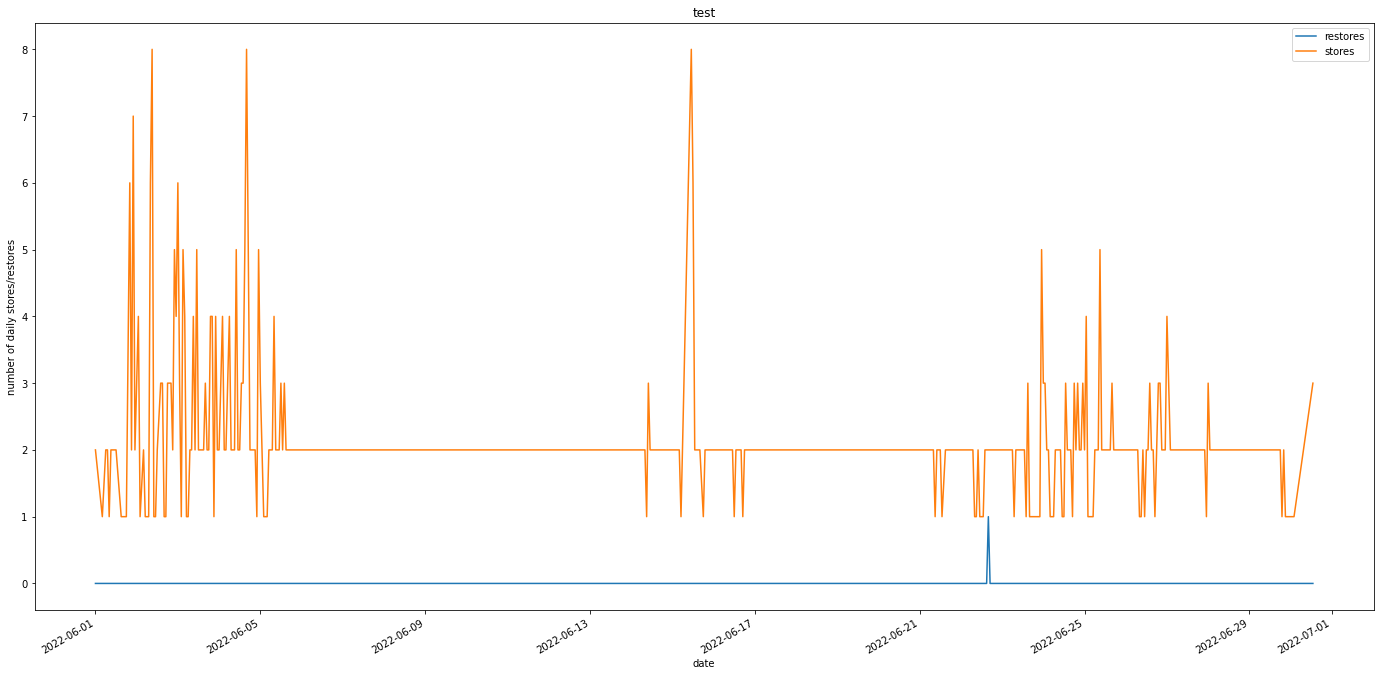

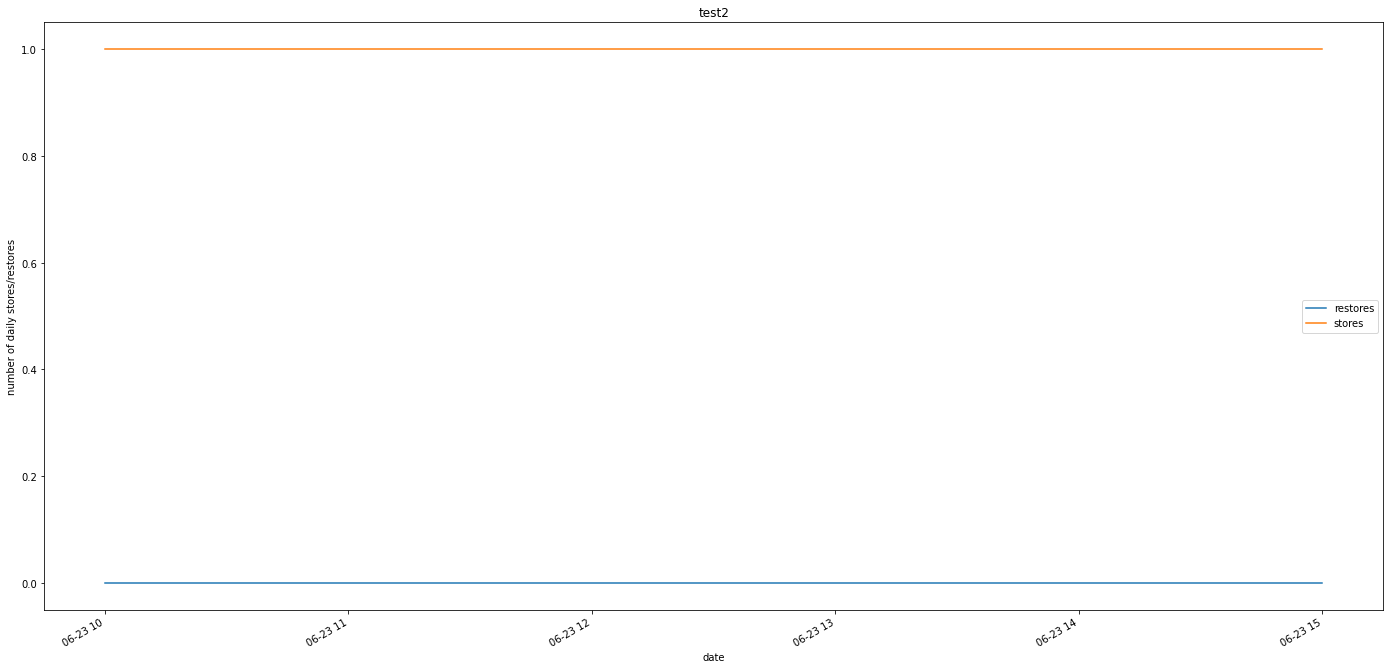

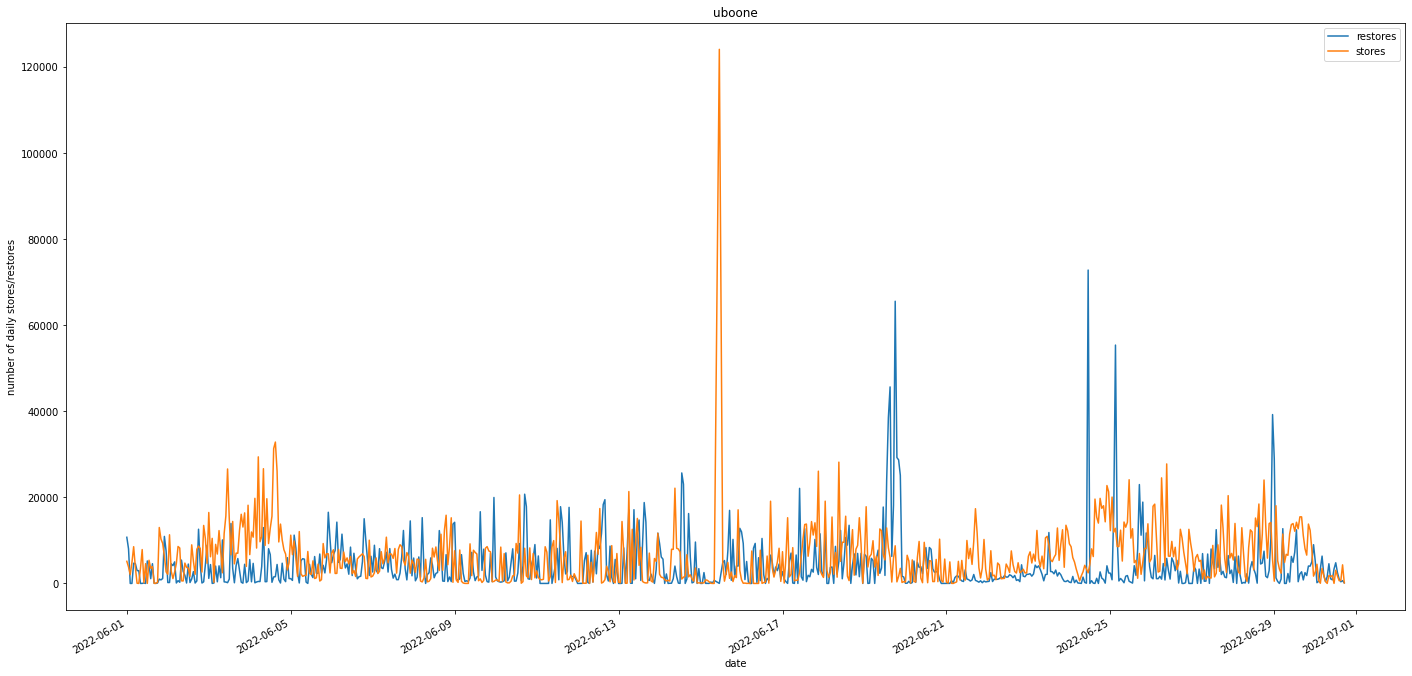

In [157]:
for vo, group in d3.groupby('vo'):
    group.plot(x='date', title=vo, figsize=(24,12))
    plt.savefig(f'restores_stores_vs_time_for_{vo}.png', bbox_inches='tight')
    plt.ylabel("number of daily stores/restores")


In [156]:
#split a pandas DataFrame into multiple DataFrames by column value

In [124]:
# grouped = d3.groupby(d3.vo)

In [130]:
# GM2 = grouped.get_group("GM2")
# GM2.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for GM2 ")
# plt.savefig('Time Series Plot for GM2.png')
# pyplot.show()

In [131]:
# Simons = grouped.get_group("Simons")
# Simons.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for Simons ")
# plt.savefig('Time Series Plot for Simons.png')
# pyplot.show()

In [132]:
# accelai = grouped.get_group("accelai")
# accelai.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for accelai ")
# plt.savefig('Time Series Plot for accelai.png')
# pyplot.show()

In [133]:
# annie = grouped.get_group("annie")
# annie.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for annie ")
# plt.savefig('Time Series Plot for annie.png')
# pyplot.show()

In [134]:
# backups = grouped.get_group("backups")
# backups.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for backups ")
# plt.savefig('Time Series Plot for backups.png')
# pyplot.show()

In [135]:
# darkside = grouped.get_group("darkside")
# darkside.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for darkside ")
# plt.savefig('Time Series Plot for darkside.png')
# pyplot.show()

In [136]:
# des = grouped.get_group("des")
# des.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for des ")
# plt.savefig('Time Series Plot for des.png')
# pyplot.show()

In [137]:
# dune = grouped.get_group("dune")
# dune.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for dune ")
# plt.savefig('Time Series Plot for dune.png')
# pyplot.show()

In [138]:
# e1039 = grouped.get_group("e1039")
# e1039.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for e1039 ")
# plt.savefig('Time Series Plot for e1039.png')
# pyplot.show()

In [139]:
# e906 = grouped.get_group("e906")
# e906.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for e906 ")
# plt.savefig('Time Series Plot for e906.png')
# pyplot.show()

In [140]:
# fermigrid = grouped.get_group("fermigrid")
# fermigrid.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for fermigrid ")
# plt.savefig('Time Series Plot for fermigrid.png')
# pyplot.show()

In [141]:
# icarus = grouped.get_group("icarus")
# icarus.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for icarus ")
# plt.savefig('Time Series Plot for icarus.png')
# pyplot.show()

In [142]:
# lariat = grouped.get_group("lariat")
# lariat.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for lariat ")
# plt.savefig('Time Series Plot for lariat.png')
# pyplot.show()

In [143]:
# lqcd = grouped.get_group("lqcd")
# lqcd.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for lqcd ")
# plt.savefig('Time Series Plot for lqcd.png')
# pyplot.show()

In [144]:
# minerva = grouped.get_group("minerva")
# minerva.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for minerva ")
# plt.savefig('Time Series Plot for minerva.png')
# pyplot.show()

In [145]:
# mu2e = grouped.get_group("mu2e")
# mu2e.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for mu2e ")
# plt.savefig('Time Series Plot for mu2e.png')
# pyplot.show()

In [146]:
# next_ = grouped.get_group("next")
# next_.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for next ")
# plt.savefig('Time Series Plot for next.png')
# pyplot.show()

In [147]:
# none = grouped.get_group("none")
# none.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for none ")
# plt.savefig('Time Series Plot for none.png')
# pyplot.show()

In [148]:
# nova = grouped.get_group("nova")
# nova.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for nova ")
# plt.savefig('Time Series Plot for nova.png')
# pyplot.show()

In [149]:
# sbnd = grouped.get_group("sbnd")
# sbnd.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for sbnd ")
# plt.savefig('Time Series Plot for sbnd.png')
# pyplot.show()

In [150]:
# snoplus = grouped.get_group("snoplus")
# snoplus.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for snoplus ")
# plt.savefig('Time Series Plot for snoplus.png')
# pyplot.show()

In [151]:
# test = grouped.get_group("test")
# test.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for test ")
# plt.savefig('Time Series Plot for test.png')
# pyplot.show()

In [152]:
# test2 = grouped.get_group("test2")
# test2.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for test2 ")
# plt.savefig('Time Series Plot for test2.png')
# pyplot.show()

In [153]:
# uboone = grouped.get_group("uboone")
# uboone.plot(x="date", y=["restores", "stores"], figsize=(24,12))
# plt.xlabel("Date")
# plt.ylabel("number of daily stores/restores")
# plt.title("Time Series Plot for uboone ")
# plt.savefig('Time Series Plot for uboone.png')
# pyplot.show()